# 1.Описание проблемы и цель<a id="1"></a>
Крушение "Титаника" - одно из самых печально известных кораблекрушений в истории. 15 апреля 1912 года, во время своего первого рейса, "Титаник" затонул после столкновения с айсбергом, в результате чего погибло 1502 из 2224 пассажиров и членов экипажа. Эта ужасная трагедия потрясла международное сообщество и привела к улучшению правил безопасности на судах.

В этой задаче нас просят завершить анализ того, какие пассажиры могли пережить трагедию, используя машинное обучение. Поэтому наша задача - предсказать, выжил ли пассажир с тонущего "Титаника" или нет с помощью машинного обучения. Так что это проблема бинарной классификации.

# 2.Импорт пакетов и cбор данных<a id="2"></a>
После импорта необходимых модулей давайте прочитаем обучающие и тестовые данные из csv-файлов.

In [160]:
"""Импорт базовых модулей."""
import numpy as np               
import pandas as pd              
import matplotlib.pyplot as plt  
import seaborn as sns            
from scipy import stats          

"""Plotly визуализация."""
import plotly.graph_objs as go
from plotly.tools import make_subplots
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True) # Требуется для использования в автономном режиме в записной книжке jupytek
import plotly.io as pio
pio.renderers.default = "png" #для гитхаба

"""Модели машинного обучения."""
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier


"""Показатели классификации (оценки)."""
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score


"""Ensembling"""
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier

In [161]:
"""Настройка визуализации."""
plt.style.use("bmh")                    # Используем стиль bmh для построения графиков
sns.set_style({"axes.grid":False})      # Удаление линий сетки

"""Создаем функцию для отображения надписей жиным шрифтом."""
from IPython.display import Markdown
def bold(string):
    return display(Markdown(f"**{string}**"))

In [162]:
"""Считывание и предварительный просмотр данных train из csv-файла."""
train = pd.read_csv("titanic_train.csv")
bold("Train Data:")
display(train.head(3))

"""Считывание и предварительный просмотр данных test из csv-файла."""
test = pd.read_csv("titanic_test.csv")
bold("Test Data:")
display(test.head(3))

**Train Data:**

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


**Test Data:**

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


**Примечание:** У нас нет выжившей переменной Test Data. Это будет нашей задачей - обучить модель на train data и train target, 
чтобы найти test target.

# 3. Описание и идентификация переменной<a id="3"></a>
Давайте опишем, что указывает каждая из переменных, и определим наши переменные ответа и предиктора. Также отделите категориальные переменные от числовых переменных и, наконец, определите типы данных pandas (т.е. object, float64 или int64) для каждой переменной.
## 3.1 Описание переменной<a id="3.1"></a>

In [163]:
"""Соединим train and test data вместе.Это избавляет от необходимости обрабатывать данные train и test отдельно."""
merged = pd.concat([train, test], sort = False).reset_index(drop=True) #sort = False - чтобы столбцы не шли по алфавиту,
#reset_index(drop=True) - чтобы нумерацию индексов шла попорядку(от 0 до 1308, а не начаналась заного с 892)
bold("Merged Data:")
display(merged.head(5))

**Merged Data:**

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [164]:
"""Размер данных"""
bold("Размер Merged Data:")
display(merged.shape)

"""Переменных в  merged data."""
bold("Имя переменных в merged data:")
display(merged.columns)

**Размер Merged Data:**

(1309, 12)

**Имя переменных в merged data:**

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Итак, что мы можем увидеть??
**Мы видим всего 12 переменных. И каждая переменная имеет 1309 наблюдений (исключая выживших).**
### Здесь приводится описание всех переменных:
1. **PassengerId** - это уникальный идентификационный номер, присвоенный каждому пассажиру.
2. **Survived** - это флаг, который указывает, выжил или умер пассажир (т. Е. 0 = Нет, 1 = Да).
3. **Pclass** - это класс пассажиров (т. е. 1 = 1-й класс, 2 = 2-й класс, 3 = 3-й класс).
4. **Name** - это имя пассажира.
5. **Sex** указывает пол пассажира (т. е. мужчина или женщина).
6. **Age** указывает возраст пассажира.
7. **Sibsp** - количество братьев и сестер/супругов на борту.
8. **Parch** - количество родителей/детей на борту.
9. **Ticket** указывает номер билета, выданного пассажиру.
10. **Fare** указывает сумму денег, потраченную на их билет.
11. **Cabin** указывает категорию салона, занимаемого пассажиром.
12. **Embarked** указывает порт, из которого пассажир вышел (т. е. C = Шербур, Q = Квинстаун, S = Саутгемптон).


### Здесь 'Survived'  является целевой переменной(target), а остальные переменные являются переменными-предикторами.

## 3.2 Категориальные и числовые переменные<a id="3.2"></a>
**Категориальные переменные:** Survived, Sex, Pclass (ordinal), Embarked, Cabin, Name, Ticket, SibSp, and Parch.

**числовые переменные:** Fare, Age, and PassengerId.
## 3.3 Типы переменных<a id="3.3"></a>

In [165]:
"""Pandas data types для наших переменных."""
bold("Тип данных переменных:")
display(merged.dtypes)

**Тип данных переменных:**

PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

1. **int тип данных:** Pclass, SibSp, Parch, and PassengerId.
2. **float тип данных:** Fare and Age, *Survived (due to concatenation)*
3. **object (numbers + strings) тип данных:** Name, Sex, Ticket, Cabin, and Embarked.

# 4.Одномерный анализ<a id="4"></a>
Одномерный анализ отдельно исследует распределение каждой переменной в наборе данных. Он рассматривает диапазон значений, а также центральную тенденцию значений. Одномерный анализ данных не рассматривает взаимосвязи между различными переменными (например, двумерный и многомерный анализ), скорее он суммирует каждую переменную отдельно. Методы выполнения одномерного анализа будут зависеть от того, является ли переменная категориальной или числовой. Для числовой переменной мы бы исследовали ее форму распределения (распределение может быть симметричным или асимметричным), используя гистограммы и графики плотности. Для категориальных переменных мы бы использовали гистограммы для визуализации абсолютного и пропорционального распределения частот. Знание распределения значений функций становится важным, когда вы используете методы машинного обучения, которые предполагают определенный тип ИТ, чаще всего гауссовский. **Давайте начнем с категориальных переменных:**

## 4.1 Категориальные переменные<a id="4.1"></a>
Для анализа категориальных переменных давайте создадим пользовательскую функцию для отображения гистограммы в абсолютном и относительном масштабе переменной в subplot.

In [166]:
"""Создаем функцию для построения абсолютной и относительной частоты переменной"""
def plotFrequency(variable): #создаем функцию с переменной variable
    # Вычисляет абсолютную частоту
    absFreq = variable.value_counts() #задаем реальное значение переменной
    # Вычисляет относительную частоту
    relFreq = variable.value_counts(normalize=True).round(4)*100 #задаем процент значения переменных
    # Создает фрейм данных с абсолютной и относительной частотой
    df = pd.DataFrame({ #создаем датафрейм из переменных частоты
        "absoluteFrequency":absFreq,
        "relativeFrequency":relFreq
    })
    
    # Создаем два графика 
    fig=make_subplots( #https://plotly.com/python-api-reference/generated/plotly.subplots.make_subplots.html
        rows=1,  #1-строка 
        cols=2, #2-столбца
        vertical_spacing=0.3,#Пространство между строками подзаголовка в нормализованных координатах участка.Должно быть значение между 0 и 1.

        subplot_titles=("Absolute Frequency", "Relative Frequency"), #название графиков
        print_grid=False) #Это скрывает "Это формат вашей сетки сюжета:" текст не будет появляться

    # создаем график для абсолютной частоты
    fig.add_trace(  #обновляем уже построенную фигуру
        go.Bar( # https://plotly.com/python-api-reference/generated/plotly.graph_objects.Bar.html
        y=df.index,  #индексы по оси У
        x=df.absoluteFrequency, #значения по оси Х
        orientation="h",  
#Данные, отображаемые диапазоном полосок, устанавливаются в y, если ориентация установлена как «v» (по умолчанию), 
#а метки установлены в x. При установке ориентации на «h» роли меняются местами.
        text=df.absoluteFrequency, #показывает значение переменной на самом графике
        hoverinfo="x+y",  #определяет, какая информация о трассировке отображается при наведении.
        textposition="auto", #указывает расположение текста.
        name="Abs Freq", #название графика
        textfont=dict(family="sans serif",size=14), #Задает шрифт, используемый для текста 
        marker = dict(color=df.absoluteFrequency, colorscale="Rainbow")), #цвет переменных на графике
        row=1, #первый ряд
        col=1  #первый столбец
        )

    # создаем график для относительной частоты(по аналогии)
    fig.add_trace(
        go.Bar(y=df.index,
        x=df.relativeFrequency.round(2),
        orientation="h",
        text=df.relativeFrequency.round(2),
        hoverinfo="x+y",
        textposition="auto", 
        name="Rel Freq(%)",
        textfont=dict(family="sans serif",size=15),
        marker=dict(color=df.relativeFrequency.round(2), colorscale="Rainbow")),
        row=1,
        col=2
        )

    #Добавляем заголовок, размер и цвет фона
    fig.layout.update(
        height=600, #величина графика по У
        width=970, #величина графика по Х
        hovermode="closest", #
        title_text=f"Absolute and Relative Frequency of {variable.name}",showlegend=False,
        paper_bgcolor="rgb(243, 243, 243)", #цвета фона бумаги на которой установлен график
        plot_bgcolor="rgb(243, 243, 243)" #Устанавливает цвет фона области построения между осями x и y.
        )

    # Выделяем заголовок по оси У жирным шрифтом
    fig.layout.yaxis1.update(title=f"<b>{variable.name}</b>") #название оси Y (/b> - с обоих сторон делает шрифт жирным)
    
    # Выделите заголовок по оси Х жирным шрифтом
    fig.layout.xaxis1.update(title="<b>Abs Freq</b>") #названия оси Х
    fig.layout.xaxis2.update(title="<b>Rel Freq(%)</b>")
    return fig.show() 

###  4.1.1 Survived(выжил или умер пассажир )<a id="4.1.1"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



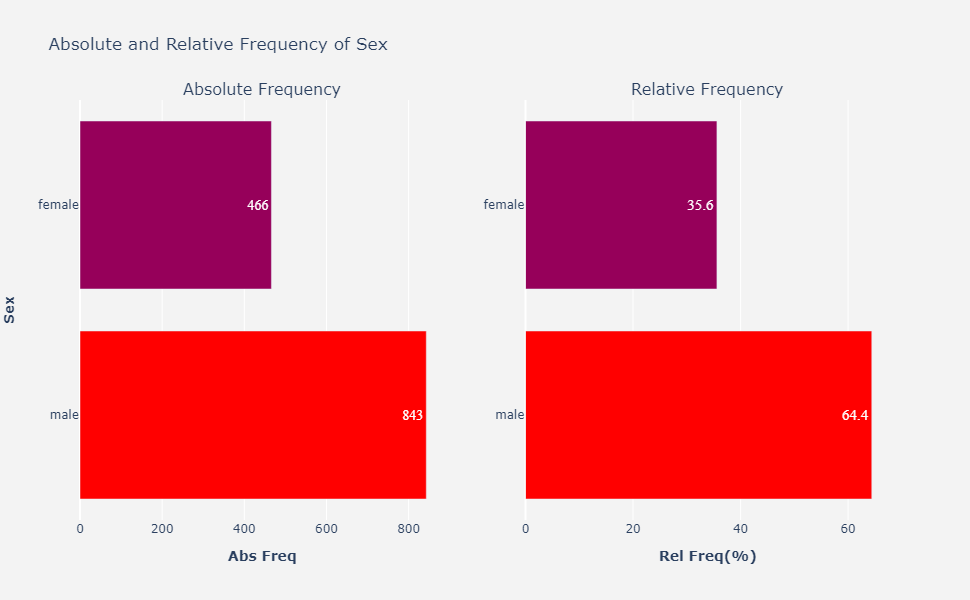

In [167]:
"""Plot number of survivors and victims in absolute and relative scale in the tragedy."""
plotFrequency(merged.Sex)

**Выводы:** Переменная Survived является несбалансированной, поскольку доля выживших и жертв не в равной степени представлена в ее распределении. Из 891 пассажира выжили только 342 пассажира, а колоссальные 549 пассажиров погибли. Или, другими словами, 61,62 % пассажиров погибли, в то время как только 38,38 % пассажиров посчастливилось выжить.

### 4.1.2 Sex(пол)<a id="4.1.2"></a>

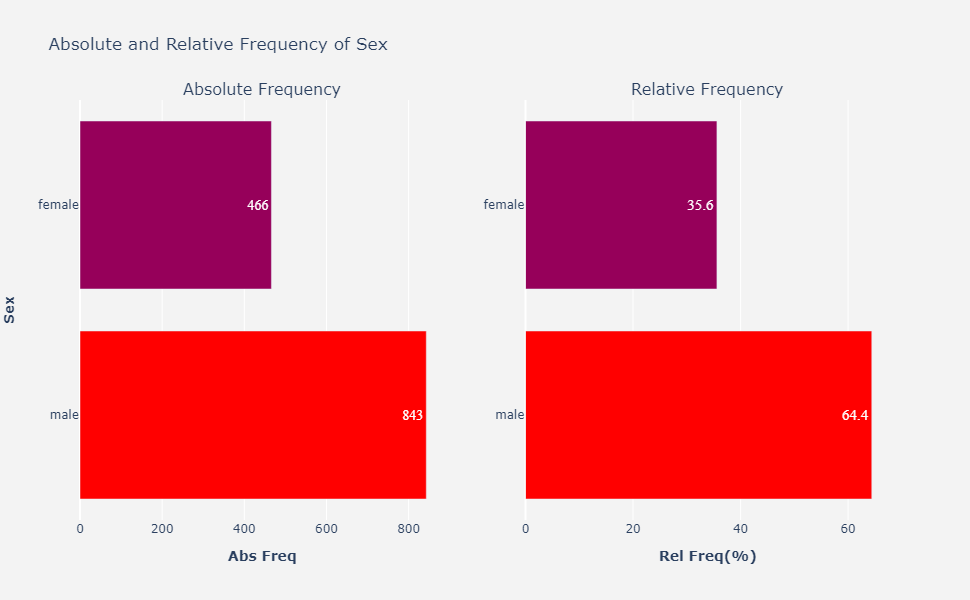

In [168]:
"""Plot the absolute and relative frequency of Sex."""
plotFrequency(merged.Sex)

**Выводы:** Переменный пол несбалансирован, поскольку доля мужчин и женщин в его распределении представлена неравномерно. Скорее, мужчины (843) превысили число женщин (466) по переменному полу. Или, пропорционально, более 64 % переменной пола состоит из мужчин, в то время как женщины составляют только более 35,5 % от Пола.

### 4.1.3 Pclass(класс пассажиров)<a id="4.1.3"></a>

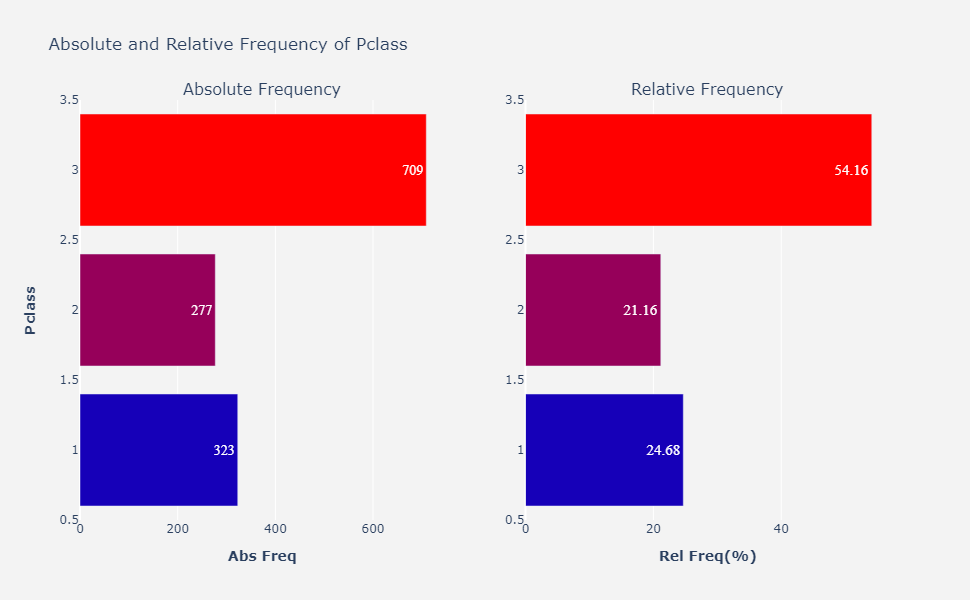

In [169]:
"""Absolute and relative frequency of Pclass."""
plotFrequency(merged.Pclass)

****Выводы:** Опять распределение классов по классам несбалансировано, поскольку три категории классов неравномерно представлены в их распределении. 3 (Pclass3) - это наиболее часто встречающиеся (709) уровни класса, в то время как 2 - наименее встречающиеся (277). Другой способ сказать, что более 54 % переменной класса состоит из 3 (P класс 3), в то время как 1 и 2 в совокупности составляют почти 46 % класса P.

### 4.1.4 Embarked(порт, из которого пассажир вышел)<a id="4.1.4"></a>

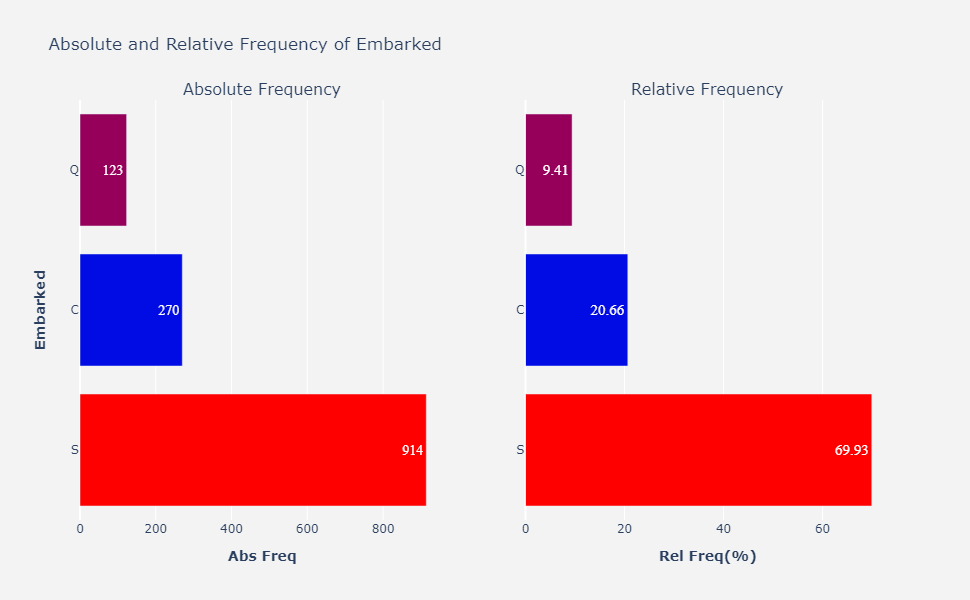

In [170]:
"""Plot absolute and relative frequency of Embarked."""
plotFrequency(merged.Embarked)

**Выводы:** Начатый также несбалансирован, поскольку его уровни неравномерно представлены в его распределении. Колоссальные колличество (914) пассажиров отправились из Саутгемптона, в то время как всего 123 отправились из Квинстауна. Другими словами, почти 70 % отправленных состоит из S, в то время как и C, и Q вносят вклад в 30 отправленных.

### 4.1.5 Cabin(указывает категорию салона, занимаемого пассажиром)<a id="4.1.5"></a>

In [171]:
"""Absolute frequency of Cabin."""
absFreqCabin = merged.Cabin.value_counts(dropna = False)
bold("Categories of Cabin:")
display(absFreqCabin.head())

**Categories of Cabin:**

NaN                1014
C23 C25 C27           6
G6                    5
B57 B59 B63 B66       5
D                     4
Name: Cabin, dtype: int64

In [172]:
"""Поскольку частота кают не соответствует нашим ожиданиям, давайте посчитаем общее количество категорий в каюте."""
bold("Всего категорий в Cabin:")
display(absFreqCabin.count())

**Всего категорий в Cabin:**

187

In [173]:
"""Посмотрим переменную Cabin, чтобы увидеть, что вызывает неравномерность."""
bold("Переменная Cabin:")
display(merged.Cabin.head(7))

**Переменная Cabin:**

0     NaN
1     C85
2     NaN
3    C123
4     NaN
5     NaN
6     E46
Name: Cabin, dtype: object

****Выводы:** Похоже, что Cabin - это переменная буквенно-цифрового типа с 1014 отсутствующими наблюдениями. В каюте с переменной Cabin есть 187 видов категорий. Поскольку в салоне слишком много категорий, мы должны обработать (т.е. уменьшить количество категорий) Cabin , чтобы проверить, есть ли какая-либо связь между Survived  и Cabin.

### 4.1.6 Name(Имя)<a id="4.1.6"></a>

In [174]:
"""Коллиество категорий в Name."""
bold("Всего категорий в Name:")
display(merged.Name.value_counts().count())

**Всего категорий в Name:**

1307

In [175]:
"""Давайте, наконец, проверим, что находится внутри переменной Name."""
bold("Предварительный просмотр Name:")
display(merged.Name.head())

**Предварительный просмотр Name:**

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

**Выводы:** Как и ожидалось, имя содержит строки с 1307 вариантами. Так что, как и в Каюте, мы должны обработать Name, чтобы получить от него какую-либо подсказку о выживании.

### 4.1.7 Ticket(Билет)<a id="4.1.7"></a>

In [176]:
"""Общее количество групп в переменной Ticket."""
bold("Колличество групп Ticket:")
display(merged.Ticket.value_counts().count())

**Колличество групп Ticket:**

929

In [177]:
"""Давайте проведем расследование Ticket."""
bold("Предварительный просмотр Ticket:")
display(merged.Ticket.head())

**Предварительный просмотр Ticket:**

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

**Выводы:** Похоже, что в билете также слишком много уникальных категорий (929). Будучи переменной буквенно-цифрового типа, мы должны обработать тикет, чтобы получить любую полезную информацию о выживании.

### 4.1.8 SibSp(количество братьев и сестер/супругов на борту)<a id="4.1.8"></a>

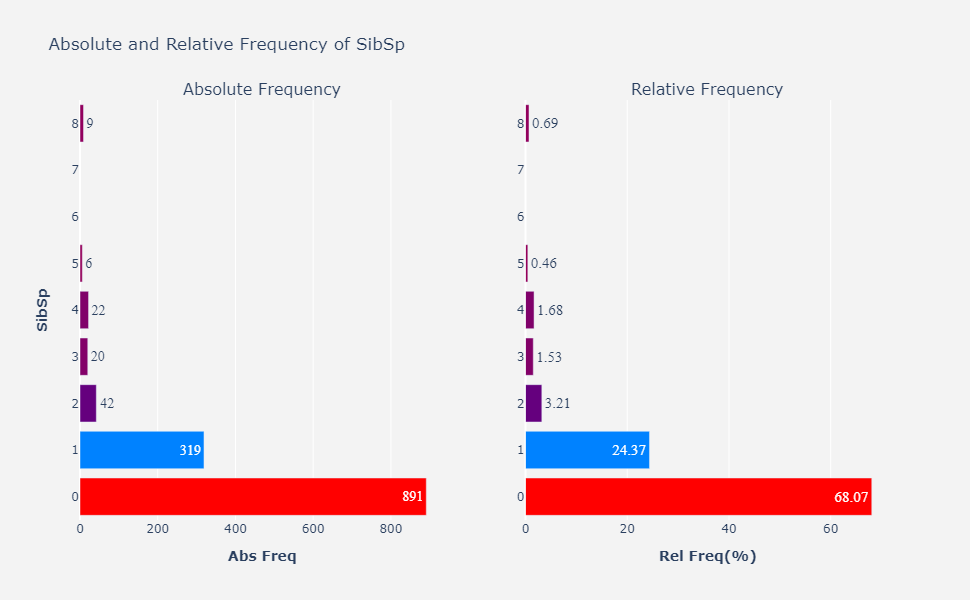

In [178]:
"""Построим график абсолютной и относительной частоты SibSp, чтобы исследовать его распределение."""
plotFrequency(merged.SibSp)

****Выводы:** SibSp не сбалансирован, так как уровни (7) неравномерно представлены в его распределении. 891 пассажира были без братьев, сестер или супругов. Иными словами, более 68 % пассажиров не имели на борту братьев, сестер или супругов, а более 24 % пассажиров имели 1 брата, сестру или супруга.

### 4.1.9 Parch(количество родителей/детей на борту)<a id="4.1.9"></a>

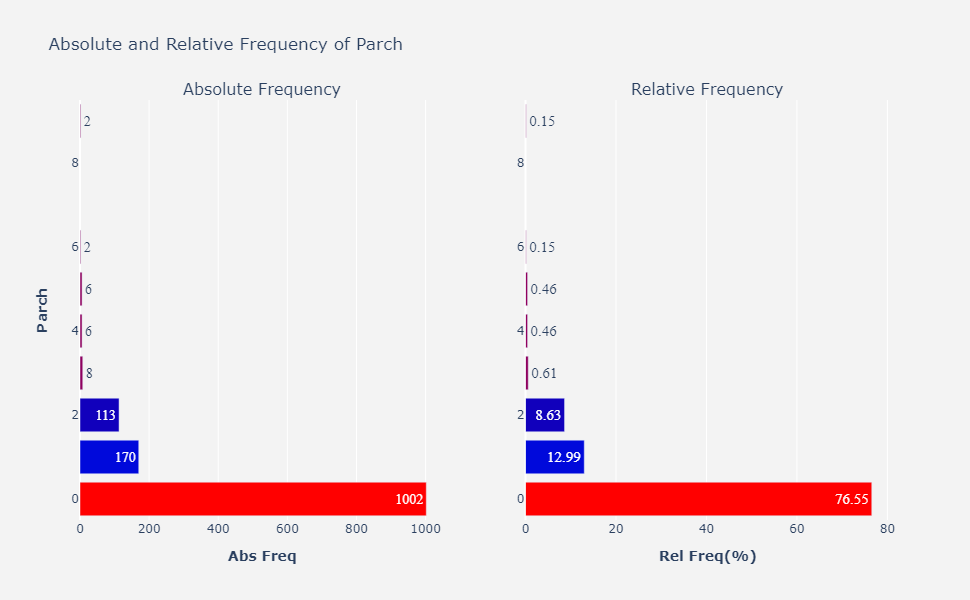

In [179]:
"""Абсолютная и относительная частота Parch."""
plotFrequency(merged.Parch)

****Выводы:** Parch не сбалансирован, так как уровни (8) неравномерно представлены в его распределении. Более тысячи пассажиров были без родителей или детей, за ними следовали 170 пассажиров с одним родителем или детьми. Другими словами, более 76,5 % пассажиров были без родителей или детей, в то время как у остальных 23,5 % было мало родителей или детей.
## 4.2 Числовые переменные<a id="4.2"></a>
Проанализируем числовые переменные, используя гистограмму, график плотности и сводную статистику. Для анализа числовых переменных мы создадим 2 пользовательские функции. 1-й построит гистограмму и график плотности для каждой числовой переменной. А 2-й будет вычислять сводную статистику, включая асимметрию.

In [180]:
"""#1. Создаём функцию для построения гистограммы и графика плотности."""
def plotHistogram(variable):
    """Строит гистограмму и график плотности переменной."""
    fig = make_subplots(
        rows=2,
        cols=1,
        print_grid=False,
    subplot_titles=(f"Distribution of {variable.name} with Histogram", f"Distribution of {variable.name} with Density Plot"))
    
    # Это гистограмма подсчета
    fig.add_trace(
        go.Histogram(
            x = variable,
            hoverinfo="x+y",
            marker = dict(color = "chocolate")
        ),
    row=1,col=1)
    
    # Это гистограмма плотности
    fig.add_trace(
        go.Histogram(
            x = variable,
            hoverinfo="x+y",
            histnorm = "density",
            marker = dict(color = "darkred")
        ),
    row=2,col=1)
    
    # Update layout
    fig.layout.update(
        height=800, 
        width=870,
        hovermode="closest",
        showlegend=False,
        paper_bgcolor="rgb(243, 243, 243)",
        plot_bgcolor="rgb(243, 243, 243)"
        )
    
    # Update axes
    fig.layout.yaxis1.update(title="<b>Abs Frequency</b>")
    fig.layout.yaxis2.update(title="<b>Density(%)</b>")
    fig.layout.xaxis2.update(title=f"<b>{variable.name}</b>")
    return fig.show()
    

    
'''#2.Calculate descriptive statistics.'''
def calculateSummaryStats(variable): #создадим функцию
    stats = variable.describe() #описательная статистика
    skewness = pd.Series(variable.skew(), index = ["skewness"]) #асимметрия
    statsDf = pd.DataFrame(pd.concat([skewness, stats], sort = False), columns = [variable.name]) 
#создадим датафрейм и объеденим stats и skewness
    statsDf = statsDf.reset_index().rename(columns={"index":"summaryStats"}) #заменим индексы с числовых на названия
    return display(statsDf.round(2)) #функция возращает значения с 2-мя знаками после запятой

### 4.2.1 Fare(сумма денег, потраченных на билет)<a id="4.2.1"></a>

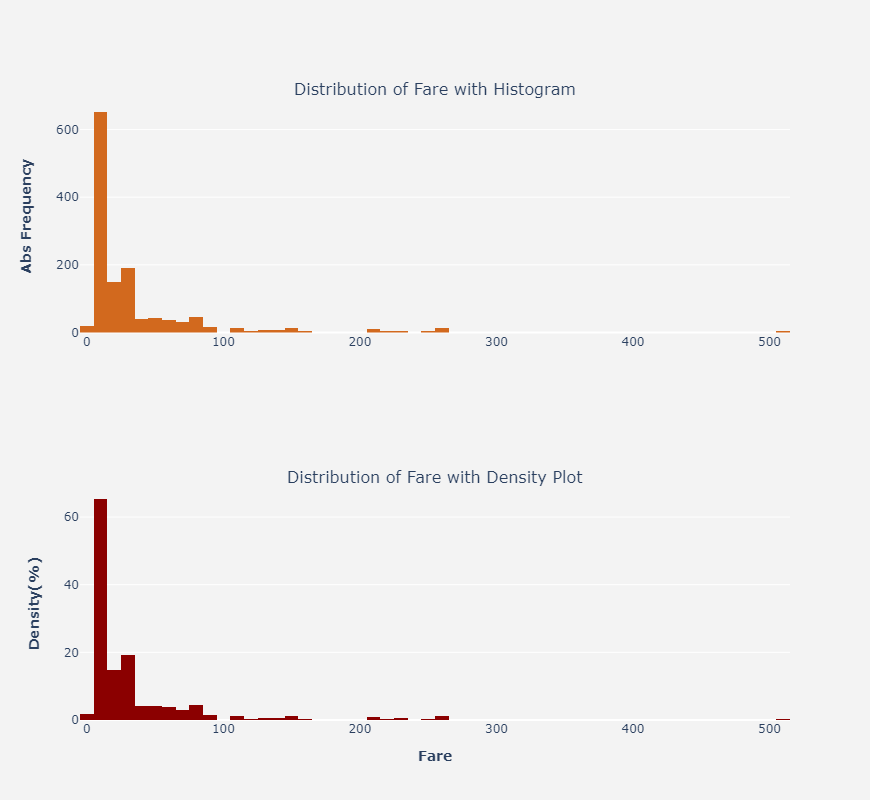

In [181]:
'''Построить гистограмму и график плотности Fare.'''
plotHistogram(merged.Fare)

**Читая гистограмму, становится ясно, что распределение тарифов имеет высокую положительную асимметрию. И, похоже, несколько пассажиров (653) заплатили за проезд от 5 до 15 (менее 15), а затем от 25 до 35 (менее 35).**

Существует также другой, часто более ясный способ понимания распределения: графики плотности или, более формально, графики плотности ядра. Их можно считать сглаженной версией гистограммы. Одним из преимуществ графика плотности перед гистограммой является то, что на его форму распределения не влияет количество используемых ячеек.

In [182]:
"""Статистика Fare."""
bold("Сводная статистика Fare:")
calculateSummaryStats(merged.Fare)

**Сводная статистика Fare:**

,summaryStats,Fare
0,skewness,4.37
1,count,1308.00
2,mean,33.30
3,std,51.76
4,min,0.00
5,25%,7.90
6,50%,14.45
7,75%,31.28
8,max,512.33


**Итак, о чем говорит значение асимметрии?**
1. Если асимметрия меньше -1 или больше +1, распределение можно считать сильно искаженным.
2. Если асимметрия находится между -1 и −½ или между +½ и +1, распределение можно считать умеренно асимметричным.
3. И, наконец, если асимметрия находится между −½ и +½, распределение можно считать приблизительно симметричным.    

**Выводы:** График плотности показывает, что масса распределения платы за проезд сильно сосредоточена в левой части рисунка из-за очень длинного хвоста с правой стороны. Таким образом, можно сказать, что стоимость проезда существенно искажена (положительно), что также подтверждается рассчитанным положительным значением асимметрии 4,37

### 4.2.2 Age(возраст)<a id="4.2.2"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



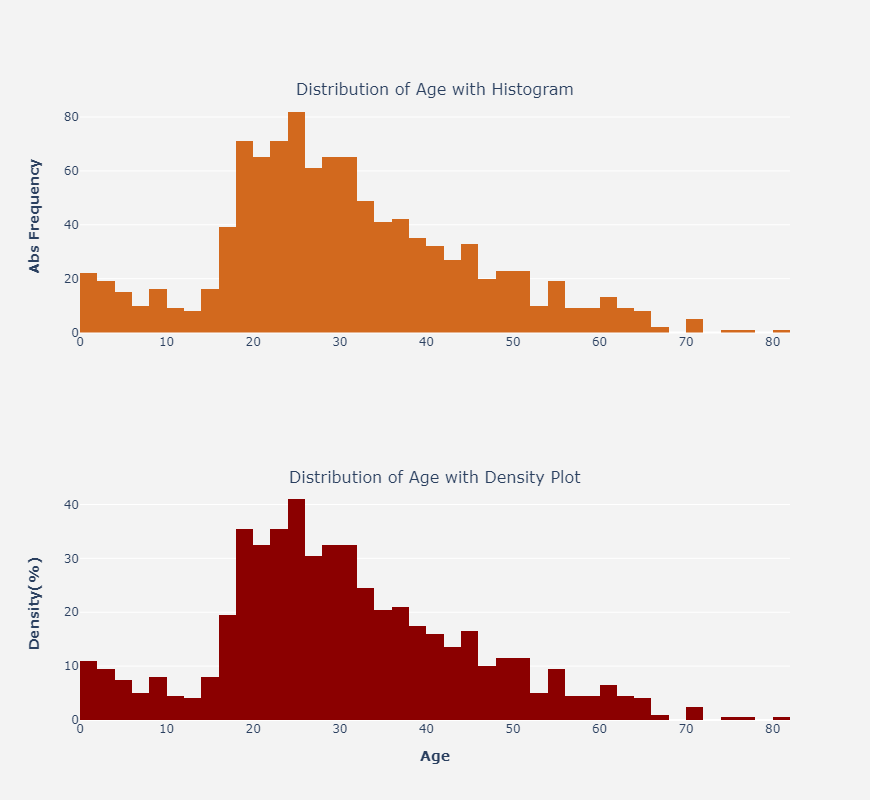

In [183]:
""""Построим гистограмму и график плотности Age."""
plotHistogram(merged.Age)

In [184]:
"""Статистика Age"""
calculateSummaryStats(merged.Age)

,summaryStats,Age
0,skewness,0.41
1,count,1046.00
2,mean,29.88
3,std,14.41
4,min,0.17
5,25%,21.00
6,50%,28.00
7,75%,39.00
8,max,80.00


**На первый взгляд, возраст кажется положительно искаженным (слегка). 344 пассажира в возрасте от 20 до 30 лет (менее 30 лет). А пассажиров в возрасте от 70 до 80 лет (включая 80) было 8, было меньше всего.**

**Выводы:** Что мы можем видеть из графика плотности, так это то, что масса распределения возраста немного сосредоточена слева от фигуры из-за сравнительно длинного хвоста с правой стороны. Таким образом, можно сказать, что возраст распределен почти нормально, так как хвост с обеих сторон почти одинаков и имеет небольшое значение положительной асимметрии 0,41 (в диапазоне от -0,5 до 0,5). Так что можно сказать, что Возраст распределен почти нормально.

### 4.2.3 PassengerId(идентификационный номер, присвоенный каждому пассажиру)<a id="4.2.3"></a>

In [185]:
"""Что содержит идентификатор пассажира?"""
display(merged.PassengerId.head())

0    1
1    2
2    3
3    4
4    5
Name: PassengerId, dtype: int64

**Выводы:** Сторона пассажира - это уникальный идентификационный номер (положительное целое число), присвоенный каждому пассажиру.

# 5.Разработка функций<a id="5"></a>
В этом разделе мы либо изменим, либо создадим новые функции из существующих функций, которые в противном случае трудно проанализировать в их необработанных формах, которые мы видели в разделе Одномерный анализ. Мы бы разработали такие функции, как Cabin, Name, SibSp & Parch и билет, которые могли бы рассказать нам что-то о выживании или смерти после их обработки.

## 5.1 Cabin(кабина)<a id="5.1"></a>

In [186]:
"""Посмотрим на Cabin снова."""
bold("Предварительный просмотр Cabin:")
display(merged.Cabin.head())

**Предварительный просмотр Cabin:**

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [187]:
"""Похоже, что Cabin содержит некоторые недостающие значения. Давайте их пересчитаем."""
bold("Недостающие значения в Cabin:")
display(merged.Cabin.isna().sum())

**Недостающие значения в Cabin:**

1014

In [188]:
"""Всего категорий Cabin, включая NaN"""
bold("Всего категорий Cabin, включая NaN:")
display(merged.Cabin.value_counts(dropna=False).count()) #value_counts(dropna=False)-мы видим значения NaN 

**Всего категорий Cabin, включая NaN:**

187

Похоже, что Cabin - это переменная буквенно-цифрового типа без специальных символов (например, ., /, % и т.д.) между буквами и цифрами. В ней также имеется 1014 недостающих наблюдений. Разумно предположить, что у этих NaN не было каюты, которая могла бы рассказать нам что-то о "Выживших". Мы пометим NaN "X" и сохраним только 1-й символ, где Cabin имеет буквенно-цифровые значения. Поскольку это категориальная переменная, мы должны уменьшить количество категорий для дальнейшего анализа. **Чтобы избежать изменчивости, мы не будем изменять состояние какой-либо переменной на месте, скорее мы создадим совершенно новую переменную.**

In [189]:
"""Меняем NaN на 'X'."""
nanReplaced= merged.Cabin.fillna("X")

In [190]:
"""Извлекаем из Cabin только 1-й символ, который является всего лишь буквой и вставляем его в датафрейм."""
merged["cabinProcessed"] = nanReplaced.str.get(0)  #оставляем названия данных лишь первой буквой
bold("Cabin после изменения:")
display(merged.cabinProcessed.value_counts())

**Cabin после изменения:**

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: cabinProcessed, dtype: int64

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



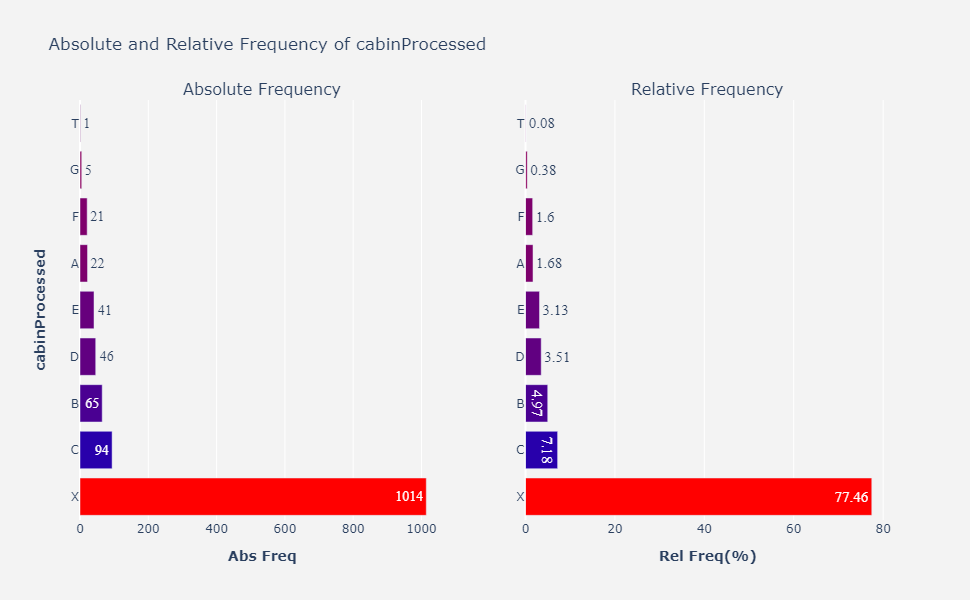

In [191]:
"""Визуальзиция Cabin после изменений"""
plotFrequency(merged.cabinProcessed)

**Результаты:** Похоже, что почти 77,5 % пассажиров имели категорию салона X (ранее NaN), затем более 7% имели категорию салона C и почти 5% имели категорию салона B.

## 5.2 Name(имя)<a id="5.2"></a>

In [192]:
"""Посмотрим что внутри Name."""
display(merged.Name.head(8))

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
Name: Name, dtype: object

Что мы можем легко понять из этого столбца, он содержит строки, которые дополнительно содержат такие названия, как Мистер, Миссис, Мастер и т.д. Эти названия дают нам некоторую полезную информацию о поле (Мистер = мужчина, Миссис = замужняя женщина), возрасте (мисс обычно моложе миссис) и профессии (Мастер указывает профессию и, следовательно, социальный статус) и т. Д., Что в конечном итоге может рассказать нам что-то большее о выживании. Теперь мы хотим извлечь эти названия из названия, чтобы проверить, есть ли какая-либо связь между этими названиями и сохранившимися.

In [193]:
firstName = merged.Name.str.split(".").str.get(0).str.split(",").str.get(-1) 
#.str.split(".")-создает массив, .str.get(0)-берет первый элемент массива, потом снова в массив, а потом берем последний элемент

In [194]:
"""Категории Name."""
display(firstName.value_counts())

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Rev               8
 Dr                8
 Col               4
 Ms                2
 Mlle              2
 Major             2
 the Countess      1
 Mme               1
 Dona              1
 Capt              1
 Sir               1
 Jonkheer          1
 Lady              1
 Don               1
Name: Name, dtype: int64

Мы видим, что есть несколько названий с наименьшей частотой. Поэтому имеет смысл поместить их в меньшее количество ведер. Такие профессионалы, как доктор, преподобный, полковник, майор, капитан, будут помещены в "Офицерское". Такие имена, как Дона, Джонхир, графиня, сэр, Леди, Дон, обычно давались аристократам, и поэтому эти имена будут помещены в графу "Аристократ". Мы также заменили бы Миллер и Мисс на Мисс, а Мадам на Миссис, поскольку это французские титулы.

In [195]:
"""Создаём Officer."""
firstName.replace(to_replace = ["Dr", "Rev", "Col", "Major", "Capt"], value = "Officer", inplace = True,regex=True)

"""Создаём Aristocrat."""
firstName.replace(to_replace = ["Dona", "Jonkheer", "Countess", "Sir", "Lady", "Don"], value = "Aristocrat", inplace = True,regex=True)

"""Переменовываем Ms и Mlle в Miss. И Mme в Mrs."""
firstName.replace({"Mlle":"Miss", "Ms":"Miss", "Mme":"Mrs"}, inplace = True,regex=True)
"""Переменовываем the Aristocrat на Aristocrat"""
firstName.replace({"the Aristocrat":"Aristocrat"}, inplace = True,regex=True)#regex=True-выражение будет являться строкой 
"""Добавляем полученные изменения в nameProcessed."""
merged["nameProcessed"] = firstName

In [196]:
"""let's see how nameProcessed looks now"""
display(merged.nameProcessed.value_counts())

 Mr            757
 Miss          264
 Mrs           198
 Master         61
 Officer        23
 Aristocrat      6
Name: nameProcessed, dtype: int64

In [197]:
merged

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabinProcessed,nameProcessed
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,X,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,X,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,X,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,X,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,C,Aristocrat
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,X,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,X,Mr


c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



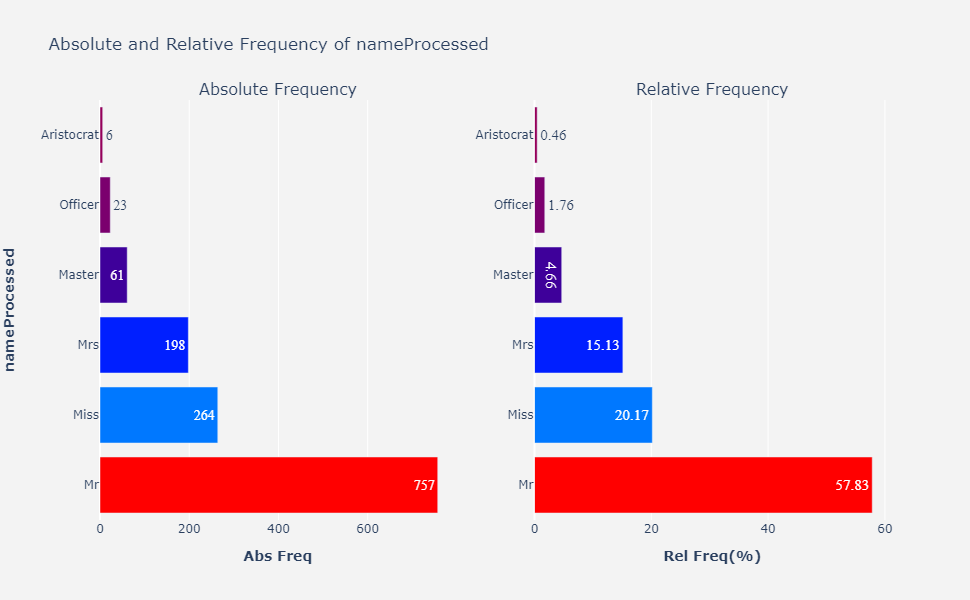

In [198]:
"""Визуальзация измененного Name."""
plotFrequency(merged.nameProcessed)

**Результаты:** Почти 58 % пассажиров имели титул Мистер (разумеется, мужчины), а затем почти 20 % пассажиров имели титулы Мисс (незамужние женщины, следовательно, обычно моложе миссис). Чуть более 15 % пассажиров были замужними женщинами (миссис).

## 5.3 SibSp & Parch<a id="5.3"></a>
При одномерном анализе мы увидели, что у некоторых пассажиров были братья и сестры/супруги, а у некоторых их не было. То же самое относится и к переменному шагу. Поскольку эти две переменные вместе указывают на размер семьи, мы бы создали новую переменную "размер семьи" из этих двух переменных.

In [199]:
"""Объеденим SibSp and Parch в Family_size."""
merged["familySize"] = merged.SibSp + merged.Parch + 1  # Adding 1 for single person
bold("Категории в Family_size:")
display(merged.familySize.value_counts())

**Категории в Family_size:**

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: familySize, dtype: int64

Мы видим, что существует несколько размеров семей с наименьшей частотой. Мы создадим 4 группы, а именно одиночное, маленькое, среднее и большое для остальных из них.

In [200]:
"""Создаём 4 группы single, small, medium, and large и помещаем в них соответсвующие значения."""
merged.familySize.replace(to_replace = [1], value = "single", inplace = True)
merged.familySize.replace(to_replace = [2,3], value = "small", inplace = True)
merged.familySize.replace(to_replace = [4,5], value = "medium", inplace = True)
merged.familySize.replace(to_replace = [6, 7, 8, 11], value = "large", inplace = True)

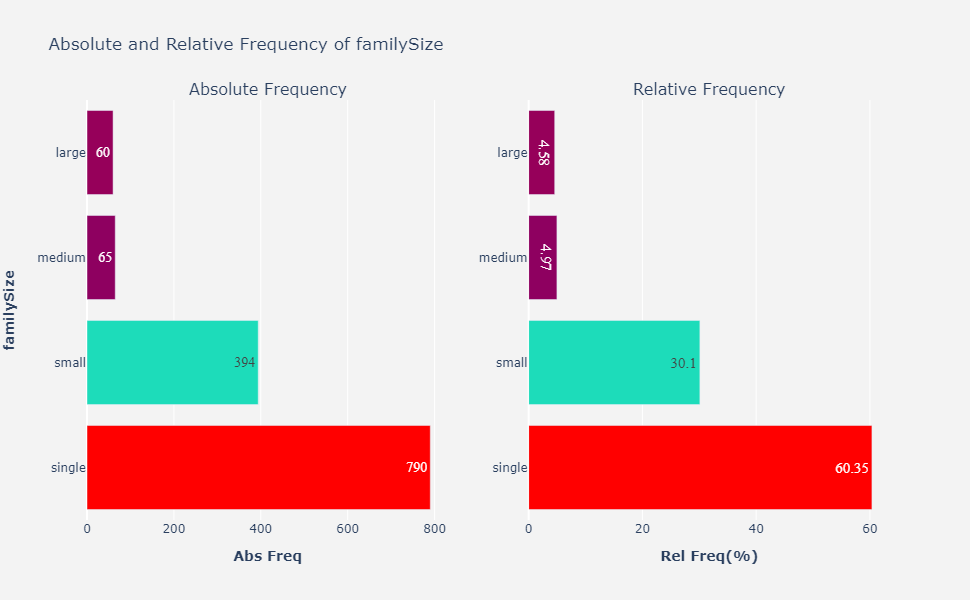

In [201]:
"""Визуальизация familySize."""
plotFrequency(merged.familySize)

**Выводы:** Похоже, что большинство пассажиров (более 60 %) были одиноки (без семьи), за которыми следовали 30 % пассажиров с небольшой семьей. Почти 5 % пассажиров имели средние семьи, и чуть более 4,5 % пассажиров имели большие семьи.

## 5.4 Ticket(билет)<a id="5.4"></a>

In [202]:
"""Посмотрим на Ticket"""
display(merged.Ticket.head())

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

Билет также является переменной буквенно-цифрового типа. Мы создадим две группы - одна будет содержать только число, а другая будет содержать только символ, извлеченный из строки. Если строка содержит как символ, так и число, мы сохраним только символ.

In [203]:
"""Назначаем "N", если в билете есть только цифры. В противном случае будем получать 1-й символ из билета."""
otherwise = merged.Ticket.str.split(" ").str.get(0).str.get(0) 
merged["ticketProcessed"] = np.where(merged.Ticket.str.isdigit(), "N", otherwise)
#.isdigit - проверяет, все ли символы в каждой строке являются цифрами
#np.where - https://numpy.org/doc/stable/reference/generated/numpy.where.html 'Где True, выход x, в противном случае выход y.'
#otherwise - иначе

In [204]:
"""Now calculate the categories in the ticketProcessed column."""
bold("Ticket after Processing:")
display(merged.ticketProcessed.value_counts())

**Ticket after Processing:**

N    957
S     98
P     98
C     77
A     42
W     19
F     13
L      5
Name: ticketProcessed, dtype: int64

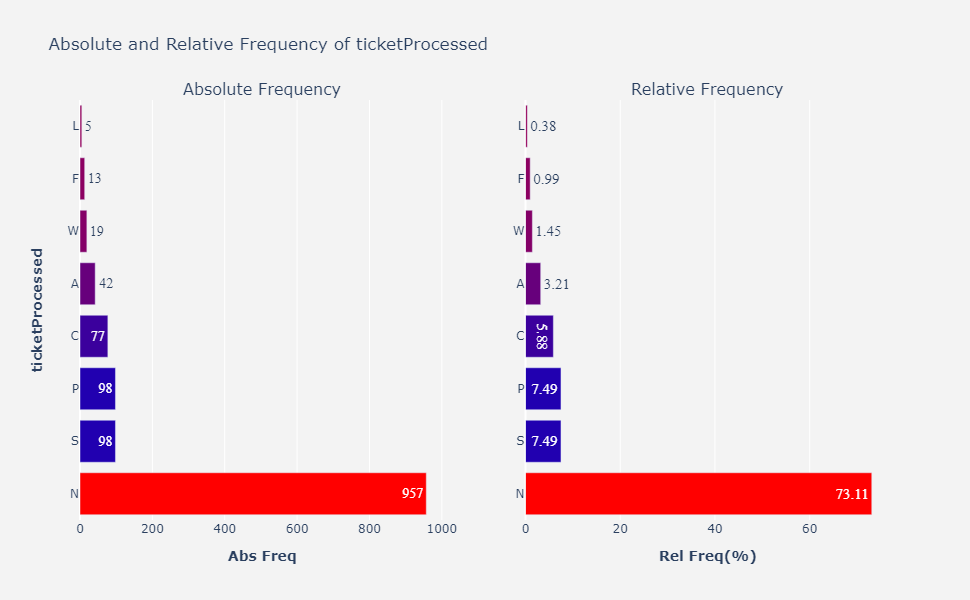

In [205]:
"""Визуальзация после изменения Ticket."""
plotFrequency(merged.ticketProcessed)

**Результаты:** Более 73 % пассажиров имели билеты категории N, за которыми следовали почти 7,5 % пассажиров, категории билетов были S и P. Пассажиров с категорией билетов W было всего 1,45 %.

# 6.Обнаружение выбросов<a id="6"></a>
**Как выбросы влияют на распределение:** Если значение переменной значительно превышает ожидаемый диапазон, это приведет к перемещению распределения вправо, что приведет к смещению графика вправо или положительному смещению. В качестве альтернативы, если значение значительно ниже ожидаемого диапазона, оно переместит распределение влево, сделав график смещенным влево или с отрицательным наклоном.

Еще один полезный график для визуализации непрерывной переменной - это box plot. Box plot особенно полезна для понимания распространения непрерывных данных и наличия потенциальных необычных наблюдений (выбросов) в этой переменной. В нем представлена информация о минимальном, 1-м квартиле, 2-м квартиле (медиане), 3-м квартиле и максимуме переменной.**Мы будем использовать метод IQR для обнаружения выбросов для переменного Age и Fare , хотя мы не будем их удалять.**

In [206]:
"""#1.Создаем функцию, которая удаляет выбросы"""
def removeOutliers(variable):
    """Вычисляет и удаляет выбросы с помощью метода IQR"""
    
    # зададим 1 и 3 квантиль
    q1, q3 = variable.quantile(0.25), variable.quantile(0.75)
    iqr = q3 - q1
    
    # Рассчитаем нижнее и верхнее пороговые значения для выбросов 
    lowerFence, upperFence = q1-1.5*iqr, q3+1.5*iqr   # Any values less than l_fence and greater than u_fence are outliers.
    
    # Наблюдения, которые являются выбросами
    outliers = variable[(variable<lowerFence) | (variable>upperFence)]
    
    # удаляем выбросы
    filtered = variable.drop(outliers.index, axis = 0).reset_index(drop=True)
    return filtered


"""2.Создайте другую функцию для построения boxplot с выбросами и без них."""
def plotBoxPlot(variable,filteredVariable):

    
    # Создаем объект подзаголовка
    fig = make_subplots(
        rows=2,
        cols=1,
        print_grid=False,
    subplot_titles=(f"{variable.name} Distribution with Outliers", f"{variable.name} Distribution without Outliers"))
    
    # Строит boxplot с выбросами
    fig.add_trace(
        go.Box(
            x = variable,
            name = "", # This removes trace 0
            marker = dict(color="darkred")
        ),
    row=1,col=1)
    
    # Строит boxplot с выбросами
    fig.add_trace(
        go.Box(
            x = filteredVariable,
            name = "",
            marker = dict(color="green")
        ),
    row=2,col=1)
    
    
    fig.layout.update(
        height=800, 
        width=870,
        showlegend=False,
        paper_bgcolor="rgb(243, 243, 243)",
        plot_bgcolor="rgb(243, 243, 243)"
        )
    
    
    fig.layout.xaxis2.update(title=f"<b>{variable.name}</b>")
    return fig.show()

## 6.1 Обнаружение выбросов для Age<a id="6.1"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



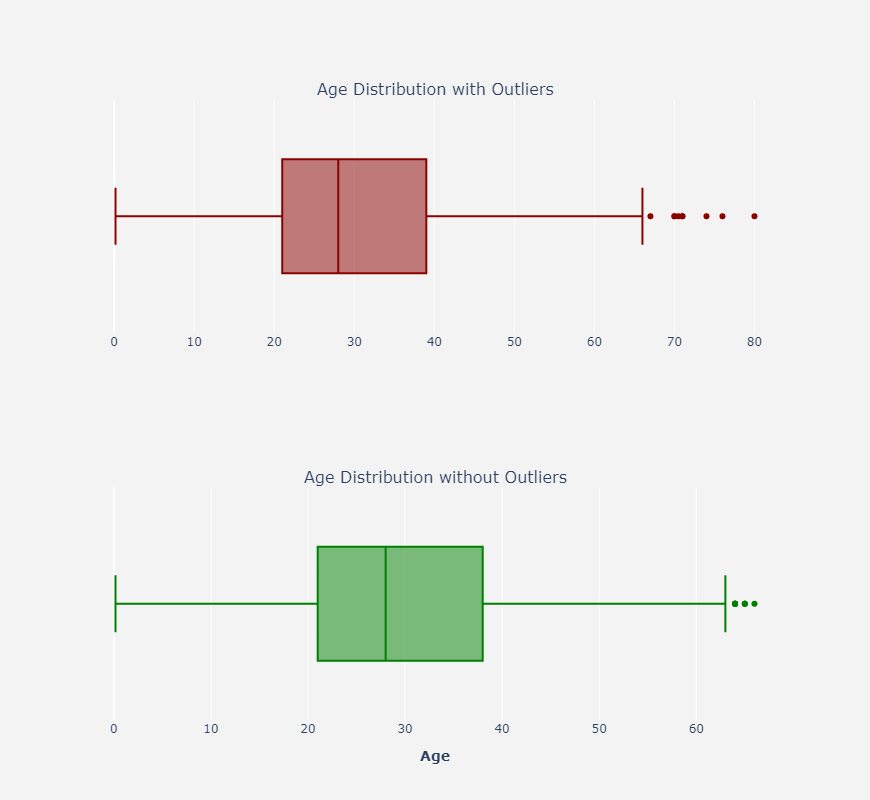

In [207]:
"""Plot Age with and without outliers."""
plotBoxPlot(merged.Age,removeOutliers(merged.Age))

**Для boxplot, если более длинная часть прямоугольника находится справа (или выше) от медианы, данные, как говорят, смещены вправо. Если более длинная часть находится слева (или ниже) от медианы, данные смещены влево. В нашем случае большая часть boxplot находится справа от медианы**

## 6.2 Обнаружение выбросов для Fare<a id="6.2"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



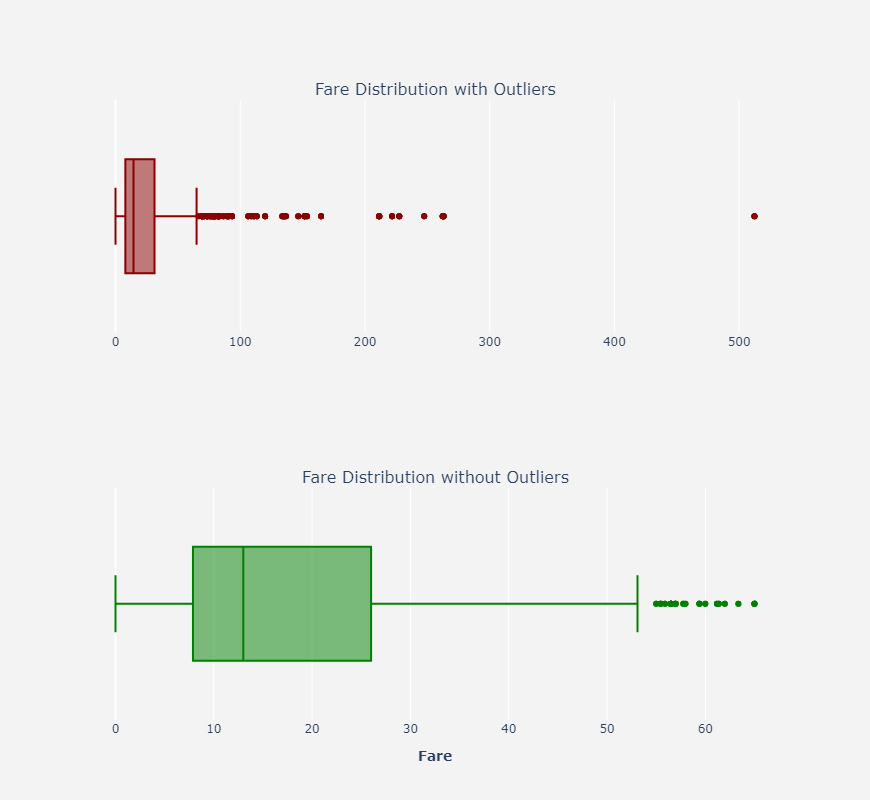

In [208]:
"""Plot Fare with and without outliers."""
plotBoxPlot(merged.Fare,removeOutliers(merged.Fare))

# 7.Заменяем отсутствующие переменные<a id="7"></a>
Самый простой способ заменить пропущенные значения переменной - это заменить ее пропущенные значения на ее среднее, медиану или моду в зависимости от ее распределения и типа переменной (категориальный или числовой). К настоящему времени у нас должно быть хорошее представление о распределении переменных и наличии выбросов в этих переменных. Для категориальных переменных выполняется мода, а для средней числовой переменной - замена, если ее распределение симметрично (или почти симметрично или нормально, как возраст). С другой стороны, для переменной с асимметричным распределением и выбросами (например, тарифом) рекомендуется замена на медиану, поскольку медиана более устойчива к выбросам, чем среднее значение. 

Однако одним из явных недостатков использования среднего, медианы или моды для замены пропущенных значений является добавление смещения, если количество пропущенных значений значительно (например, возраст). Поэтому простая замена их средним или средним возрастом может быть не лучшим решением, поскольку возраст может отличаться в зависимости от групп и категорий пассажиров.

Чтобы решить эту проблему, мы можем сгруппировать наши данные по некоторым переменным, у которых нет пропущенных значений, и для каждого подмножества вычислить средний возраст, чтобы приписать пропущенные значения. Или мы можем построить модель линейной регрессии, которая будет предсказывать пропущенные значения возраста, используя функции, у которых нет пропущенных значений. Эти два метода могут привести к повышению точности без большого смещения, если только не ожидается, что пропущенное значение будет иметь очень высокую дисперсию. Мы покажем первый метод замены.

In [209]:
"""#1. Создаем функцию для вычисления пропущенных значений"""
def calculateMissingValues(variable):
    """Вычисляем пропущенные значения переменной."""
    
    return merged.isna().sum()[merged.isna().sum()>0] # Возвращает только столбцы с пропущенными значениями



""""#2.Создайте функцию для построения точечной диаграммы"""
def plotScatterPlot(x, y, title, yaxis):
    trace = go.Scatter(
    x = x,
    y = y,
    mode = "markers",
    marker = dict(color = y, size = 35, showscale = True, colorscale = "Rainbow"))
    layout = go.Layout(hovermode= "closest",
                       title = title,
                       yaxis = dict(title = yaxis),
                       height=600,
                       width=900,
                       showlegend=False,
                        paper_bgcolor="rgb(243, 243, 243)",
                        plot_bgcolor="rgb(243, 243, 243)"
                      )
    fig = go.Figure(data = [trace], layout = layout)
    return fig.show()      

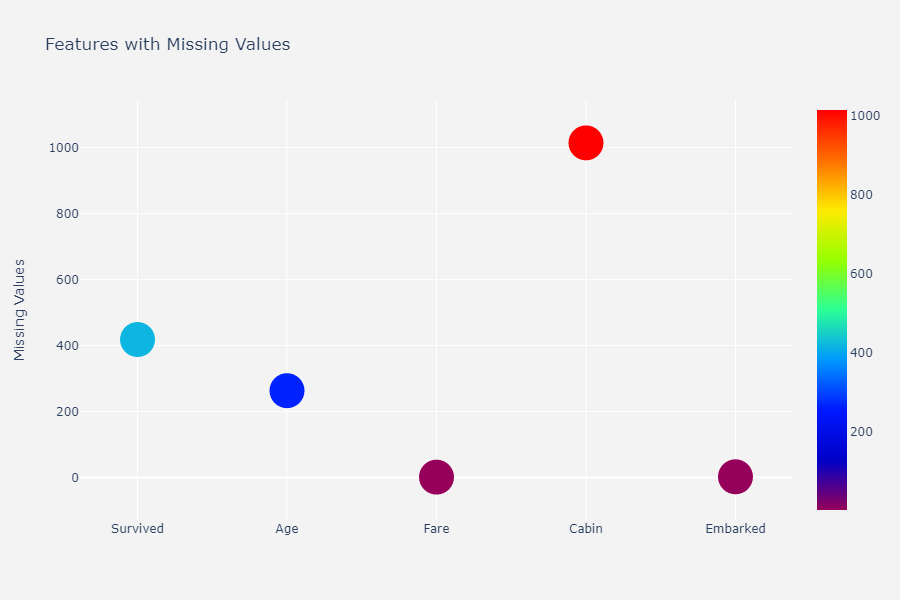

In [210]:
"""Переменные с соответствующими пропущенными значениями."""
plotScatterPlot(calculateMissingValues(merged).index,
               calculateMissingValues(merged),
               "Features with Missing Values",
               "Missing Values")

**Выводы:** 
1. Age  имеет 263 пропущенных значения.
2. Fare  имеет только 1.
3. Cabin  имеет колоссальные 1014 недостающих значений.
4. Embarked  всего 2 пропущенных значения.
5. **Survived  имеет недостающие значения (из-за объединения train и test), которые мы могли бы предсказать, изучая набор данных поезда.**

**У нас всего 1309 наблюдений, за исключением выживших переменных.**

## 7.1 Замена значений Embarked & Fare<a id="7.1"></a>

In [211]:
"""Embarked это категориальная переменная, где S является наиболее частой."""
merged.Embarked.fillna(value="S", inplace = True)

"""Fare - это числовая переменная с выбросами. Следовательно, это будет заменена медианой."""
merged.Fare.fillna(value=merged.Fare.median(), inplace = True)

## 7.2 Замена значений Age<a id="7.2"></a>
Давайте выясним, какие переменные коррелируют с возрастом.

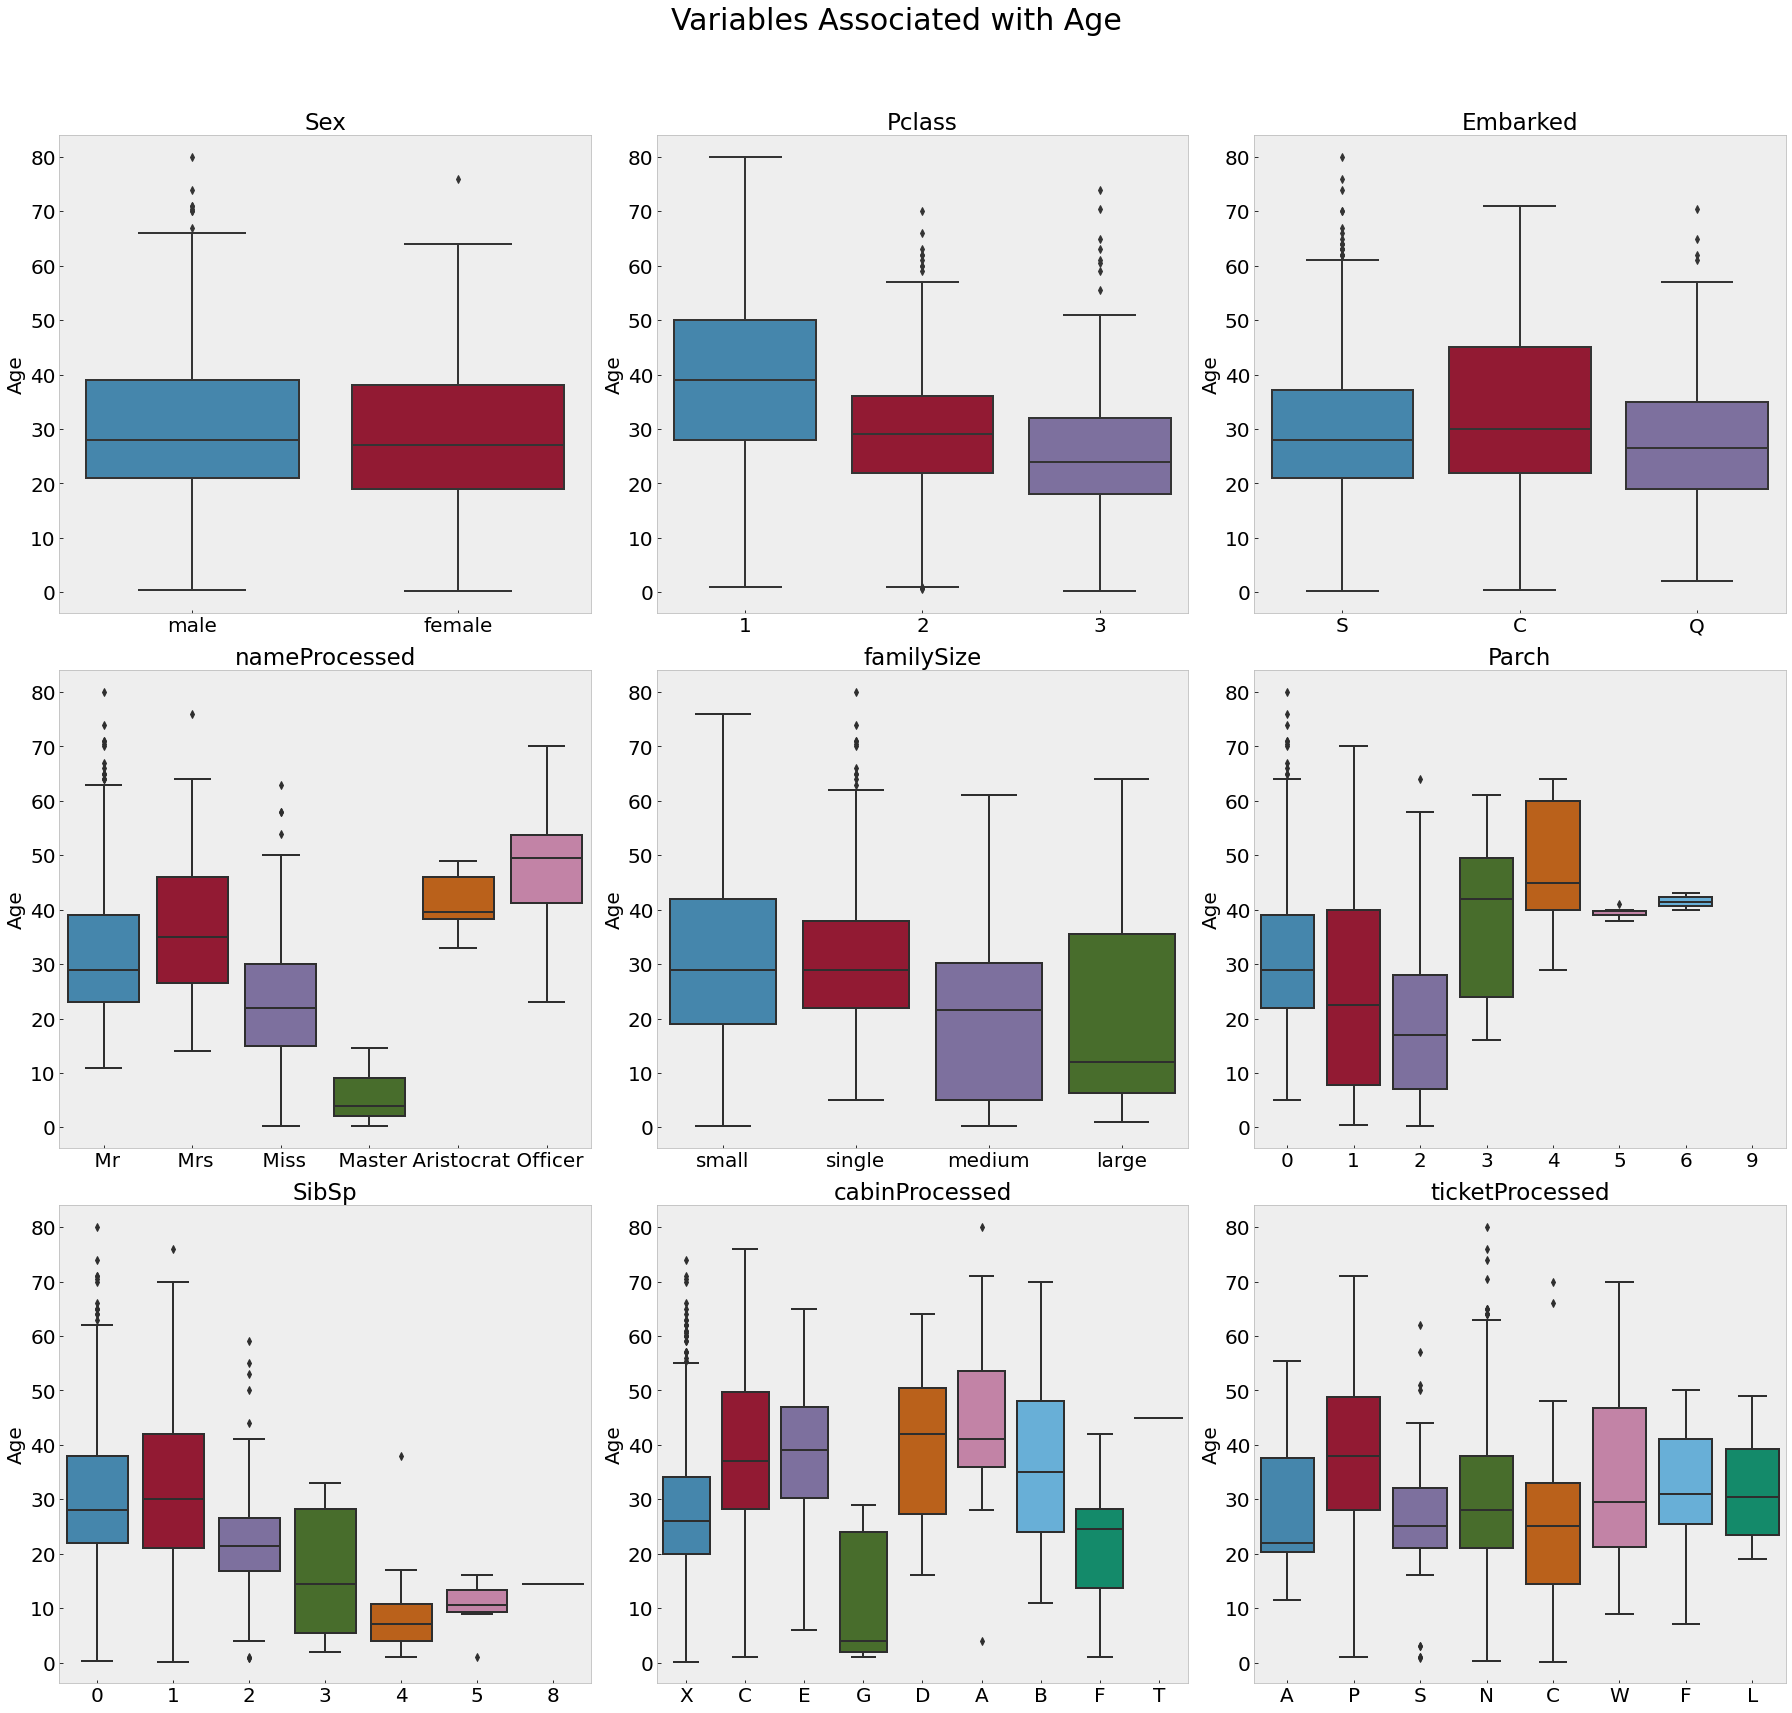

In [212]:
"""Создайте boxplot для просмотра переменных, коррелирующих с возрастом. Сначала извлечем переменные, которые нас интересуют."""
toSearch = merged.loc[:, ["Sex", "Pclass", "Embarked", "nameProcessed", "familySize", "Parch", 
                             "SibSp", "cabinProcessed", "ticketProcessed"]]

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (25,25))
for ax, column in zip(axes.flatten(), toSearch.columns):
    sns.boxplot(x = toSearch[column], y = merged.Age, ax = ax)
    ax.set_title(column, fontsize = 23)
    ax.tick_params(axis = "both", which = "major", labelsize = 20)
    ax.tick_params(axis = "both", which = "minor", labelsize = 20)
    ax.set_ylabel("Age", fontsize = 20)
    ax.set_xlabel("")
fig.suptitle("Variables Associated with Age", fontsize = 30)
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

**Выводы:** 
Распределение по возрасту, по-видимому, различно в разных категориях для nameProcessed, familySize, SibSp, Parch и  cabinProcessed. Так что они также могут быть хорошими предсказателями возраста.

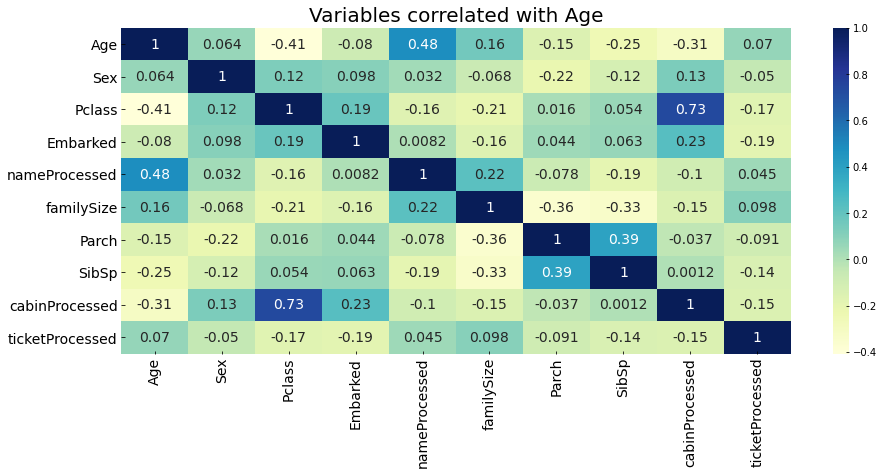

In [213]:
"""Давайте построим тепловую карту корреляции, чтобы увидеть, какая переменная сильно коррелирует с возрастом и верна ли наша
интерпретация boxplot . Нам нужно преобразовать категориальную переменную в числовую, чтобы построить
корреляционную тепловую карту. Поэтому преобразуйте категориальные переменные в числовые"""
from sklearn.preprocessing import LabelEncoder
toSearch = toSearch.agg(LabelEncoder().fit_transform)
toSearch["Age"] = merged.Age # Inserting Age in dataframe "toSearch".
toSearch = toSearch.set_index("Age").reset_index() # Move Age column at index 0.

# Now create the correlation heatmap
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
sns.heatmap(toSearch.corr(), cmap ="YlGnBu", annot=True, annot_kws={"size":14}, ax=ax)
ax.set_title("Variables correlated with Age", fontsize = 20)
ax.tick_params(axis = "both", which = "major", labelsize = 14)
ax.tick_params(axis = "both", which = "minor", labelsize = 14)
plt.show()

**Выводы:**  Как и ожидалось, Sex, Embarked и ticketProcessed имеют самую слабую корреляцию с возрастом. Parch и familySize умеренно коррелируют с возрастом. nameProcessed, Pclass, Cabin и SibSp имеют самую высокую корреляцию с возрастом. Но мы будем использовать nameProcessed и Pclass только для того, чтобы определить Age, поскольку они имеют самую сильную корреляцию с возрастом. Таким образом, тактика состоит в том, чтобы сопоставить отсутствующие значения возраста со средним возрастом аналогичных строк в соответствии с обработанным именем и классом P.

In [214]:
"""Замена пропущенных Age с медианой соответствующих столбцов (т. Е. nameProcessed and Pclass)."""
merged.Age = merged.groupby(["nameProcessed", "Pclass"])["Age"].transform(lambda x: x.fillna(x.median()))

bold("Пропущенные значения после изменения:")
display(merged.isnull().sum())

**Пропущенные значения после изменения:**

PassengerId           0
Survived            418
Pclass                0
Name                  0
Sex                   0
Age                   0
SibSp                 0
Parch                 0
Ticket                0
Fare                  0
Cabin              1014
Embarked              0
cabinProcessed        0
nameProcessed         0
familySize            0
ticketProcessed       0
dtype: int64

# 8.Двумерный Анализ<a id="8"></a>
Двумерный анализ пытается найти взаимосвязь между двумя переменными. Мы будем искать корреляцию или связь между нашими предикторными и целевыми переменными. Двумерный анализ выполняется для любой комбинации категориальных и числовых переменных. Комбинация может быть: Числовой и Числовой, Числовой и Категориальный, Категориальный и Категориальный. Для решения этих комбинаций в процессе анализа используются различные методы. Методы заключаются в следующем:
1. Числовые и числовые: корреляция Пирсона или корреляция Спирмена (последнее не требует нормального распределения).
2. Числовой и категориальный: Точечная бисериальная корреляция (только если категориальная переменная двоичного типа) или тест ANOVA. Для этой проблемы вы можете использовать либо бисериальную корреляцию, либо ANOVA. Но я выполню оба теста, просто чтобы узнать, потому что ANOVA пригодится, если категориальная переменная имеет более двух классов.
3. Категориальный и категориальный: Мы бы использовали критерий Хи-квадрат для двумерного анализа между категориальными переменными.

## 8.1 Числовые & Категориальные переменные<a id="8.1"></a>
Сначала мы создаем boxplot между нашими числовыми и категориальными переменными, чтобы проверить, отличается ли распределение числовой переменной в разных классах номинальных переменных. Затем мы находим среднее значение числовой переменной для каждого класса категориальной переменной. Снова мы строим гистограмму числовой переменной для каждого класса категориальной переменной. Наконец, для нахождения связи между номинальными и числовыми переменными вычисляется двузначная корреляция anova или точечная двузначная корреляция (в случае двух категориальных переменных класса).

In [215]:
"""Давайте разделим обучающие и тестовые данные для двумерного анализа"""
df_train = merged.iloc[:891, :]
df_test = merged.iloc[891:, :]
df_test = df_test.drop(columns = ["Survived"], axis = 1)

"""1.Создаем функцию, которая создает boxplot между категориальными и числовыми переменными и вычисляет двузначную корреляцию."""
def boxplotAndCorrelation(numVariable,catVariable=df_train.Survived):
    
    # Вычисляет точечную бисериальную корреляцию и значение p
    biserialCorr = stats.pointbiserialr(numVariable,catVariable)[0].round(2)
    pValue = stats.pointbiserialr(numVariable,catVariable)[1].round(5)
    
    fig = make_subplots(
        rows=1,
        cols=1,
        print_grid=False,
    )
    
    # отображает прямоугольную диаграмму категориальной переменной и числовой переменной
    fig.add_trace(
        go.Box(
            x = catVariable,
            y = numVariable,
            marker_color="lightseagreen",
            ))
    
    
   
    fig.layout.update(
        height=500, 
        width=900,
        showlegend=False,
        title_text= f"Association between {catVariable.name} and {numVariable.name} (corr: {biserialCorr}, p: {pValue})",
        paper_bgcolor="rgb(243, 243, 243)",
        plot_bgcolor="rgb(243, 243, 243)"
        )
    
    
    fig.layout.xaxis1.update(title=f"<b>{catVariable.name}</b>")
    fig.layout.yaxis1.update(title=f"<b>{numVariable.name}</b>")
    return fig.show()


"""2. Создайте другую функцию для вычисления среднего значения при группировании по категориальной переменной"""
def numGroupedByCat(numVariable,catVariable=df_train.Survived):
    """Возвращает barplot, показывающий среднее значение числовой переменной по классу категориальной переменной."""
    
    # Вычисляет среднее значение для разных классов категориальной переменной
    numGroupedByCat = numVariable.groupby(catVariable).mean().round(2)
    
    
    fig = make_subplots(
        rows=1,
        cols=1,
        print_grid=False,
    )
    
    
    fig.add_trace(
        go.Bar(
            x = numGroupedByCat.index,
            y = numGroupedByCat,
            text=numGroupedByCat,
            hoverinfo="x+y",
            textposition="auto",
            textfont=dict(family="sans serif",size=15)
        ))
    
    
    fig.layout.update(
        height=500, 
        width=900,
        showlegend=False,
        title_text= f"Mean {numVariable.name} across {catVariable.name}",
        paper_bgcolor="rgb(243, 243, 243)",
        plot_bgcolor="rgb(243, 243, 243)"
        )
    
    
    fig.layout.xaxis1.update(title=f"<b>{catVariable.name}</b>")
    fig.layout.yaxis1.update(title=f"<b>Mean {numVariable.name}</b>")
    return fig.show()

    
"""3. Эта функция строит гистограмму числовой переменной для каждого класса категориальной переменной."""
def numHistByCat(numVariable,catVariable=df_train.Survived):
    """Возвращает числовое распределение переменных по классам категориальной переменной."""
    fig,ax = plt.subplots(1,1,figsize = (18,7))
    font_size = 15
    title_size = 18
    numVariable[catVariable==1].hist(bins=50,color="green", label = "survived", grid = False, alpha=0.5)
    numVariable[catVariable==0].hist(bins=50,color="red", label = "died", grid = False, alpha=0.5)
    ax.set_yticks([])
    ax.tick_params(axis="x", labelsize=font_size)
    ax.set_xlabel(f"{numVariable.name}", fontsize = font_size)
    ax.set_title(f"{numVariable.name} Distribution of Survivors vs Victims", fontsize = title_size)
    plt.legend()
    return plt.show()

   
"""#4. Создает функцию для вычисления anova между числовой и категориальной переменной."""
def calculateAnova(numVariable, catVariable=df_train.Survived):
    """Возвращает статистику f и значение p после вычисления anova."""
    
    groupNumVariableByCatVariable1 = numVariable[catVariable==1] # Group our numerical variable by categorical variable(1). Group Fair by survivors
    groupNumVariableByCatVariable0 = numVariable[catVariable==0] # Group our numerical variable by categorical variable(0). Group Fare by victims
    fValue, pValue = stats.f_oneway(groupNumVariableByCatVariable1, groupNumVariableByCatVariable0) # Calculate f statistics and p value
    return f"Anova Result between {numVariable.name} & {catVariable.name}: f=> {fValue}, p=> {pValue}"

### 8.1.1 Fare & Survived <a id="8.1.1"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



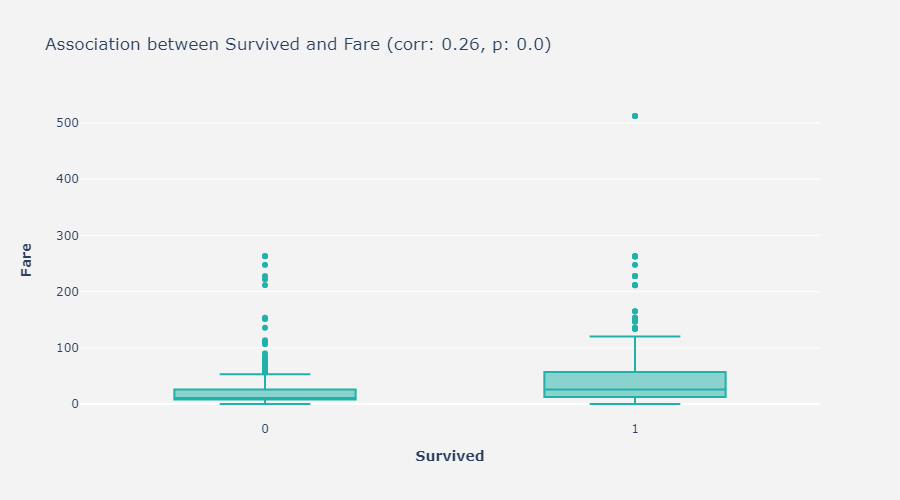

In [216]:
"""Create a boxplot to visualize the strength of association of Survived with Fare. Also calculate biserial correlation."""
boxplotAndCorrelation(df_train.Fare)

**Результаты:** Распределение платы за проезд между различными категориями выживших (0 и 1) различно (по крайней мере, перекрывается), что делает его сравнительно сильным предиктором для выживших, что в некотором роде верно, исходя из значения корреляции 0,257307 и значения p (менее 0,01), что говорит о том, что мы на 99 % уверены в том, что эта корреляция статистически значима. Кроме того, выживание положительно коррелирует с тарифом, поэтому чем больше вы платите за проезд, тем больше у вас шансов выжить, что совершенно очевидно из графика box plot.

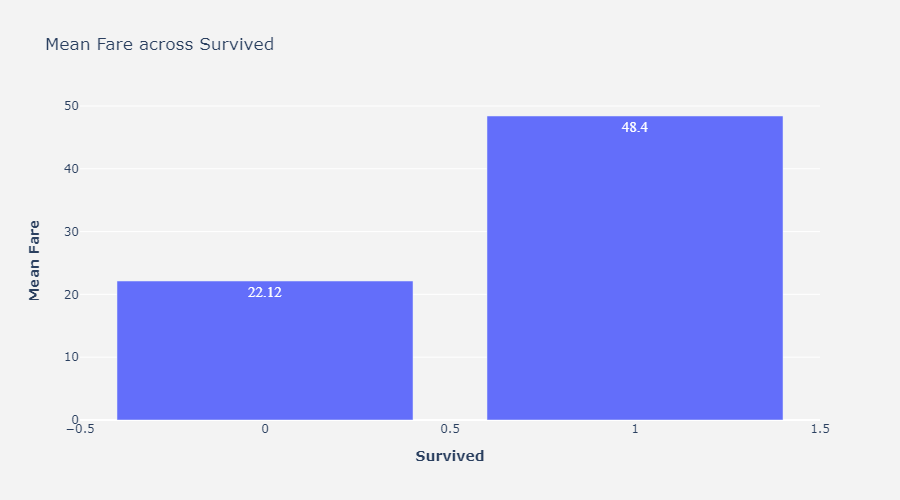

In [217]:
"""So the mean fare of survivors should be much more (from positive correlation or boxplot interpretation) than those who died. Calculate mean fare paid by the survivors as well as by the victims."""
numGroupedByCat(df_train.Fare)

**Похоже, что в среднем, если вы заплатите больше за свой билет, у вас больше шансов выжить. Давайте построим гистограмму выживших и жертв вместе, чтобы подтвердить нашу интуицию:**

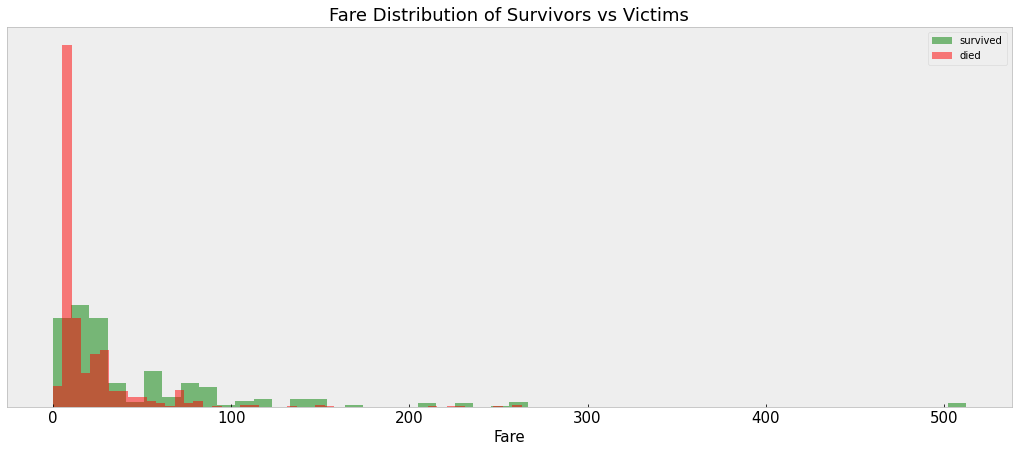

In [218]:
"""Plot histogram of survivor's vs victims fare."""
numHistByCat(df_train.Fare)

**Это правда. Пассажиры, которые заплатили больше, в основном выжили.**

**АНОВА:**
Тест ANOVA (дисперсионный анализ) позволяет нам проверить, изменяется ли числовая переменная ответа в зависимости от уровней (или класса) категориальной переменной. Когда мы просто ссылаемся на "ANOVA", мы обычно имеем в виду "односторонний" ANOVA, который является тестом для изучения влияния одного фактора на три или более групп (но также подойдут две группы, как мы объясним ниже).

Хотя для этой задачи следует использовать либо точечную бисериальную корреляцию (если категориальная переменная имеет двоичный тип), либо метод ANOVA, чтобы найти какую-либо связь между категориальной и числовой переменной, я бы тоже выполнил ANOVA, чтобы иметь представление о том, как работает ANOVA. Хотя ANOVA обычно предпочтительнее, если категориальная переменная имеет более двух групп, также можно выполнить ANOVA для категориальной переменной с двумя группами.

Односторонний ANOVA проверяет, отличается ли среднее значение некоторой числовой переменной на уровнях одной категориальной переменной. Это, по сути, отвечает на вопрос: отличаются ли какие-либо из групповых средств друг от друга? Нулевая гипотеза состоит в том, что все групповые средние равны. И альтернативная гипотеза заключается в том, что любые из групповых средств отличаются друг от друга.

In [219]:
"""Let's perform ANOVA between Fare and Survived. One can omit this step. I perform just to show how anova is performed if there were more than two groups in our categorical variable."""
calculateAnova(df_train.Fare)

'Anova Result between Fare & Survived: f=> 63.03076422804448, p=> 6.120189341921873e-15'

**Интерпретация результата ANOVA:**
При р <0,05 мы утверждаем, что у нас есть основной эффект взаимодействия. Это просто означает, что среди групп, по крайней мере, любая из групп (или групп) статистически значимо отличается друг от друга (верно только для более чем двух групп). Однако этот результат не идентифицирует выборочную пару (или пары), которые вызывают это значение (опять же верно для более чем двух групп категориальных переменных, но у нас есть только две группы.. т. Е. 0 и 1).
Итак, когда ANOVA сообщает об "эффекте взаимодействия", нам необходимо дополнительно идентифицировать пары групп, применяя парные элементы управления (требуется для более чем двух групп категориальных переменных). Хотя эти средства контроля можно было бы осуществить с помощью обычного t-теста, но это неправильный подход. Таким образом, post hoc-тест (обычно тест Тьюки) выполняется, чтобы найти пару или пары, которые вызывают разницу. Хотя тест Тьюки не требуется с категориальной переменной менее трех групп.

***Примечание: *** Тест Тьюки не требуется, если ANOVA дает значение p больше 0,05, а номинальная переменная имеет менее трех групп.


### 8.1.2 Age & Survived <a id="8.1.2"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



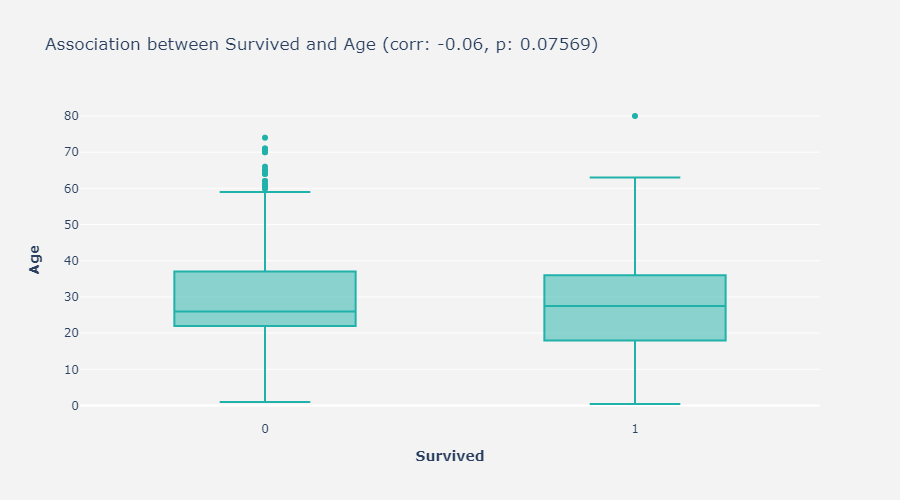

In [220]:
boxplotAndCorrelation(df_train.Age)

**Выводы:** Box plot показывает, что распределение возраста между категориями выживших (1 и 0) имеет значительное перекрытие, что также отчасти верно при небольшом значении корреляции -0,05939. А значение p, превышающее 0,05, указывает на отсутствие доказательств того, что корреляция является статистически значимой. Как мы видим, выживаемость обратно пропорциональна возрасту, поэтому, если вы моложе, вы, скорее всего, выживете.

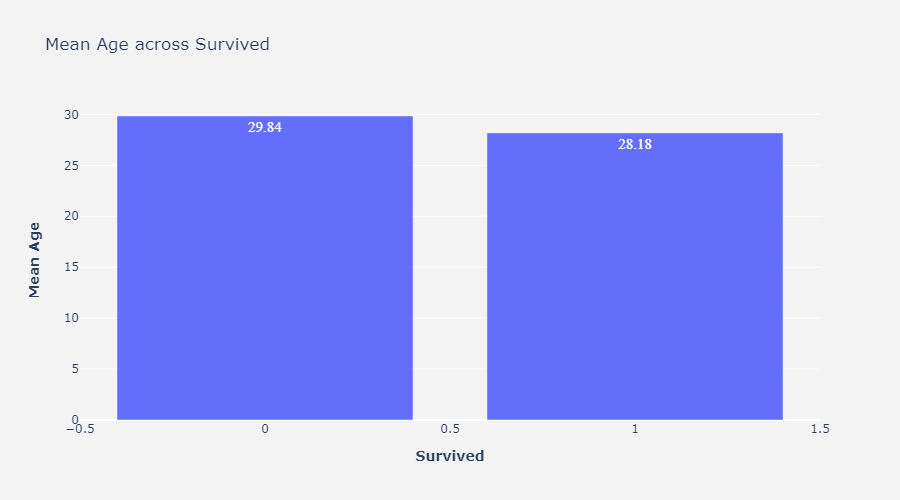

In [221]:
"""Таким образом, средний возраст выживших должен быть чуть меньше, чем у тех, кто умер (небольшая отрицательная корреляция и график чтения). Рассчитаем средний возраст выживших и жертв."""
numGroupedByCat(df_train.Age)

**У меня есть ощущение, что у молодых людей в среднем было просто больше шансов выжить. Давайте построим одну гистограмму возраста выживших, а другую - возраста жертв, чтобы подтвердить нашу интуицию.**

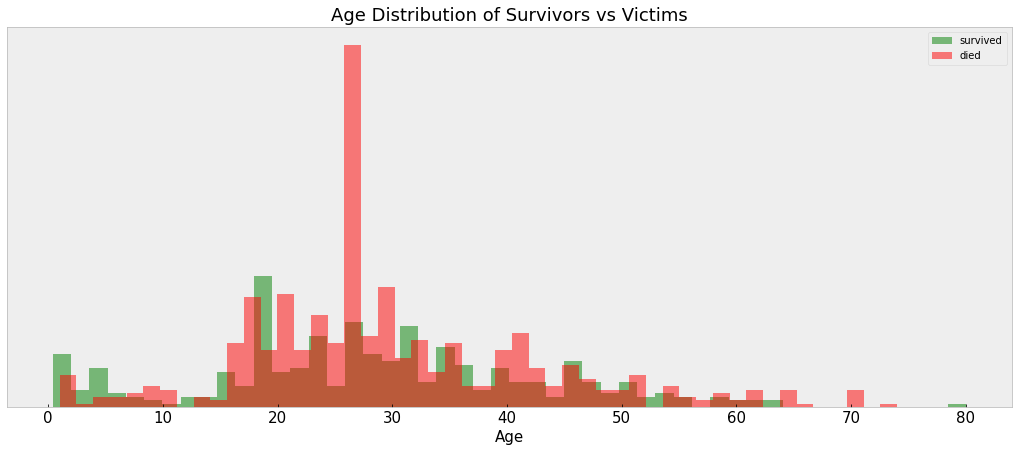

In [222]:
"""Гистограмма выживших и возраста жертв."""
numHistByCat(df_train.Age)

**Мы видим, что у младенцев и детей был высокий показатель выживаемости. Самые старые пассажиры (возраст = 80 лет) также выжили. Погибло большое количество пассажиров в возрасте от 16 до 30 лет.**

In [223]:
"""Выполним ANOVA между всеми уровнями выживших (т. е. 0 и 1) и возрастом."""
calculateAnova(df_train.Age)

'Anova Result between Age & Survived: f=> 3.162396652163441, p=> 0.07569419096180038'

**Примечание:** Выберите либо двузначную корреляцию (если категориальная переменная имеет две группы), либо Anova. Если anova указывает на основной эффект взаимодействия (т. Е. p<0,05), а категориальная переменная имеет более двух категорий (например, хороший, лучший, лучший), то выполните тест Тьюки, чтобы определить пару или пары, которые вызывают разницу (т. Е. основной эффект взаимодействия).

**Интерпретация результата ANOVA:**
Поскольку р>0,05, мы можем сказать, что вероятность выживания статистически не связана с возрастом.

## 8.2 Категориальные & Категориальные переменные <a id="8.2"></a>
Мы рассчитаем и построим график абсолютной и относительной частоты выходной категориальной переменной по номинальным переменным предиктора. Мы рассчитали бы критерий хи-квадрат между целевыми номинальными и предикторными номинальными переменными. Наконец, мы рассчитаем значение P с поправкой Бонферрони, если таблица непредвиденных обстоятельств имеет размерность более 2x2.

In [224]:
"""Создаем функцию, которая вычисляет абсолютную и относительную частоту выжившей переменной по категориальной переменной. 
А затем строит график абсолютной и относительной частоты выживших с помощью категориальной переменной."""
def calculateCrosstabulation(catVariable, targetCatVariable=df_train.Survived):
    """ Plots cross tabulation in absolute and relative scale.
    catVariable = input categorical variable, 
    targetCatVariable = our target categorical variable."""
    
    # Рассчитывает перекрестную таблицу в абс и относительном масштабе
    absCount = pd.crosstab(index = catVariable, columns = targetCatVariable)\
    .rename(columns={0:"Victims",1:"Survivors"})
    relCount = pd.crosstab(index = catVariable, columns = targetCatVariable, normalize="index")\
    .rename(columns={0:"Victims",1:"Survivors"})*100
    relCount = relCount.round(1)
    
    
    fig=make_subplots(
        rows=2, 
        cols=1,
        vertical_spacing=0.3,
        subplot_titles=(f"Absolute Count of Survival and Death by {catVariable.name}", 
                        f"Percentage Count of Survival and Death by {catVariable.name}"),
        print_grid=False) # This suppresses "This is the format of your plot grid:" text from popping out.

    
    for col in absCount.columns:
        fig.add_trace(go.Bar(x=absCount.index,
                             y=absCount[col],
                             text=absCount[col],
                             hoverinfo="x+y",
                             textposition="auto",
                             name=f"{col}",
                             textfont=dict(family="sans serif",size=14),
                             ),
                     row=1,
                     col=1
                     )


    
    for col in relCount.columns:
        fig.add_trace(go.Bar(x=relCount.index,
                             y=relCount[col],
                             text=relCount[col],
                             hoverinfo="x+y",
                             textposition="auto",
                             name=f"{col}",
                             textfont=dict(family="sans serif",size=14),
                            ),
                     row=2,
                     col=1
                     )
        
    # Update the layout. Add title, dimension, and background color
    fig.layout.update(
        height=600, 
        width=1000,
        hovermode="closest",
        barmode = "group",
        paper_bgcolor="rgb(243, 243, 243)",
        plot_bgcolor="rgb(243, 243, 243)"
        )

    
    fig.layout.yaxis1.update(title="<b>Abs Frequency</b>")
    fig.layout.yaxis2.update(title="<b>Rel Frequency(%)</b>")
    
    
    fig.layout.xaxis2.update(title=f"<b>{catVariable.name}</b>")
    return fig.show()

    
"""#2. Создаем функцию для вычисления критерия хи-квадрат между категориальной и целевой категориальной переменной."""
def calculateChiSquare(catVariable, targetCatVariable=df_train.Survived):
    """Returns chi square test restult between independent and dependent target variables."""
    
    catGroupedByCatTarget = pd.crosstab(index = catVariable, columns = targetCatVariable)
    testResult = stats.chi2_contingency(catGroupedByCatTarget)
    print(f"Chi Square Test Result between {targetCatVariable.name} & {catVariable.name}:")
    return print(testResult)


"""#3.Создаем функцию для вычисления значения p с поправкой Бонферрони для категориальной и целевой категориальной переменной."""
def calculateBonferroniAdjusted(catVariable, targetCatVariable=df_train.Survived):
    """Returns bonferroni-adjusted pvalue between independent and dependent target variables."""
    
    # Создаем one hot encoding для независимой категориальной переменной
    catEncoded = pd.get_dummies(catVariable)
    for column in catEncoded.columns:
        catGroupedByCatTarget = pd.crosstab(index = catEncoded[column], columns = targetCatVariable)
        testResult = stats.chi2_contingency(catGroupedByCatTarget)
        print(f"Bonferroni-adjusted pvalue between {catVariable.name}({column}) and {targetCatVariable.name}:")
        print(f"{testResult}\n")

### 8.2.1 Sex & Survived <a id="8.2.1"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



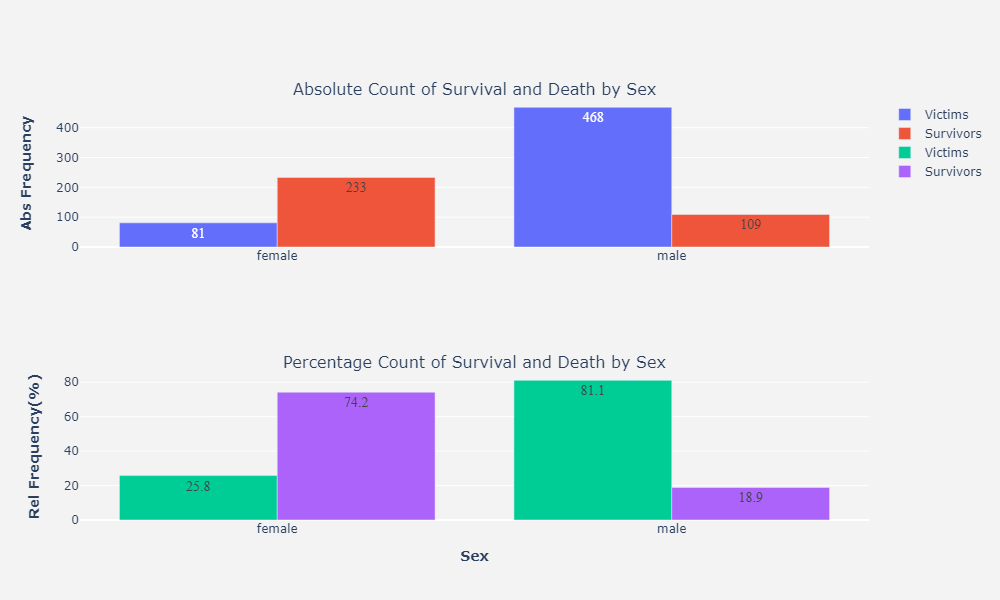

In [225]:
calculateCrosstabulation(df_train.Sex)

**Выводы:** Из 342 выживших 233 прохожих были женщинами, в то время как только 109 пассажиров были мужчинами. Таким образом, выживших женщин было более чем вдвое больше, чем выживших мужчин. Пропорция говорит о том, что у женщины более 74 % шансов на выживание, в то время как у мужчины почти 19 % шансов на выживание. Так что у женщины больше всего шансов выжить.

***Критерий Хи-квадрат***: Критерий независимости Хи-квадрат проверяет, существует ли существенная связь между двумя категориальными переменными.Данные обычно отображаются в формате перекрестной таблицы, где каждая строка представляет категорию для одной переменной, а каждый столбец представляет категорию для другой переменной. Критерий независимости Хи-квадрат - это комплексный тест.То есть он проверяет данные в целом. Это означает, что никто не сможет определить, какие уровни (категории) переменных отвечают за взаимосвязь **, если таблица Хи-квадрат больше 2×2. Если тест больше 2×2, он требует пост-специального тестирования.**

**H0 (Нулевая гипотеза): Нет никакой связи между переменной 1 и переменной 2.**

**H1 (Альтернативная гипотеза): Существует взаимосвязь между переменной 1 и переменной 2.**

Если значение p является значимым (менее 0,05), вы можете отклонить нулевую гипотезу и утверждать, что результаты подтверждают альтернативную гипотезу. В то время как мы проверяем результаты теста chi2, нам также необходимо проверить, что ожидаемые частоты ячеек больше или равны 5. Если ожидаемая частота ячейки меньше 5, то для преодоления этой проблемы следует использовать точный тест Фишера.

Метод chi2_contingency() проводит тест Хи-квадрат на таблице непредвиденных обстоятельств (перекрестная таблица).

In [226]:
calculateChiSquare(df_train.Sex)

Chi Square Test Result between Survived & Sex:
(260.71702016732104, 1.1973570627755645e-58, 1, array([[193.47474747, 120.52525253],
       [355.52525253, 221.47474747]]))


***Интерпретация результатов теста хи-квадрат***: Первое значение (260,717) - это значение Хи-квадрат, за которым следует значение p (1,197e-58), затем идут степени свободы (1) и, наконец, выводятся ожидаемые частоты в виде массива. Поскольку все ожидаемые частоты превышают 5, результатам теста chi2 можно доверять. Мы можем отвергнуть нулевую гипотезу, так как значение p меньше 0,05 (фактическое значение p почти равно 0).  Таким образом, результаты показывают, что существует статистически значимая связь между полом и выживаемостью.

### 8.2.2 Pclass & Survived<a id="8.2.2"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



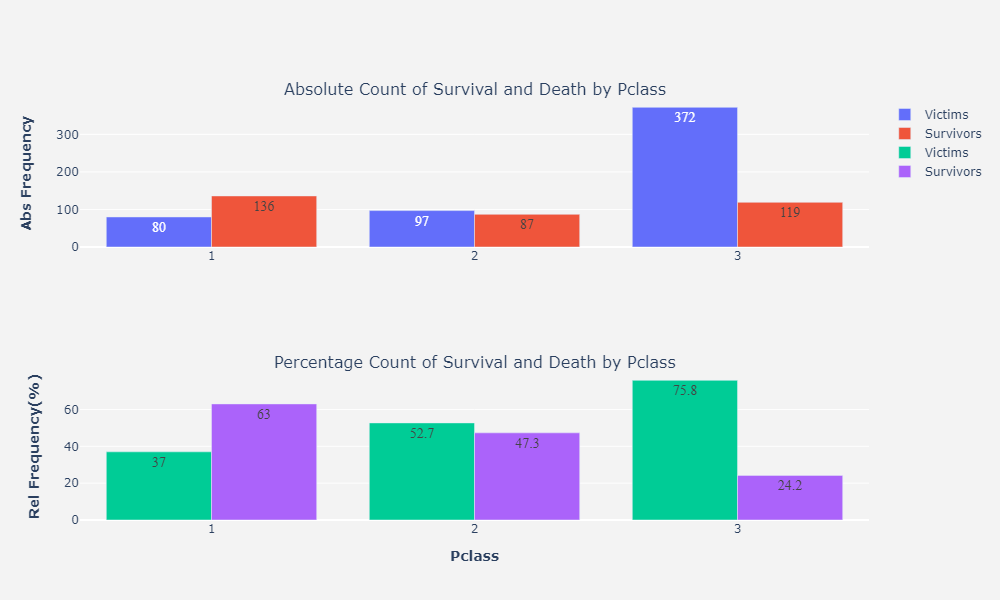

In [227]:
calculateCrosstabulation(df_train.Pclass)

**Результаты:** Из 342 выживших наибольшее число выживших приходится на класс 1 (136), за которым следуют класс 3 (119) и класс 2 (87). Но процент говорит о другом. Если вы находитесь в классе 1, ваш шанс на выживание составляет почти 63 %, в то время как у pclass2 шанс на выживание составляет чуть более 47 %. Но если вы находитесь в классе 3, ваши шансы на выживание очень малы, т. е. чуть более 24 %.

In [228]:
calculateChiSquare(df_train.Pclass)

Chi Square Test Result between Survived & Pclass:
(102.88898875696056, 4.549251711298793e-23, 2, array([[133.09090909,  82.90909091],
       [113.37373737,  70.62626263],
       [302.53535354, 188.46464646]]))


**Интерпретация результатов теста хи-квадрат:** Общая таблица 3x2 имеет значение хи-квадрат 102,889, значение pvalue 4,549e-23, степени свободы 2, а остальные - ожидаемые частоты массива. Поскольку все ожидаемые частоты превышают 5, результатам теста chi2 можно доверять. Мы можем отвергнуть нулевую гипотезу, так как значение p меньше 0,05 (фактическое значение p почти равно 0). Таким образом, результаты показывают, что существует статистически значимая связь между классом P и выжившими на "Титанике". 


**Post Hoc Тест**: Хотя наш критерий Хи-квадрат был значимым, поскольку наш анализ равен 3x2, мы не знаем, какие уровни Pclass(1, 2 или 3) имеют наиболее сильную связь с выжившими переменными. Следовательно, нам необходимо выполнить пост-специальный тест, чтобы проверить, действительно ли и какие комбинации существенно связаны с выжившими. Чтобы сделать это, нам нужно провести несколько тестов Хи-квадрат 2×2 с использованием p-значения, скорректированного на *Бонферрони.*

Чтобы провести несколько тестов 2×2 Хи-квадрат, необходимо перегруппировать переменные для каждого теста так, чтобы они относились к одной категории по сравнению с остальными. Для нас это будет:

1. 1 против 2
2. 1 против 3
3. И, наконец, 2 против 3

**Поскольку существует 3 сравнения, значение P с поправкой Бонферрони, необходимое для значимости, составляет 0,05/3, или 0,017. Таким образом, для того, чтобы наши любые запланированные попарные сравнения были значимыми, значение p должно быть меньше 0,017.**

In [229]:
calculateBonferroniAdjusted(df_train.Pclass)

Bonferroni-adjusted pvalue between Pclass(1) and Survived:
(71.46583854616047, 2.821002116713357e-17, 1, array([[415.90909091, 259.09090909],
       [133.09090909,  82.90909091]]))

Bonferroni-adjusted pvalue between Pclass(2) and Survived:
(7.2971925540056475, 0.006906243870048795, 1, array([[435.62626263, 271.37373737],
       [113.37373737,  70.62626263]]))

Bonferroni-adjusted pvalue between Pclass(3) and Survived:
(91.23179223158795, 1.277904920294387e-21, 1, array([[246.46464646, 153.53535354],
       [302.53535354, 188.46464646]]))



**Интерпретация результатов теста p-значения с поправкой Бонферрони:** При использовании p-значения с поправкой Бонферрони, равного 0,017, 3 из 3 запланированных попарных сравнений являются значимыми. Хотя значение p предполагает, что класс 2 имеет самую слабую связь с выжившими по сравнению с классами 1 и 3.

###  8.2.3 Embarked & Survived <a id="8.2.3"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



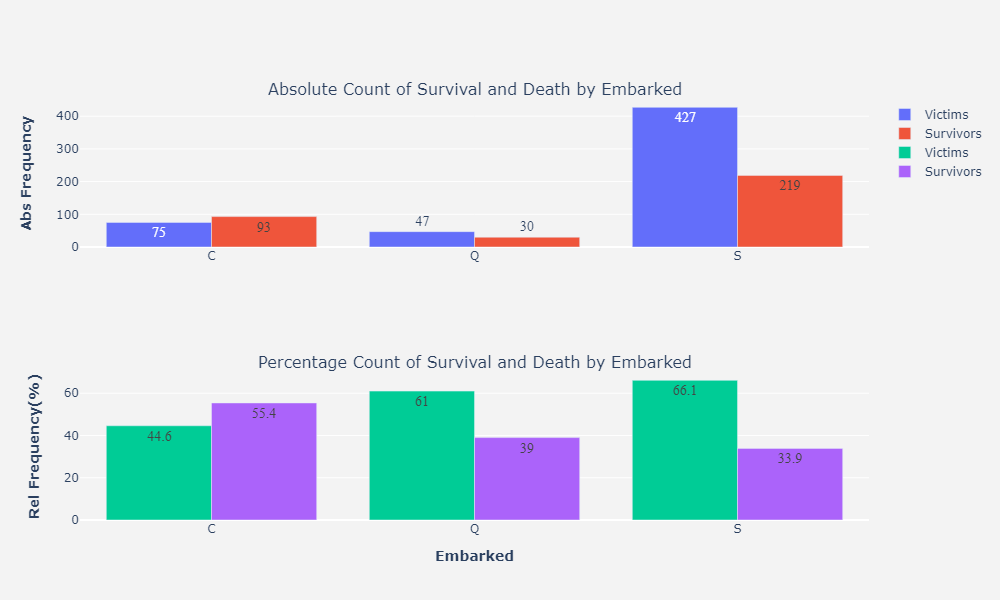

In [230]:
calculateCrosstabulation(df_train.Embarked)

**Выводы:** Хотя люди, отправившиеся из Саутгемптона, имеют наибольшее количество выживших (219), но пропорционально у них есть только почти 34 % шансов на выживание. Потому что 427 пассажиров, отправившихся из Саутгемптона, погибли. Напротив, если вы отправитесь из Шербура, у вас будет очень приличный шанс выжить - более 55 %.  Наконец, люди, отправившиеся из Квинстауна, имеют шанс выжить более чем на 5 % по сравнению с теми, кто отправился из Саутгемптона.

In [231]:
calculateChiSquare(df_train.Embarked)

Chi Square Test Result between Survived & Embarked:
(25.964452881874784, 2.3008626481449577e-06, 2, array([[103.51515152,  64.48484848],
       [ 47.44444444,  29.55555556],
       [398.04040404, 247.95959596]]))


**Интерпретация результата теста хи-квадрат:** Таблица 3x2 имеет значение хи-квадрат 25,96, значение pvalue 2,3e-06, степени свободы 2, а остальные - ожидаемые частоты массива. Поскольку все ожидаемые частоты превышают 5, результатам теста chi2 можно доверять. Мы можем отвергнуть нулевую гипотезу, так как значение p меньше 0,05 (на самом деле значение p меньше 0,01). Таким образом, результаты показывают, что существует статистически значимая взаимосвязь между переменными, начавшимися и выжившими.

**Поскольку существует три сравнения, значение P с поправкой Бонферрони, необходимое для значимости, составляет 0,05/3, или 0,017. Таким образом, для того, чтобы наши любые запланированные попарные сравнения были значимыми, значение p должно быть меньше 0,017.**

In [232]:
calculateBonferroniAdjusted(df_train.Embarked)

Bonferroni-adjusted pvalue between Embarked(C) and Survived:
(24.34294028991685, 8.062166851376562e-07, 1, array([[445.48484848, 277.51515152],
       [103.51515152,  64.48484848]]))

Bonferroni-adjusted pvalue between Embarked(Q) and Survived:
(0.00018551307377882246, 0.9891328942213099, 1, array([[501.55555556, 312.44444444],
       [ 47.44444444,  29.55555556]]))

Bonferroni-adjusted pvalue between Embarked(S) and Survived:
(19.279400244953347, 1.1291808110540787e-05, 1, array([[150.95959596,  94.04040404],
       [398.04040404, 247.95959596]]))



**** Интерпретация результата попарного значения p с поправкой Бонферрони:** При использовании значения p с поправкой Бонферрони, равного 0,017, 2 из 3 запланированных попарных сравнений являются значимыми. Скорректированное на Бонферрони значение p для Q и выживших составляет 0,989, что намного больше, чем 0,017. Таким образом, можно сказать, что уровень Q переменной Started статистически не связан с переменной Survived.

### 8.2.4 SibSp & Survived <a id="8.2.4"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



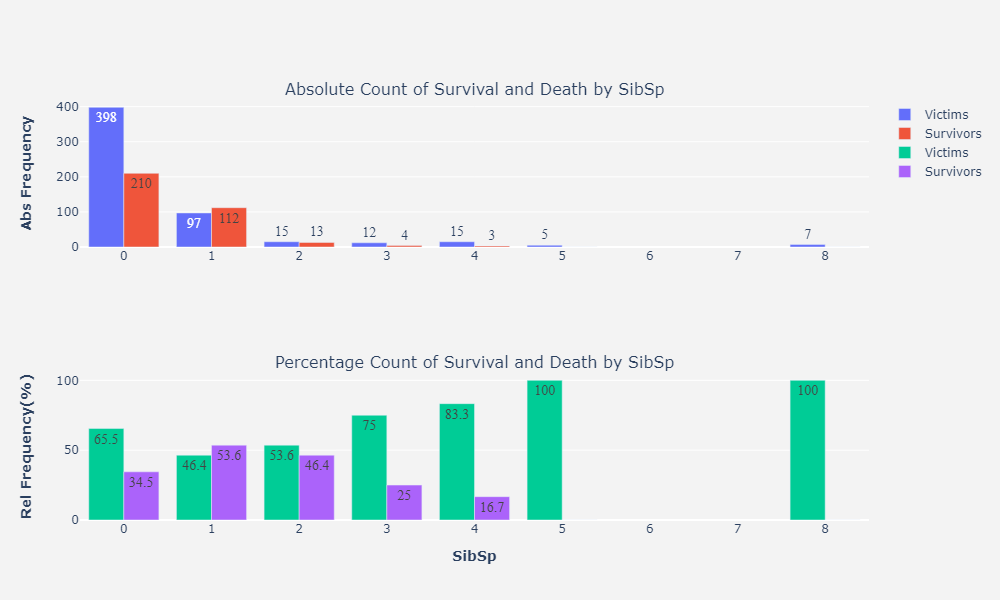

In [233]:
calculateCrosstabulation(df_train.SibSp)

**Результаты:** Большое количество пассажиров (210), которые выжили, не имели (0) братьев или сестер или супругов, за которыми следовали 112 пассажиров с 1 супругом или братьями и сестрами. В процентном отношении пассажиры с 1 супругом или братьями и сестрами имели более 53,5 % шансов на выживание, а затем пассажиры с 2 братьями и сестрами или супругом имели более 46 % шансов на выживание. Все пассажиры с 5 или 8 братьями и сестрами или супругами погибли.

In [234]:
calculateChiSquare(df_train.SibSp)

Chi Square Test Result between Survived & SibSp:
(37.2717929152043, 1.5585810465902147e-06, 6, array([[374.62626263, 233.37373737],
       [128.77777778,  80.22222222],
       [ 17.25252525,  10.74747475],
       [  9.85858586,   6.14141414],
       [ 11.09090909,   6.90909091],
       [  3.08080808,   1.91919192],
       [  4.31313131,   2.68686869]]))


**Интерпретация теста Хи-квадрат:** Поскольку все ожидаемые частоты не превышают 5, результатам теста хи-квадрат доверять нельзя.

### 8.2.5 Parch & Survived  <a id="8.2.5"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



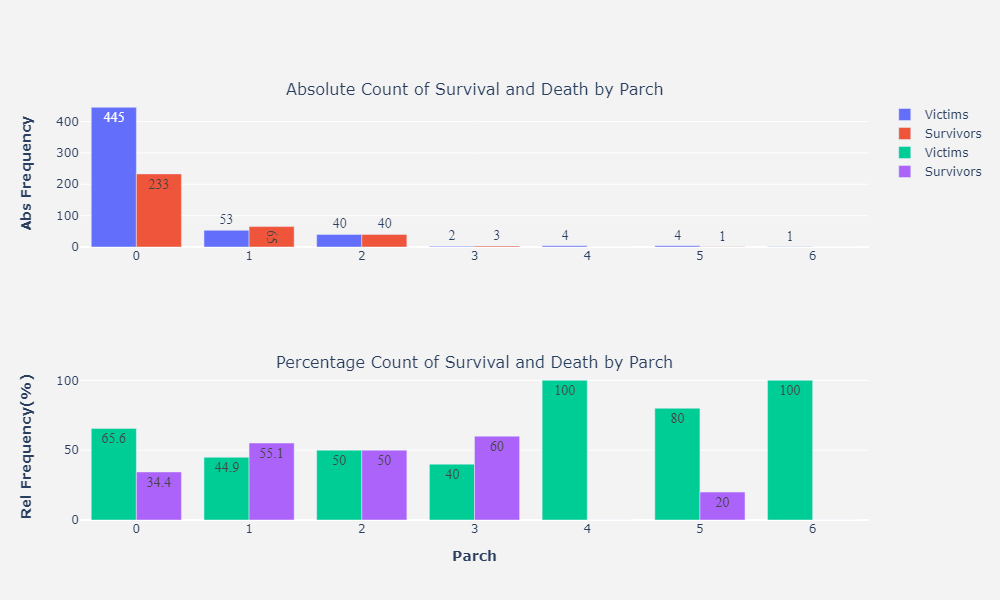

In [235]:
calculateCrosstabulation(df_train.Parch)

**Результаты:** У пассажиров с 3 детьми/родителем показатель выживаемости составил 60 %, за которыми следуют пассажиры с 2 детьми/родителем, показатель выживаемости составил 50 %. Никто из пассажиров не выжил с 4 или 6 детьми/родителями.

In [236]:
calculateChiSquare(df_train.Parch)

Chi Square Test Result between Survived & Parch:
(27.925784060236168, 9.703526421039997e-05, 6, array([[4.17757576e+02, 2.60242424e+02],
       [7.27070707e+01, 4.52929293e+01],
       [4.92929293e+01, 3.07070707e+01],
       [3.08080808e+00, 1.91919192e+00],
       [2.46464646e+00, 1.53535354e+00],
       [3.08080808e+00, 1.91919192e+00],
       [6.16161616e-01, 3.83838384e-01]]))


**Интерпретация результатов теста Хи-квадрат:** Поскольку все ожидаемые частоты не превышают 5, результатам теста хи-квадрат доверять нельзя.
### 8.2.6 nameProcessed & Survived<a id="8.2.6"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



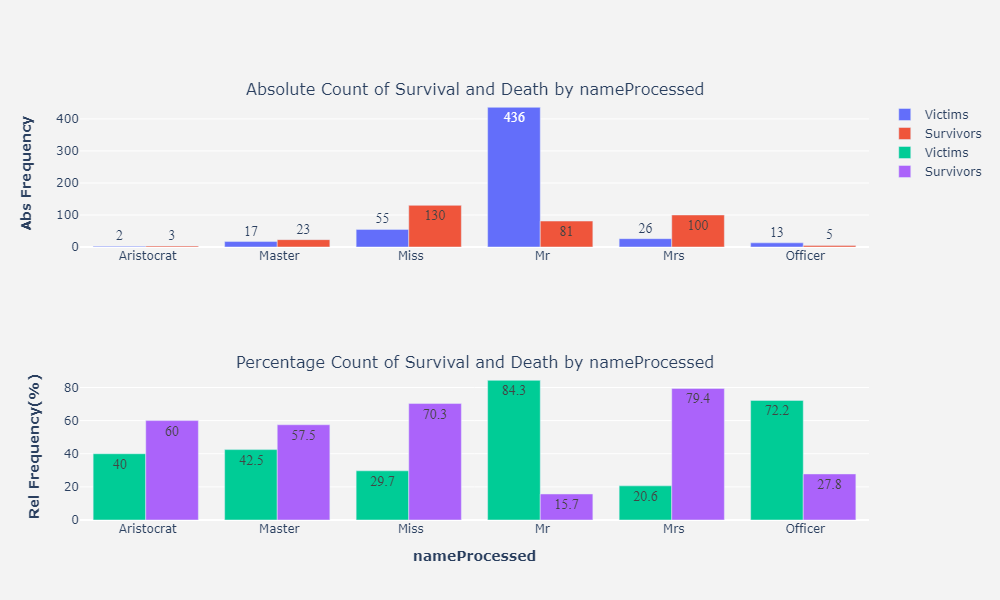

In [237]:
calculateCrosstabulation(df_train.nameProcessed)

**Результаты:** У женщин был лучший показатель выживаемости, т. Е. Миссис (более 79 %) и Мисс (более 70 %), что напоминает нам о переменном поле, в котором, как мы видели, женщины с большей вероятностью выживали. Мистер - это худший титул, который можно получить, когда дело доходит до ситуации выживания, так как чуть более 15 % пассажиров с титулом Мистер выжили, что еще раз указывает на важность секса как средства для выживания.

In [238]:
calculateChiSquare(df_train.nameProcessed)

Chi Square Test Result between Survived & nameProcessed:
(289.8360961873925, 1.5325912223703196e-60, 5, array([[  3.08080808,   1.91919192],
       [ 24.64646465,  15.35353535],
       [113.98989899,  71.01010101],
       [318.55555556, 198.44444444],
       [ 77.63636364,  48.36363636],
       [ 11.09090909,   6.90909091]]))


**Интерпретация результата теста хи-квадрат**: Поскольку все ожидаемые частоты не превышают 5, результату теста хи-квадрат доверять нельзя.

### 8.2.7 familySize & Survived<a id="8.2.7"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



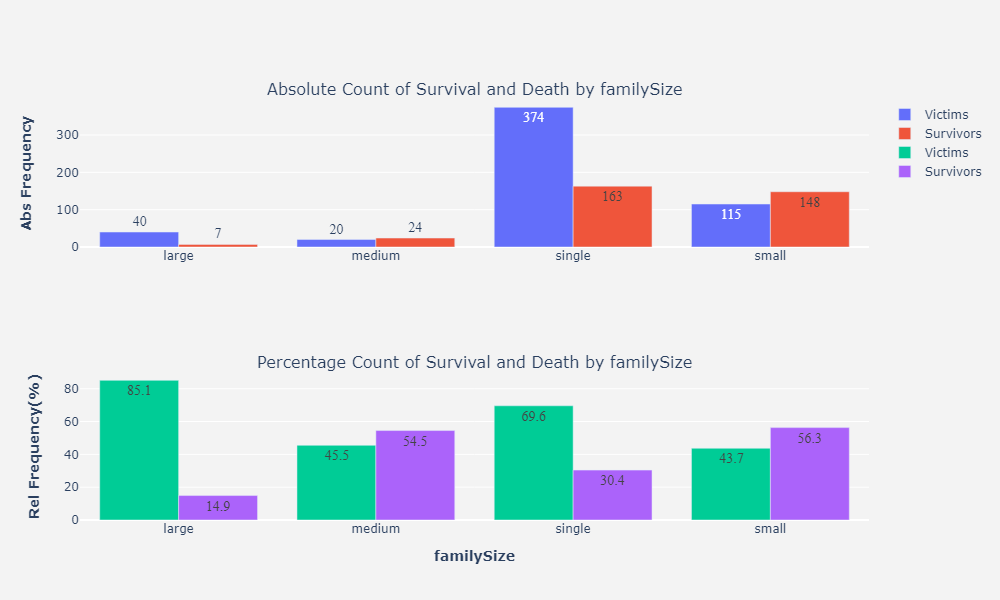

In [239]:
calculateCrosstabulation(df_train.familySize)

**Результаты:** У пассажиров с малым и средним размером семьи был хороший показатель выживаемости. Шансы на выживание одиноких пассажиров составляли чуть более 30 %. А у пассажиров с многодетными семьями показатель выживаемости ниже 15 %.

In [240]:
calculateChiSquare(df_train.familySize)

Chi Square Test Result between Survived & familySize:
(66.05581680279249, 2.981870009647575e-14, 3, array([[ 28.95959596,  18.04040404],
       [ 27.11111111,  16.88888889],
       [330.87878788, 206.12121212],
       [162.05050505, 100.94949495]]))


**Интерпретация результата теста хи-квадрат**: Поскольку все ожидаемые частоты больше 5, результатам теста хи2 можно доверять. Мы можем отвергнуть нулевую гипотезу, так как значение p меньше 0,05 (фактическое значение p почти равно 0). Таким образом, результаты показывают, что существует статистически значимая связь между переменной Family_size и выжившими.

**Поскольку существует 8 сравнений, значение P с поправкой Бонферрони, необходимое для значимости, составляет 0,05/8, или 0,0063. Таким образом, для того, чтобы наши любые запланированные попарные сравнения были значимыми, значение p должно быть меньше 0,0063.**

In [241]:
calculateBonferroniAdjusted(df_train.familySize)

Bonferroni-adjusted pvalue between familySize(large) and Survived:
(10.55137053799774, 0.0011610196650239893, 1, array([[520.04040404, 323.95959596],
       [ 28.95959596,  18.04040404]]))

Bonferroni-adjusted pvalue between familySize(medium) and Survived:
(4.418221527178599, 0.03555707818485421, 1, array([[521.88888889, 325.11111111],
       [ 27.11111111,  16.88888889]]))

Bonferroni-adjusted pvalue between familySize(single) and Survived:
(36.00051446773865, 1.9726543846517113e-09, 1, array([[218.12121212, 135.87878788],
       [330.87878788, 206.12121212]]))

Bonferroni-adjusted pvalue between familySize(small) and Survived:
(49.42743388214718, 2.058468013374345e-12, 1, array([[386.94949495, 241.05050505],
       [162.05050505, 100.94949495]]))



**Интерпретация результатов пост-специального теста с поправкой Бонферрони:** При использовании значения p с поправкой Бонферрони, равного 0,0063, 3 из 4 запланированных попарных сравнений являются значимыми. Скорректированное на Бонферрони значение p для средних и выживших составляет 0,03555, что намного больше, чем 0,0063. Таким образом, можно сказать, что средний уровень переменной численности семьи статистически не связан с переменной выживаемостью.

### 8.2.8 cabinProcessed & Survived<a id="8.2.8"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



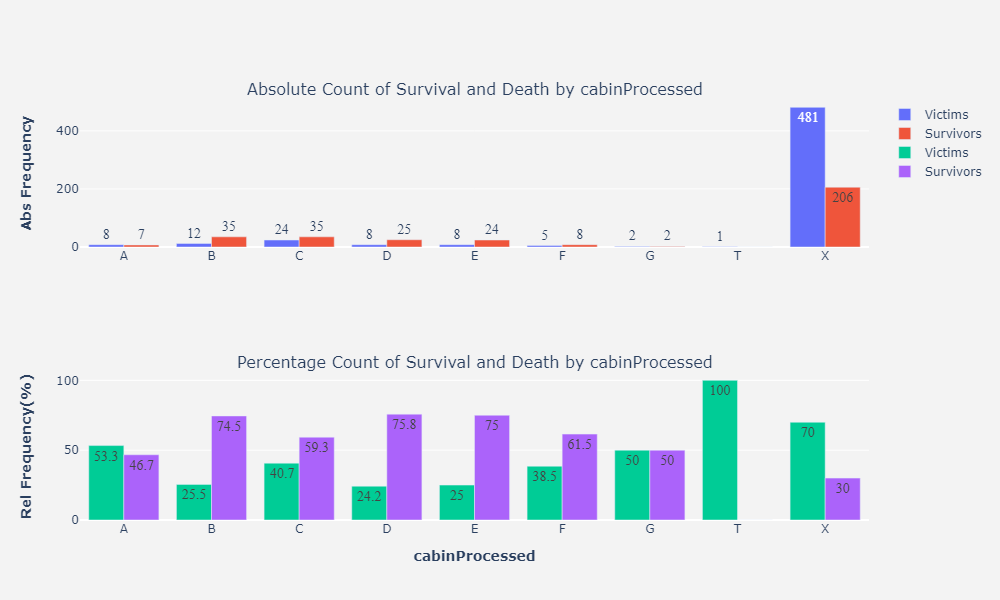

In [242]:
calculateCrosstabulation(df_train.cabinProcessed)

**Выводы:** Большинство выживших и погибших пассажиров были из салона X. Но в процентном отношении его категории B, D и E имели впечатляющие шансы на выживание. Люди из каюты категории X имели всего 30 % шансов на выживание.

In [243]:
calculateChiSquare(df_train.cabinProcessed)

Chi Square Test Result between Survived & cabinProcessed:
(99.16416061888009, 6.326020042314704e-18, 8, array([[9.24242424e+00, 5.75757576e+00],
       [2.89595960e+01, 1.80404040e+01],
       [3.63535354e+01, 2.26464646e+01],
       [2.03333333e+01, 1.26666667e+01],
       [1.97171717e+01, 1.22828283e+01],
       [8.01010101e+00, 4.98989899e+00],
       [2.46464646e+00, 1.53535354e+00],
       [6.16161616e-01, 3.83838384e-01],
       [4.23303030e+02, 2.63696970e+02]]))


**Интерпретация результата теста хи-квадрат**: Поскольку все ожидаемые частоты не превышают 5, результатам теста хи2 нельзя доверять.

### 8.2.9 ticketProcessed & Survived<a id="8.2.9"></a>

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



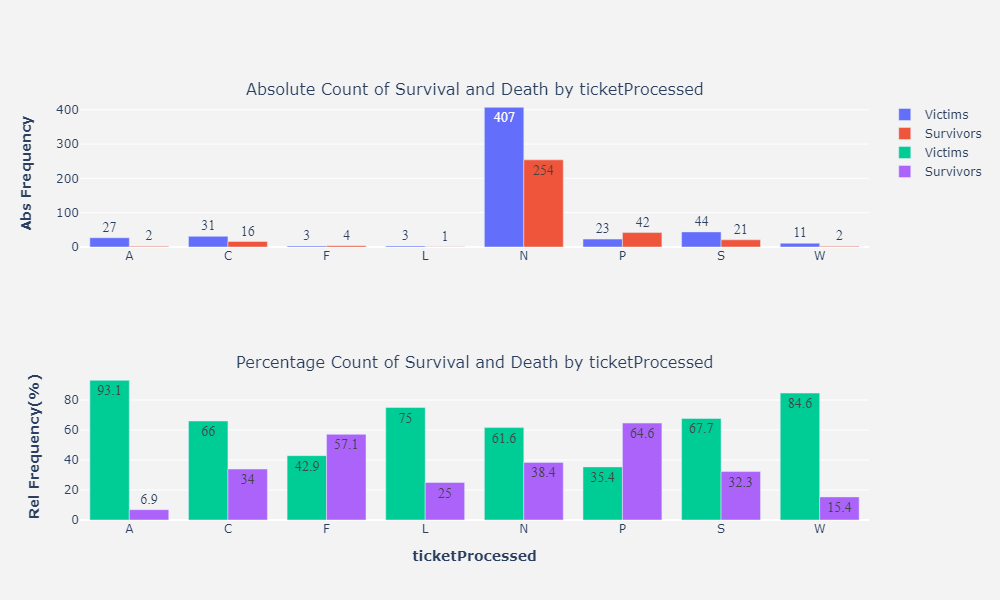

In [244]:
calculateCrosstabulation(df_train.ticketProcessed)

**Результаты:** 93 % пассажиров умерли с билетами категории A, более 64 % выжили с билетами категории P. Более 57 % выжили с билетами категории F и чуть более 15 % пассажиров выжили с билетами категории Which.

In [245]:
calculateChiSquare(df_train.ticketProcessed)

Chi Square Test Result between Survived & ticketProcessed:
(36.7098892616397, 5.323006335674428e-06, 7, array([[ 17.86868687,  11.13131313],
       [ 28.95959596,  18.04040404],
       [  4.31313131,   2.68686869],
       [  2.46464646,   1.53535354],
       [407.28282828, 253.71717172],
       [ 40.05050505,  24.94949495],
       [ 40.05050505,  24.94949495],
       [  8.01010101,   4.98989899]]))


**Интерпретация результата теста хи-квадрат**: Поскольку все ожидаемые частоты не превышают 5, результатам теста хи2 нельзя доверять.

# 9.Многомерный Анализ<a id="9"></a>
В многомерном анализе мы пытаемся найти взаимосвязь между более чем двумя переменными. Число переменных-предикторов в двумерном анализе было равно единице. Напротив, число переменных-предикторов для многомерного анализа больше одного. Более конкретно, мы попытаемся связать более одной переменной-предиктора с переменной ответа. Мы просто визуализируем влияние различных переменных-предикторов (3 переменных) одновременно на выжившую переменную.

In [246]:
"""Создаем функцию, которая отображает влияние 3 переменных-предикторов одновременно на целевую переменную."""
def doMultivariateAnalysis(catVar1, catVar2, catVar3, targetCatVariable=df_train.Survived):
   
 
    fig,ax = plt.subplots(1,1,figsize = (18,5))
    fontSize = 15
    catGroupedByCatTarget = pd.crosstab(index = [catVar1, catVar2, catVar3],
                                        columns = targetCatVariable, normalize = "index")*100
    catGroupedByCatTarget.rename({0:"%Died", 1:"%Survived"}, axis = 1, inplace = True)
    catGroupedByCatTarget.plot.bar(color = ["red", "green"],ax=ax)
    ax.set_xlabel(f"{catVar1.name},{catVar2.name},{catVar3.name}", fontsize = fontSize)
    ax.set_ylabel("Relative Frequency(%)", fontsize = fontSize)
    ax.tick_params(axis="x", labelsize=fontSize)
    ax.tick_params(axis="x", labelsize=fontSize)
    plt.legend(loc = "best")
    return plt.show()

## 9.1 (Pclass, Sex, cabinProcessed) vs Survived <a id="9.1"></a>

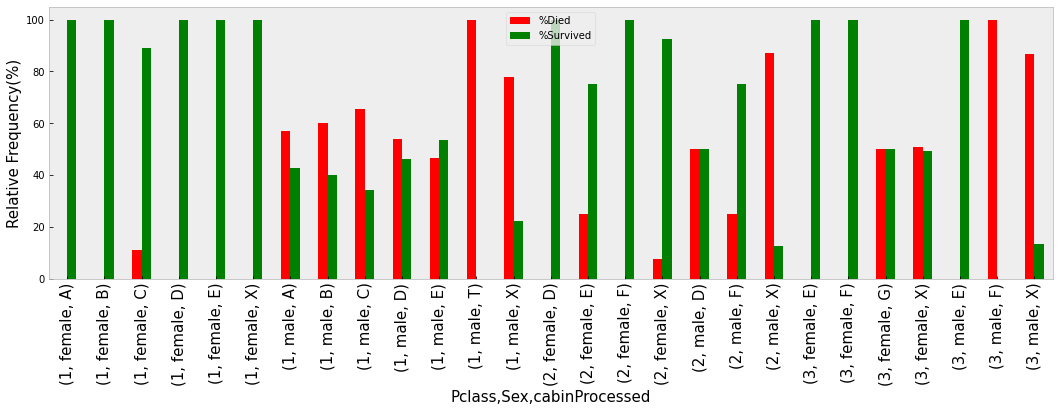

**Выводы: Пол мужчины, по-видимому, является решающим фактором для смерти.**

In [247]:
doMultivariateAnalysis(df_train.Pclass, df_train.Sex, df_train.cabinProcessed)
bold("Выводы: Пол мужчины, по-видимому, является решающим фактором для смерти.")

## 9.2 (Pclass, Sex, Embarked) vs Survived <a id="9.2"></a>

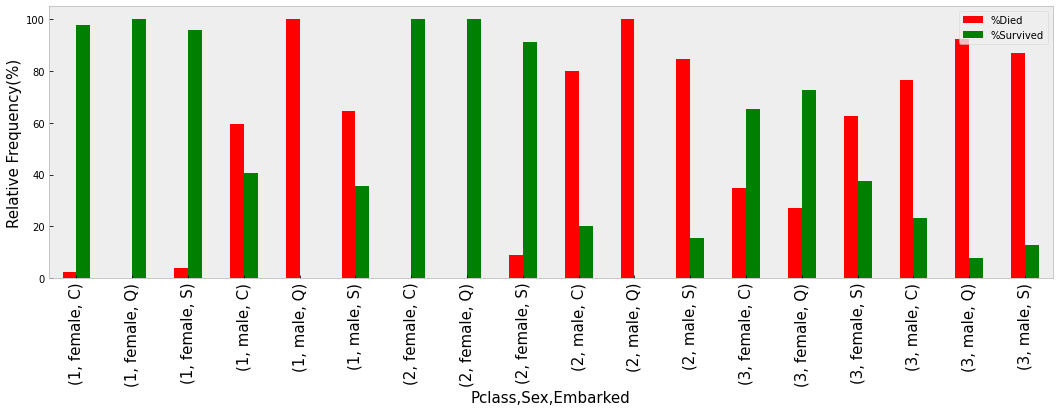

**Выводы: Опять же, пол мужчины, по-видимому, является решающим фактором для смерти, а женщины - для выживания.**

In [248]:
doMultivariateAnalysis(df_train.Pclass, df_train.Sex, df_train.Embarked)
bold("Выводы: Опять же, пол мужчины, по-видимому, является решающим фактором для смерти, а женщины - для выживания.")

## 9.3 (Pclass, Sex, SibSp) vs Survived <a id="9.3"></a>

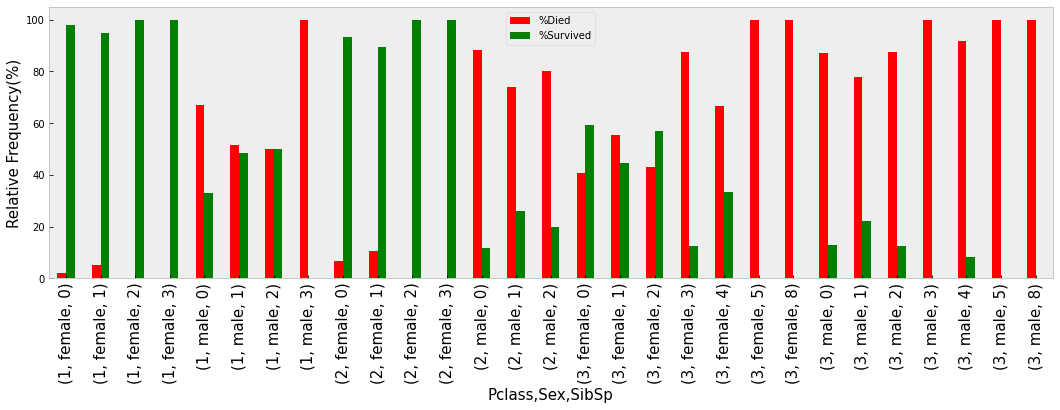

**Выводы: Более крупные SibSp и мужской пол в большей степени ответственны за смерть.**

In [249]:
doMultivariateAnalysis(df_train.Pclass, df_train.Sex, df_train.SibSp)
bold("Выводы: Более крупные SibSp и мужской пол в большей степени ответственны за смерть.")

## 9.4 (Pclass, Sex, Parch) vs Survived<a id="9.4"></a>

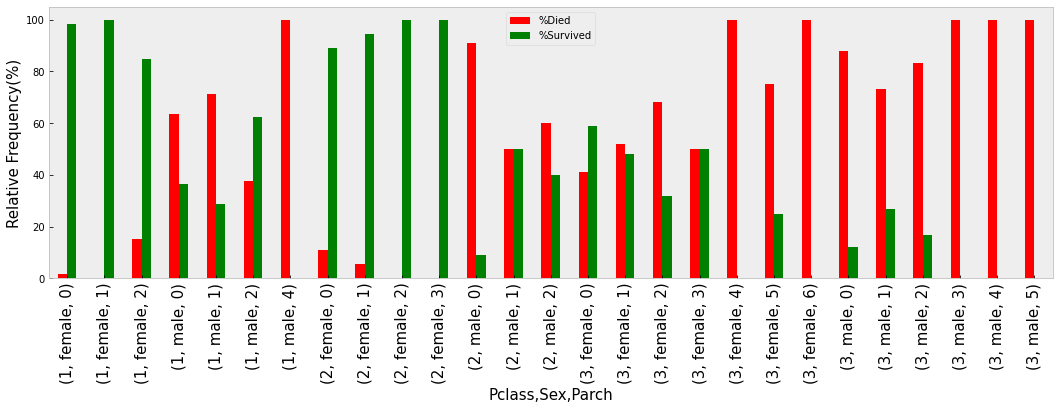

**Выводы: Parch и мужской пол в большей степени ответственны за смерть.**

In [250]:
doMultivariateAnalysis(df_train.Pclass, df_train.Sex, df_train.Parch)
bold("Выводы: Parch и мужской пол в большей степени ответственны за смерть.")

## 9.5 (Pclass, Sex, nameProcessed) vs Survived <a id="9.5"></a>

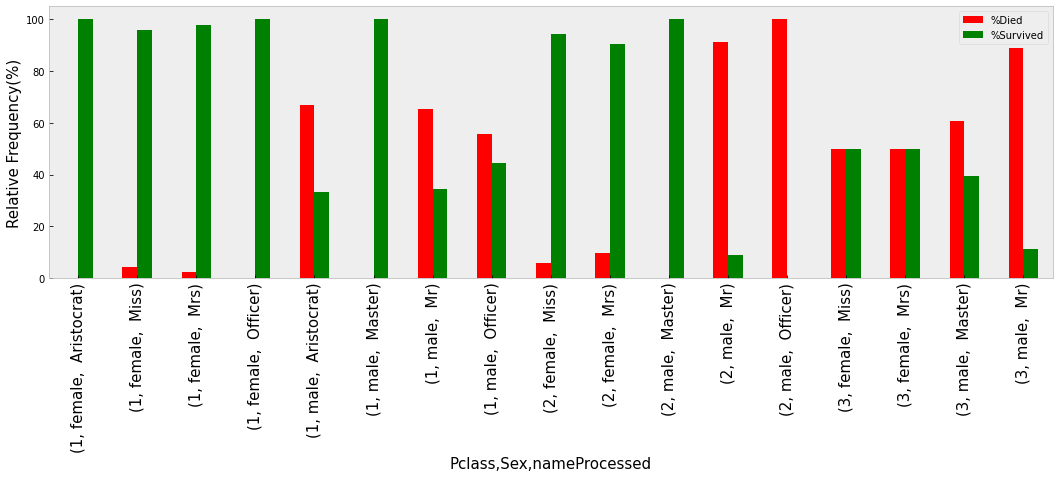

**Findings: Passengers with sex male and title mr mostly died.**

In [251]:
doMultivariateAnalysis(df_train.Pclass, df_train.Sex, df_train.nameProcessed)
bold("Findings: Passengers with sex male and title mr mostly died.")

## 9.6 (Pclass, Sex, familySize) vs Survived <a id="9.6"></a>

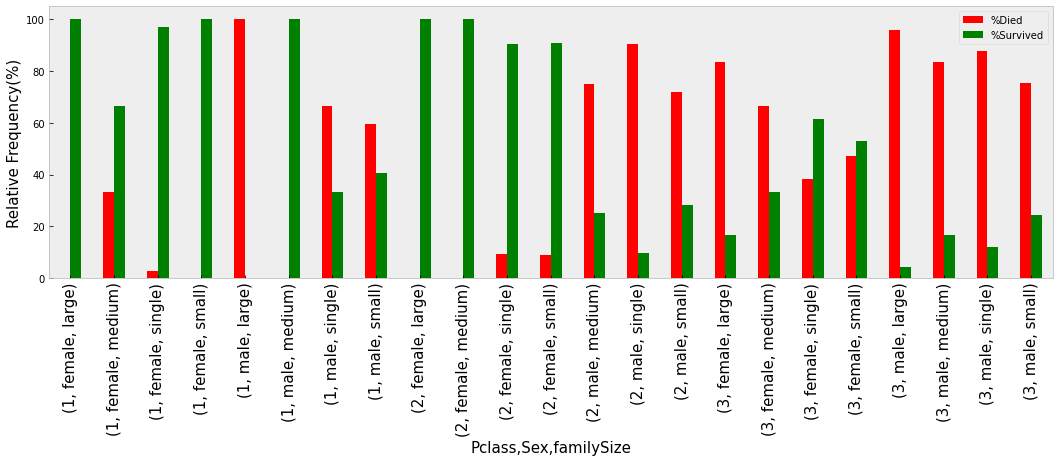

**Findings: Sex male, family size single and large greatly influence the death ratio.**

In [252]:
doMultivariateAnalysis(df_train.Pclass, df_train.Sex, df_train.familySize)
bold("Findings: Sex male, family size single and large greatly influence the death ratio.")

## 9.7 (Pclass, Sex, ticketProcessed) vs Survived <a id="9.7"></a>

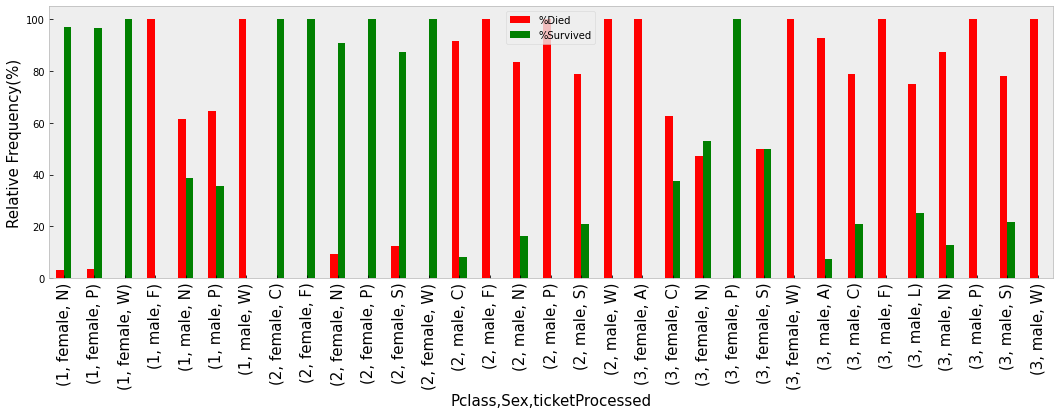

**Findings: Sex female, ticketProcessed p and w mostly survived.**

In [253]:
doMultivariateAnalysis(df_train.Pclass, df_train.Sex, df_train.ticketProcessed)
bold("Findings: Sex female, ticketProcessed p and w mostly survived.")

## 9.8 (Pclass, nameProcessed, cabinProcessed) vs Survived <a id="9.8"></a>

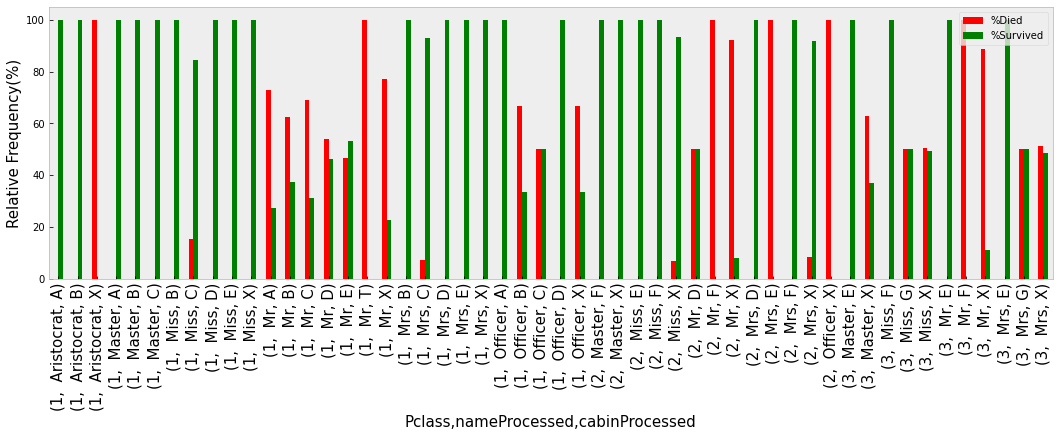

**Findings: Title mrs, master and cabin x had best survival ratio.**

In [254]:
doMultivariateAnalysis(df_train.Pclass, df_train.nameProcessed, df_train.cabinProcessed)
bold("Findings: Title mrs, master and cabin x had best survival ratio.")

## 9.9 (familySize, Sex, cabinProcessed) vs Survived <a id="9.9"></a>

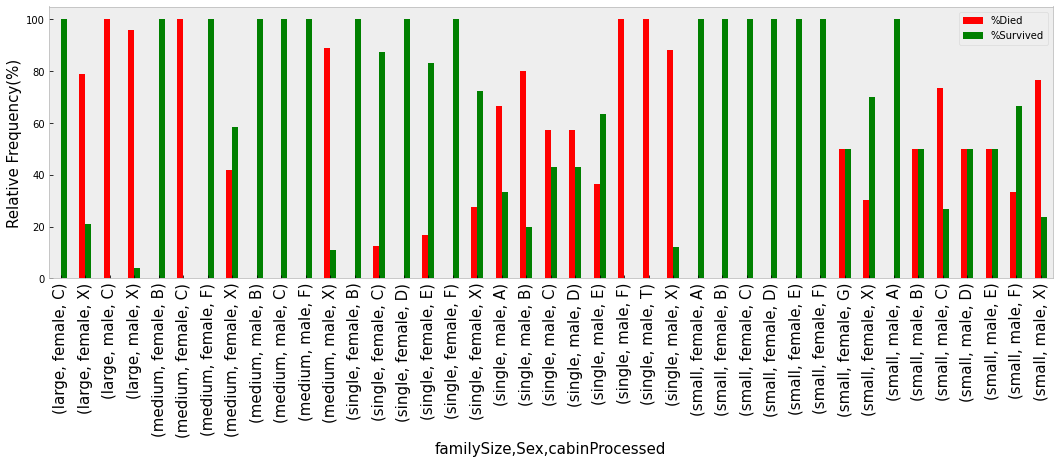

**Findings: family size small, medium and sex female had best survival chance.**

In [255]:
"""Proportion of survivors and victims due to familSize, sex, and cabinProcessed."""
doMultivariateAnalysis(df_train.familySize, df_train.Sex, df_train.cabinProcessed)
bold("Findings: family size small, medium and sex female had best survival chance.")

## 9.10 (Sex, nameProcessed, familySize) vs Survived <a id="9.10"></a>

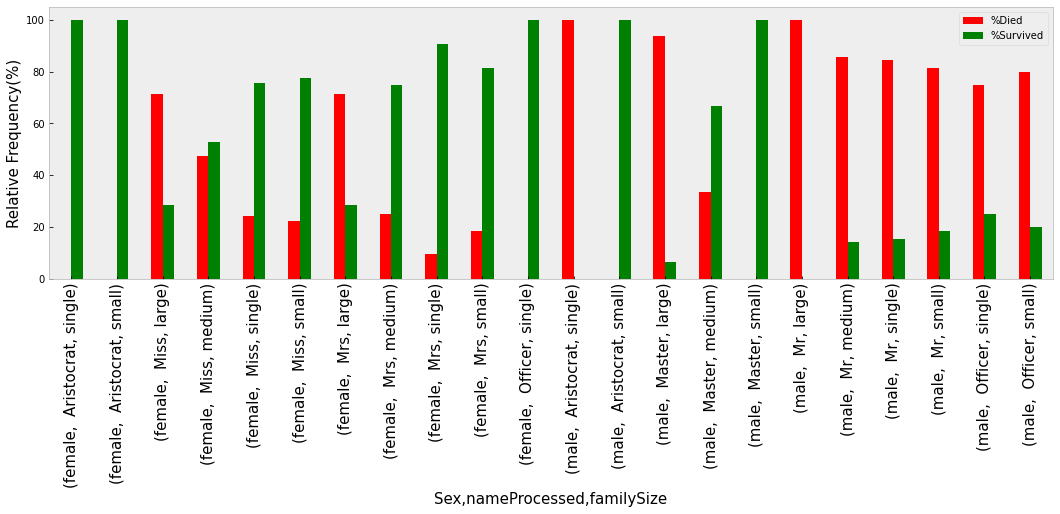

**Findings: Title aristocrat, sex female and familySize small mostly survived.**

In [256]:
doMultivariateAnalysis(df_train.Sex, df_train.nameProcessed, df_train.familySize)
bold("Findings: Title aristocrat, sex female and familySize small mostly survived.")

## 9.11 (Sex, nameProcessed, cabinProcessed) vs Survived <a id="9.11"></a>

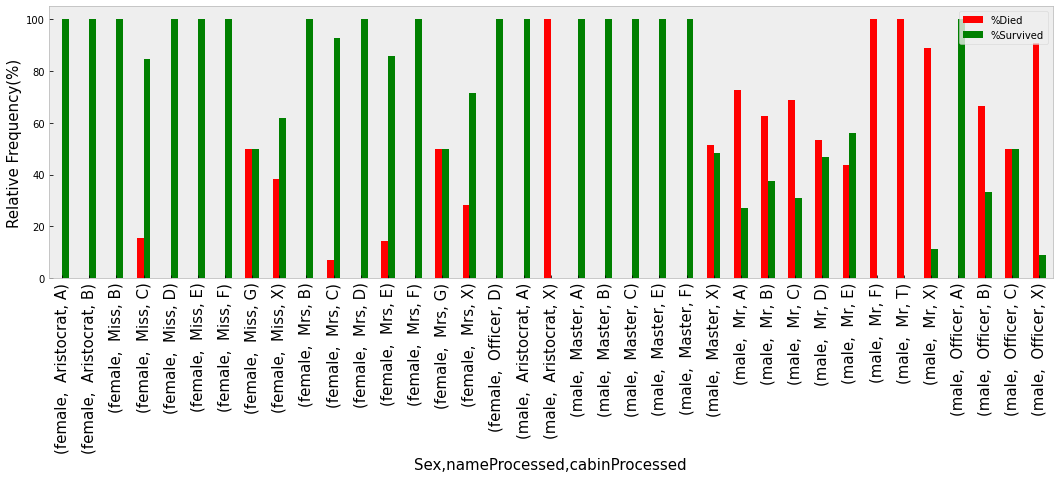

**Findings: Title aristocrat, miss, mrs and sex female mostly survived.**

In [257]:
doMultivariateAnalysis(df_train.Sex, df_train.nameProcessed, df_train.cabinProcessed)
bold("Findings: Title aristocrat, miss, mrs and sex female mostly survived.")

## 9.12 (Sex, nameProcessed, Embarked) vs Survived <a id="9.12"></a>

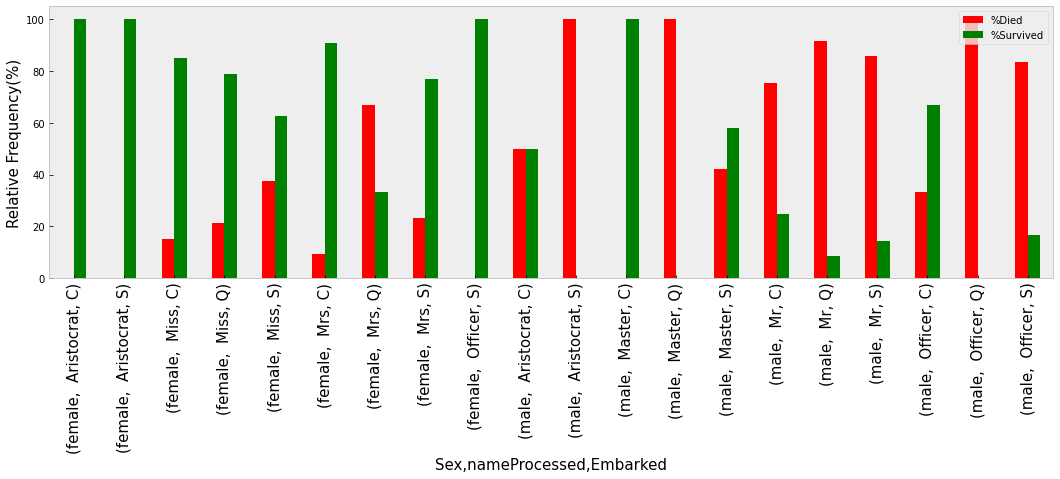

**Findings: Embarked c, sex female and title master and aristocrat had best survival rate.**

In [258]:
doMultivariateAnalysis(df_train.Sex, df_train.nameProcessed, df_train.Embarked)
bold("Findings: Embarked c, sex female and title master and aristocrat had best survival rate.")

## 9.13 (Sex, nameProcessed, ticketProcessed) vs Survived <a id="9.13"></a>

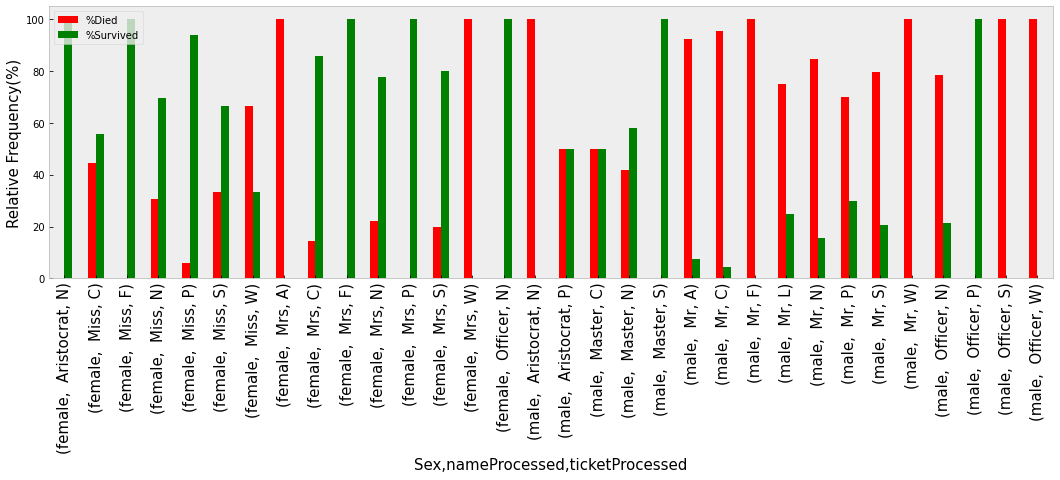

**Findings: ticketProcessed n, w and sex male and title mr mostly died.**

In [259]:
doMultivariateAnalysis(df_train.Sex, df_train.nameProcessed, df_train.ticketProcessed)
bold("Findings: ticketProcessed n, w and sex male and title mr mostly died.")

# 10.Преобразование данных<a id="10"></a>
В этом разделе мы классифицируем наши непрерывные переменные. После этого избыточные и бесполезные функции будут удалены. И, наконец, категориальные переменные будут закодированы в числовые переменные для питания наших моделей машинного обучения.

## 10.1 Связывание непрерывных переменных<a id="10.1"></a>
Мы видели, что возраст обратно коррелирует с выживаемостью, и у младенцев было больше шансов выжить. Мы создадим несколько возрастных категорий, чтобы проверить, какие возрастные категории с большей вероятностью выживут. Мы бы сделали то же самое для платы за проезд, за исключением того, что Справедливая цена положительно коррелирует с Выжившими.

**Примечание:** Связывание непрерывных переменных предотвращает перенастройку, что является общей проблемой для моделей на основе дерева, таких как деревья решений и случайный лес и т.д.

### 10.1.1 Age<a id="10.1.1"></a>

In [260]:
"""Создаем категории ячеек для возраста."""
ageGroups = ["infant","child","teenager","youngAdult","adult","aged"]

"""Создаем диапазон для каждой возрастной категории ячеек."""
groupRanges = [0,5,12,18,35,60,81]

"""Создаём и просматриваем категоризированный возраст с исходным возрастом."""
merged["ageBinned"] = pd.cut(merged.Age, groupRanges, labels = ageGroups)
bold('**Возраст с Категоризированным возрастом:**')
display(merged[['Age', 'ageBinned']].head(2))

****Возраст с Категоризированным возрастом:****

,Age,ageBinned
0,22.0,youngAdult
1,38.0,adult


### 10.1.2 Binning Fare <a id="10.1.2"></a>

In [261]:
"""Создаем категории ячеек для Fare."""
fareGroups = ["low","medium","high","veryHigh"]

"""Создааем диапазон для каждой категории ячеек Fare."""
fareGroupRanges = [-1, 130, 260, 390, 520]

"""Создание и просмотр категоризированного тарифа с оригинальным Fare."""
merged["fareBinned"] = pd.cut(merged.Fare, fareGroupRanges, labels = fareGroups)
bold("Тариф с категоризированным тарифом:")
display(merged[["Fare", "fareBinned"]].head(2))

**Тариф с категоризированным тарифом:**

,Fare,fareBinned
0,7.2500,low
1,71.2833,low


##  10.2 Удаление функций<a id="10.2"></a>
Теперь мы оба преобразовали, и из исходных переменных было произведено преобразование. Поэтому мы должны безопасно отбросить переменные, которые, по нашему мнению, больше не будут полезны для нашего анализа выживания, поскольку они вряд ли будут проанализированы в их необработанных формах.

In [262]:
display(merged.head(2))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabinProcessed,nameProcessed,familySize,ticketProcessed,ageBinned,fareBinned
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,X,Mr,small,A,youngAdult,low
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs,small,P,adult,low


In [263]:
"""Посмотрим на все переменные, которые у нас есть в настоящее время, с их категорией."""
display(merged.head(2))

"""Отбросим функции, которые больше не будут полезны."""
merged.drop(columns = ["Name", "Age", "Fare", "Ticket", "Cabin"], inplace = True, axis = 1)

"""Функции, оставшиеся после удаления"""
bold("Функции, оставшиеся после удаления:")
display(merged.columns)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabinProcessed,nameProcessed,familySize,ticketProcessed,ageBinned,fareBinned
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,X,Mr,small,A,youngAdult,low
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs,small,P,adult,low


**Функции, оставшиеся после удаления:**

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch',
       'Embarked', 'cabinProcessed', 'nameProcessed', 'familySize',
       'ticketProcessed', 'ageBinned', 'fareBinned'],
      dtype='object')

## 10.3 Исправление типов данных<a id="10.3"></a>

In [264]:
"""Типы данных текущих переменных"""
bold("Типы данных текущих переменных:")
display(merged.dtypes)

**Типы данных текущих переменных:**

PassengerId           int64
Survived            float64
Pclass                int64
Sex                  object
SibSp                 int64
Parch                 int64
Embarked             object
cabinProcessed       object
nameProcessed        object
familySize           object
ticketProcessed      object
ageBinned          category
fareBinned         category
dtype: object

1. Типы данных идентификатора пассажира, SibSp и Parch будут сохранены одинаковыми (целочисленными).
2. Сохраненный тип данных будет преобразован в целое число, а остальные типы данных переменных будут преобразованы в категориальные типы данных.

In [265]:
"""Исправление типов данных, преобразование в категориальные переменные."""
merged.loc[:, ["Pclass", "Sex", "Embarked", "cabinProcessed", "nameProcessed", "familySize", "ticketProcessed"]]\
= merged.loc[:, ["Pclass", "Sex", "Embarked", "cabinProcessed", "nameProcessed", "familySize", "ticketProcessed"]]\
.astype('category')

In [266]:
"""Типы данных после исправления"""
bold("Типы данных после исправления:")
display(merged.dtypes)

**Типы данных после исправления:**

PassengerId           int64
Survived            float64
Pclass             category
Sex                category
SibSp                 int64
Parch                 int64
Embarked           category
cabinProcessed     category
nameProcessed      category
familySize         category
ticketProcessed    category
ageBinned          category
fareBinned         category
dtype: object

## 10.4 Кодирование категориальных переменных<a id="10.4"></a>
Мы хотели бы использовать одно горячее кодирование вместо кодирования меток, потому что алгоритм может придать вес более высоким значениям, если label encoding используется для кодирования числовых переменных.

In [267]:
"""Преобразуем категориальные данные в числовые, чтобы использовать нашу модель машинного обучения."""
merged = pd.get_dummies(merged)

"""Давайте визуализируем обновленный набор данных, который будет передан нашим алгоритмам машинного обучения."""
bold("Предварительный просмотр обработанных данных:")
display(merged.head(2))

**Предварительный просмотр обработанных данных:**

,PassengerId,Survived,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,...,ageBinned_infant,ageBinned_child,ageBinned_teenager,ageBinned_youngAdult,ageBinned_adult,ageBinned_aged,fareBinned_low,fareBinned_medium,fareBinned_high,fareBinned_veryHigh
0,1,0.0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,2,1.0,1,0,1,0,0,1,0,1,...,0,0,0,0,1,0,1,0,0,0


# 11.Построение и оценка моделей<a id="11"></a>
После того, как вся предварительная обработка выполнена и обработана, мы готовы обучать классификаторы обработанным данным. Сначала извлеките обучающие и тестовые данные из объединенной переменной. Затем передайте обучающие данные в классификаторы, которые нас интересуют для этой проблемы.

In [268]:
seed = 43

"""Давайте разделим train и test для подачи алгоритма машинного обучения."""
train = merged.iloc[:891, :]
test  = merged.iloc[891:, :]

In [269]:
"""Удалим пассажиров из train и Survived из test """
train = train.drop(columns = ["PassengerId"], axis = 1)
train.Survived = train.Survived.astype(int) 
test = test.drop(columns = ["Survived"], axis = 1) 

In [270]:
"""Извлекаем наборы данных в качестве входных и выходных данных для моделей машинного обучения."""
xTrain = train.drop(columns = ["Survived"], axis = 1) # Input matrix as pandas dataframe (dim:891*47).
yTrain = train['Survived'] # Output vector as pandas series (dim:891*1)

"""Извлечь test"""
xTest  = test.drop("PassengerId", axis = 1).copy()

In [271]:
"""Размеры набора входных и выходных данных."""
print(f"Размер входной матрицы: {xTrain.shape}")
print(f"Размер выходного вектора: {yTrain.shape}")
print(f"Размер тестовых данных: {xTest.shape}")

Размер входной матрицы: (891, 47)
Размер выходного вектора: (891,)
Размер тестовых данных: (418, 47)


## 11.1 Модель Обучения<a id="11.1"></a>
Обучим 10 различных классификаторов для этой задачи бинарной классификации.

In [272]:
"""Построение моделей машинного обучения: 
Мы попробуем 10 различных классификаторов, чтобы найти лучший классификатор после запуска гиперпараметров моделей, 
которые наилучшим образом обобщат невидимые (тестовые) данные."""

"""Теперь инициализируйте все объекты классификаторов."""
"""#1.Logistic Regression"""
lr = LogisticRegression()

"""#2.Support Vector Machines"""
svc = SVC(gamma = "auto")

"""#3.Random Forest Classifier"""
rf = RandomForestClassifier(random_state = seed, n_estimators = 100)

"""#4.KNN"""
knn = KNeighborsClassifier()

"""#5.Gaussian Naive Bayes"""
gnb = GaussianNB()

"""#6.Decision Tree Classifier"""
dt = DecisionTreeClassifier(random_state = seed)

"""#7.Gradient Boosting Classifier"""
gbc = GradientBoostingClassifier(random_state = seed)

"""#8.Adaboost Classifier"""
abc = AdaBoostClassifier(random_state = seed)

"""#9.ExtraTrees Classifier"""
etc = ExtraTreesClassifier(random_state = seed)

"""#10.Extreme Gradient Boosting"""
xgbc = XGBClassifier(random_state = seed)


"""List of all the models with their indices"""
modelNames = ["LR", "SVC", "RF", "KNN", "GNB", "DT", "GBC", "ABC", "ETC", "XGBC"]
models = [lr, svc, rf, knn, gnb, dt, gbc, abc, etc, xgbc]

In [273]:
"""Создайте функцию, которая возвращает точность обучения различных моделей."""
def calculateTrainAccuracy(model):
    """Возвращает точность обучения модели"""
    
    model.fit(xTrain, yTrain)
    trainAccuracy = model.score(xTrain, yTrain)
    trainAccuracy = round(trainAccuracy*100, 2)
    return trainAccuracy

# Calculate train accuracy of all the models and store them in a dataframe
modelScores = list(map(calculateTrainAccuracy, models))
trainAccuracy = pd.DataFrame(modelScores, columns = ["trainAccuracy"], index=modelNames)
trainAccuracySorted = trainAccuracy.sort_values(by="trainAccuracy", ascending=False)
bold("Точность обучения классификаторов:")
display(trainAccuracySorted)

[18:00:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



**Точность обучения классификаторов:**

,trainAccuracy
RF,90.91
DT,90.91
ETC,90.91
XGBC,90.12
GBC,86.64
KNN,86.08
LR,84.06
ABC,84.06
SVC,83.05
GNB,80.02


**Похоже, что все модели, основанные на дереве, имеют самую высокую точность передачи, за которой следуют KNN, LR, ABC и SVC. Но обучающей точности модели недостаточно, чтобы определить, может ли модель обобщать невидимые данные или нет. Потому что обучающие данные - это то, с чем наша модель была обучена, то есть данные, которые наша модель уже видела. Мы все знаем, что целью построения модели машинного обучения является обобщение невидимых данных, т.е. Данных, которые наша модель еще не видела. Следовательно, мы не можем использовать точность обучения для оценки нашей модели, скорее мы должны знать, как наша модель будет работать с данными, которые наша модель еще не увидела.**

## 11.2 Оценка модели<a id="11.2"></a>
Таким образом, в принципе, для оценки производительности модели нам нужны некоторые данные (входные данные), для которых мы знаем основную истину (метку). Для этой проблемы мы не знаем основной истины для набора test, но мы знаем для набора train. Таким образом, идея состоит в том, чтобы обучить и оценить производительность модели на разных данных. Единственное, что мы можем сделать, это разделить состав на две группы, обычно в соотношении 80:20. Это означает, что мы будем обучать нашу модель на 80 % обучающих данных, а остальные 20 % мы оставляем за собой для оценки модели, поскольку мы знаем основную истину для этих 20 % данных. Затем мы можем сравнить наш прогноз модели с этой основной правдой (для 20 % данных). Вот как мы можем определить, как наша модель будет работать с невидимыми данными. Это первый метод оценки модели. В sklearn у нас есть метод train_test_split для этого.

Разделение Train_test имеет свои недостатки. Потому что этот подход вводит предвзятость, поскольку мы не используем все наши наблюдения для тестирования, а также уменьшаем размер данных о train. Чтобы преодолеть это, мы можем использовать метод, называемый перекрестной проверкой, при котором все данные периодически используются для обучения и тестирования. Таким образом, мы можем уменьшить смещение, вносимое train_test_split. Из различных методов перекрестной проверки мы бы использовали k-кратную перекрестную проверку. В sklearn у нас есть метод cross_val_score для вычисления k-кратного балла перекрестной проверки.

Однако по мере увеличения набора поездов train_test_split имеет свое преимущество перед k-кратной перекрестной проверкой. Train_test_split в k раз быстрее, чем перекрестная проверка в k раз. Если обучающий набор очень велик, как train_test_split, так и k-кратная перекрестная проверка выполняются одинаково. Таким образом, для больших обучающих данных train_test_split предпочтительнее k-кратной перекрестной проверки для ускорения процесса обучения.

### 11.2.1 K-Кратная Перекрестная проверка<a id="11.2.1"></a>
Допустим, мы будем использовать 10-кратную перекрестную проверку. Итак, k = 10, и у нас всего 891 наблюдение. Каждая складка будет иметь 891/10 = 89,1 наблюдений. Таким образом, в основном перекрестная проверка k-кратности использует fold-1 (89,1 выборки) в качестве тестового набора и k-1 (9 сгибов) в качестве обучающих наборов и вычисляет точность теста.Эта процедура повторяется k раз (если k = 10, то 10 раз); каждый раз другая группа наблюдений рассматривается как проверочный или тестовый набор. Этот процесс приводит к получению k оценок точности теста, которые затем усредняются.

In [274]:
"""Создаем функцию, которая возвращает средний балл перекрестной проверки для разных моделей."""
def calculateXValScore(model):
    """Возвращает результаты перекрестной проверки моделей."""
    
    xValScore = cross_val_score(model, xTrain, yTrain, cv = 10, scoring="accuracy").mean()
    xValScore = round(xValScore*100, 2)
    return xValScore

# Calculate cross validation scores of all the models and store them in a dataframe
modelScores = list(map(calculateXValScore, models))
xValScores = pd.DataFrame(modelScores, columns = ["xValScore"], index=modelNames)
xValScoresSorted = xValScores.sort_values(by="xValScore", ascending=False)
bold("Модель 10-fold Cross Validation Score:")
display(xValScoresSorted)

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[18:00:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:00:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[18:00:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[18:00:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:00:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[18:00:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:00:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[18:00:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:00:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[18:00:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


**Модель 10-fold Cross Validation Score:**

,xValScore
LR,82.83
SVC,82.72
GBC,82.72
XGBC,82.72
ABC,81.60
RF,80.81
ETC,80.81
KNN,80.59
DT,79.69
GNB,75.54


****Выводы:** Похоже, что LR и SVC имеют самую высокую точность перекрестной проверки среди классификаторов, за которыми следуют GBC, GBC, KNN, ABC, RF и т. Д.

## 11.2.2 Настройка гиперпараметров<a id="11.2.2"></a>
**Теперь давайте добавим поиск по сетке ко всем классификаторам в надежде оптимизировать их гиперпараметры и тем самым повысить их точность. Являются ли параметры модели по умолчанию лучшим выбором? Давайте выясним.**

**Примечание:** Гиперпараметры должны быть настроены для всех моделей, которые вы пробуете, потому что только тогда вы сможете сказать, что является лучшим, что вы можете получить от этой конкретной модели.

In [275]:
"""Сначала определите все гиперпараметры моделей "один за другим:"""

lrParams = {"penalty":["l1", "l2"],
            "C": np.logspace(0, 4, 10),
            "max_iter":[5000]}

gbcParams = {"learning_rate": [0.01, 0.02, 0.05, 0.01],
              "max_depth": [4, 6, 8],
              "max_features": [1.0, 0.3, 0.1], 
              "min_samples_split": [ 2, 3, 4],
              "random_state":[seed]}

svcParams = {"C": np.arange(6,13), 
              "kernel": ["linear","rbf"],
              "gamma": [0.5, 0.2, 0.1, 0.001, 0.0001]}

dtParams = {"max_features": ["auto", "sqrt", "log2"],
             "min_samples_split": np.arange(2,16), 
             "min_samples_leaf":np.arange(1,12),
             "random_state":[seed]}

rfParams = {"criterion":["gini","entropy"],
             "n_estimators":[10, 15, 20, 25, 30],
             "min_samples_leaf":[1, 2, 3],
             "min_samples_split":np.arange(3,8), 
             "max_features":["sqrt", "auto", "log2"],
             "random_state":[44]}

knnParams = {"n_neighbors":np.arange(3,9),
              "leaf_size":[1, 2, 3, 5],
              "weights":["uniform", "distance"],
              "algorithm":["auto", "ball_tree","kd_tree","brute"]}

abcParams = {"n_estimators":[1, 5, 10, 15, 20, 25, 40, 50, 60, 80, 100, 130, 160, 200, 250, 300],
              "learning_rate":[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5],
              "random_state":[seed]}

etcParams = {"max_depth":[None],
              "max_features":[1, 3, 10],
              "min_samples_split":[2, 3, 10],
              "min_samples_leaf":[1, 3, 10],
              "bootstrap":[False],
              "n_estimators":[100, 300],
              "criterion":["gini"], 
              "random_state":[seed]}

xgbcParams = {"n_estimators": (150, 250, 350, 450, 550, 650, 700, 800, 850, 1000),
              "learning_rate": (0.01, 0.6),
              "subsample": (0.3, 0.9),
              "max_depth": np.arange(3,10),
              "colsample_bytree": (0.5, 0.9),
              "min_child_weight": [1, 2, 3, 4],
              "random_state":[seed]}

In [276]:
"""Создайте функцию для настройки гиперпараметров выбранных моделей."""
def tuneHyperparameters(model, params):
    
    gridSearch = GridSearchCV(model, params, verbose=0, cv=10, scoring="accuracy", n_jobs = -1)
    gridSearch.fit(xTrain, yTrain)
    bestParams, bestScore = gridSearch.best_params_, round(gridSearch.best_score_*100, 2)
    return bestScore, bestParams

In [277]:
modelNamesToTune = [x for x in modelNames if x not in ["GNB","XGBC"]]
modelsToTune = [lr, svc, rf, knn, dt, gbc, abc, etc]
parametersLists = [lrParams, svcParams, rfParams, knnParams, dtParams, gbcParams, abcParams, etcParams]
bestScoreAndHyperparameters = list(map(tuneHyperparameters, modelsToTune, parametersLists))

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [       nan 0.82830212        nan 0.82942572        nan 0.8260799
        nan 0.8260799         nan 0.8260799         nan 0.8260799
        nan 0.8260799         nan 0.8260799         nan 0.8260799
        nan 0.8260799 ]



In [278]:
"""Создадим фрейм данных для хранения лучших результатов и лучших параметров."""
bestScoreAndHyperparameters = pd.DataFrame(bestScoreAndHyperparameters,
                                             index=modelNamesToTune,
                                             columns=["tunedAccuracy", "bestHyperparameters"])
bestScoreAndHyperparametersSorted = bestScoreAndHyperparameters.sort_values(by="tunedAccuracy",
                                                                                ascending=False)
bold("Точность модели после настройки гиперпараметров:")
display(bestScoreAndHyperparametersSorted.iloc[:,0].to_frame())

**Точность модели после настройки гиперпараметров:**

,tunedAccuracy
GBC,84.18
RF,84.06
ABC,83.39
ETC,83.39
SVC,83.28
LR,82.94
KNN,82.94
DT,81.60


In [279]:
"""Проверим LR отдельно"""
print(f"LR Best Score: {bestScoreAndHyperparametersSorted.loc['LR'][0]}")
print(f"And Best Parameters: {bestScoreAndHyperparametersSorted.loc['LR'][1]}")

LR Best Score: 82.94
And Best Parameters: {'C': 2.7825594022071245, 'max_iter': 5000, 'penalty': 'l2'}


**Поскольку точность возрастает, можно сказать, что наиболее точная модель логистической регрессии использует C = 2.7825594022071245 и штраф = l2 в качестве гиперпараметров.**

## 11.2.3  Выбор модели<a id="11.2.3"></a>
Давайте сравним наши модели по их показателю точности после запуска гиперпараметров с результатами перекрестной проверки, чтобы выбрать лучшие модели для дальнейшего изучения этой проблемы классификации.

c:\users\vadim\appdata\local\programs\python\python39\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



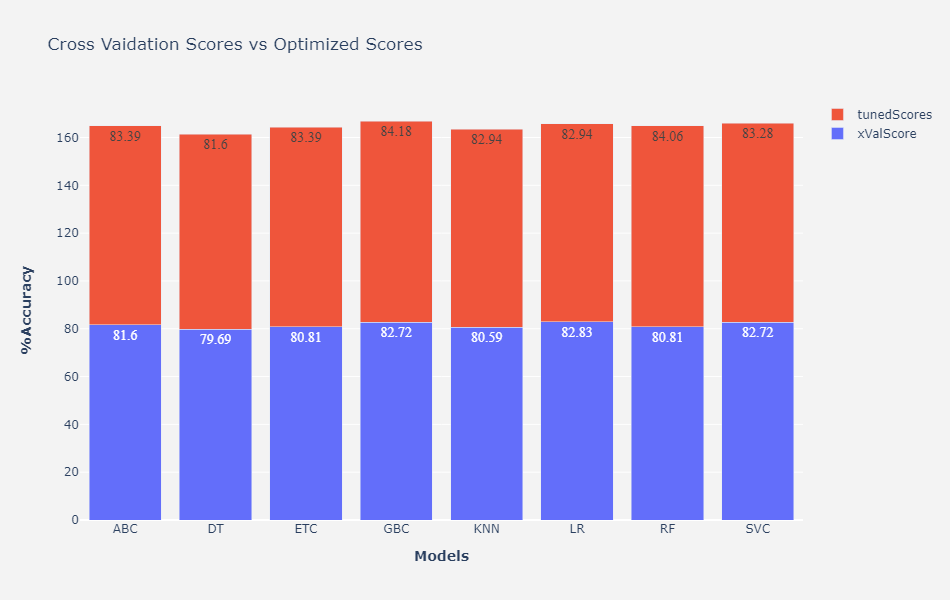

In [280]:
"""Создадим функцию, которая сравнивает результаты перекрестной проверки с настроенными оценками для разных моделей путем их
построения."""
def compareModelsAccuracy():
    
    # Сортировка по индексу и преобразование в объект серии для построения графика.
    xValScore = xValScoresSorted[~xValScoresSorted.index.isin(["XGBC","GNB"])].sort_index().T.squeeze()
    tunedScore = bestScoreAndHyperparametersSorted.iloc[:,0].sort_index().T.squeeze()
    
    fig=make_subplots(
        rows=1, 
        cols=1,
        vertical_spacing=0.3,
        print_grid=False) # This suppresses "This is the format of your plot grid:" text from popping out.

    fig.add_trace(go.Bar(x=xValScore.index,
                             y=xValScore,
                             text=xValScore,
                             hoverinfo="x+y",
                             textposition="auto",
                             name="xValScore",
                             textfont=dict(family="sans serif",size=14),
                             ),
                     row=1,
                     col=1
                     )

    fig.add_trace(go.Bar(x=tunedScore.index,
                             y=tunedScore,
                             text=tunedScore,
                             hoverinfo="x+y",
                             textposition="auto",
                             name="tunedScores",
                             textfont=dict(family="sans serif",size=14),
                             ),
                     row=1,
                     col=1
                     )
        
    fig.layout.update(
        height=600, 
        width=950,
        hovermode="closest",
        barmode = "stack",
        title_text = "Cross Vaidation Scores vs Optimized Scores",
        paper_bgcolor="rgb(243, 243, 243)",
        plot_bgcolor="rgb(243, 243, 243)"
        )

    fig.layout.yaxis1.update(title="<b>%Accuracy</b>")
    
    fig.layout.xaxis1.update(title="<b>Models</b>")
    return fig.show()

"""Вызоваем функцию для построения результатов."""
compareModelsAccuracy()

**Выводы:** Среди классификаторов RF и GBC имеют самую высокую точность после настройки гиперпараметров. Surf и GBC, возможно, заслуживают дальнейшего изучения этой проблемы классификации. Поэтому мы выбираем RF и GBC.

**Примечание:** Пожалуйста, обратите внимание, что если бы мы выбрали наш классификатор на основе результатов перекрестной проверки, мы бы не выбрали RF и GBC в качестве наших лучших классификаторов, вместо этого мы бы выбрали LR и SVC. Поэтому рекомендуется выбирать лучшие классификаторы на основе точности после настройки гиперпараметров, хотя это требует больших вычислительных затрат.

## 11.3 Переподготовка и прогнозирование с использованием оптимизированных гиперпараметров<a id="11.3"></a>
Таким образом, у нас есть наши лучшие классификаторы с их лучшими гиперпараметрами, которые обеспечивают максимальную точность модели. Это означает, что если мы переобучим классификаторы, используя их лучшие гиперпараметры, мы сможем получить тот же балл, который мы получили после настройки гиперпараметров (см. часть 14.4). Давайте переподготовим наши классификаторы, а затем используем перекрестную проверку для расчета точности обученной модели. Таким образом, мы получим тот же показатель точности, что и после настройки гиперпараметров. Давайте переобучим модели с оптимизированными гиперпараметрами.

In [281]:
"""Создаем экземпляры моделей с оптимизированными гиперпараметрами."""
# Sort the dataframe by index and select bestHyperparameters column
tunedParams = bestScoreAndHyperparametersSorted.sort_index().loc[:,"bestHyperparameters"]
abc = AdaBoostClassifier(**tunedParams["ABC"])
dt  = DecisionTreeClassifier(**tunedParams["DT"])
etc = ExtraTreesClassifier(**tunedParams["ETC"])
gbc = GradientBoostingClassifier(**tunedParams["GBC"])
knn = KNeighborsClassifier(**tunedParams["KNN"])
lr  = LogisticRegression(**tunedParams["LR"])
rf  = RandomForestClassifier(**tunedParams["RF"])
svc = SVC(**tunedParams["SVC"])



"""Обучаем все модели оптимизированным гиперпараметрам."""
models = [abc, dt, etc, gbc, knn, lr, rf, svc]
modelNames = tunedParams.index.values
keyValue = dict(zip(modelNames, models))
bold("10-fold Cross Validation после оптимизации:")
xValScore = []
for key, value in keyValue.items():
    # Train the models with optimized parameters using cross validation.
    # No need to fit the data. cross_val_score does that for us.
    # But we need to fit train data for prediction in the follow session.
    value.fit(xTrain, yTrain)
    scores = cross_val_score(value, xTrain, yTrain, cv = 10, scoring="accuracy")*100
    xValScore.append(scores.mean())
    print("Mean Accuracy: {:.4f} (+/- {:.4f}) [{}]".format(scores.mean(), scores.std(), key))

**10-fold Cross Validation после оптимизации:**

Mean Accuracy: 83.3920 (+/- 2.9040) [ABC]
Mean Accuracy: 81.5955 (+/- 3.0106) [DT]
Mean Accuracy: 83.3945 (+/- 4.0802) [ETC]
Mean Accuracy: 84.1773 (+/- 3.2999) [GBC]
Mean Accuracy: 82.9426 (+/- 2.5855) [KNN]
Mean Accuracy: 82.9426 (+/- 3.0348) [LR]
Mean Accuracy: 84.0649 (+/- 4.1889) [RF]
Mean Accuracy: 83.2809 (+/- 3.6873) [SVC]


**Нам успешно удалось воспроизвести тот же результат, которого мы достигли только после настройки гиперпараметров. Теперь, если мы будем прогнозировать, используя эти обученные модели, мы должны получить максимальную точность тестирования, возможную для этой модели. Итак, давайте спрогнозируем, используя эти обученные модели:**

In [282]:
"""Сделаем прогноз, используя все обученные модели."""
modelPrediction = pd.DataFrame({"RF":rf.predict(xTest),
                                 "GBC":gbc.predict(xTest),
                                 "ABC":abc.predict(xTest),
                                 "ETC":etc.predict(xTest), 
                                 "DT":dt.predict(xTest),
                                 "SVC":svc.predict(xTest), 
                                 "KNN":knn.predict(xTest), 
                                 "LR":lr.predict(xTest)
                                })

"""Давайте посмотрим, как каждая модель классифицирует определенный класс."""
bold("Все модели предсказывают:")
display(modelPrediction.head())

**Все модели предсказывают:**

,RF,GBC,ABC,ETC,DT,SVC,KNN,LR
0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,1


## 11.4 Важность функции<a id="11.4"></a>
Придают ли классификаторы одинаковый приоритет каждой функции? Давайте визуализируем важность признаков, придаваемую нашими классификаторами.

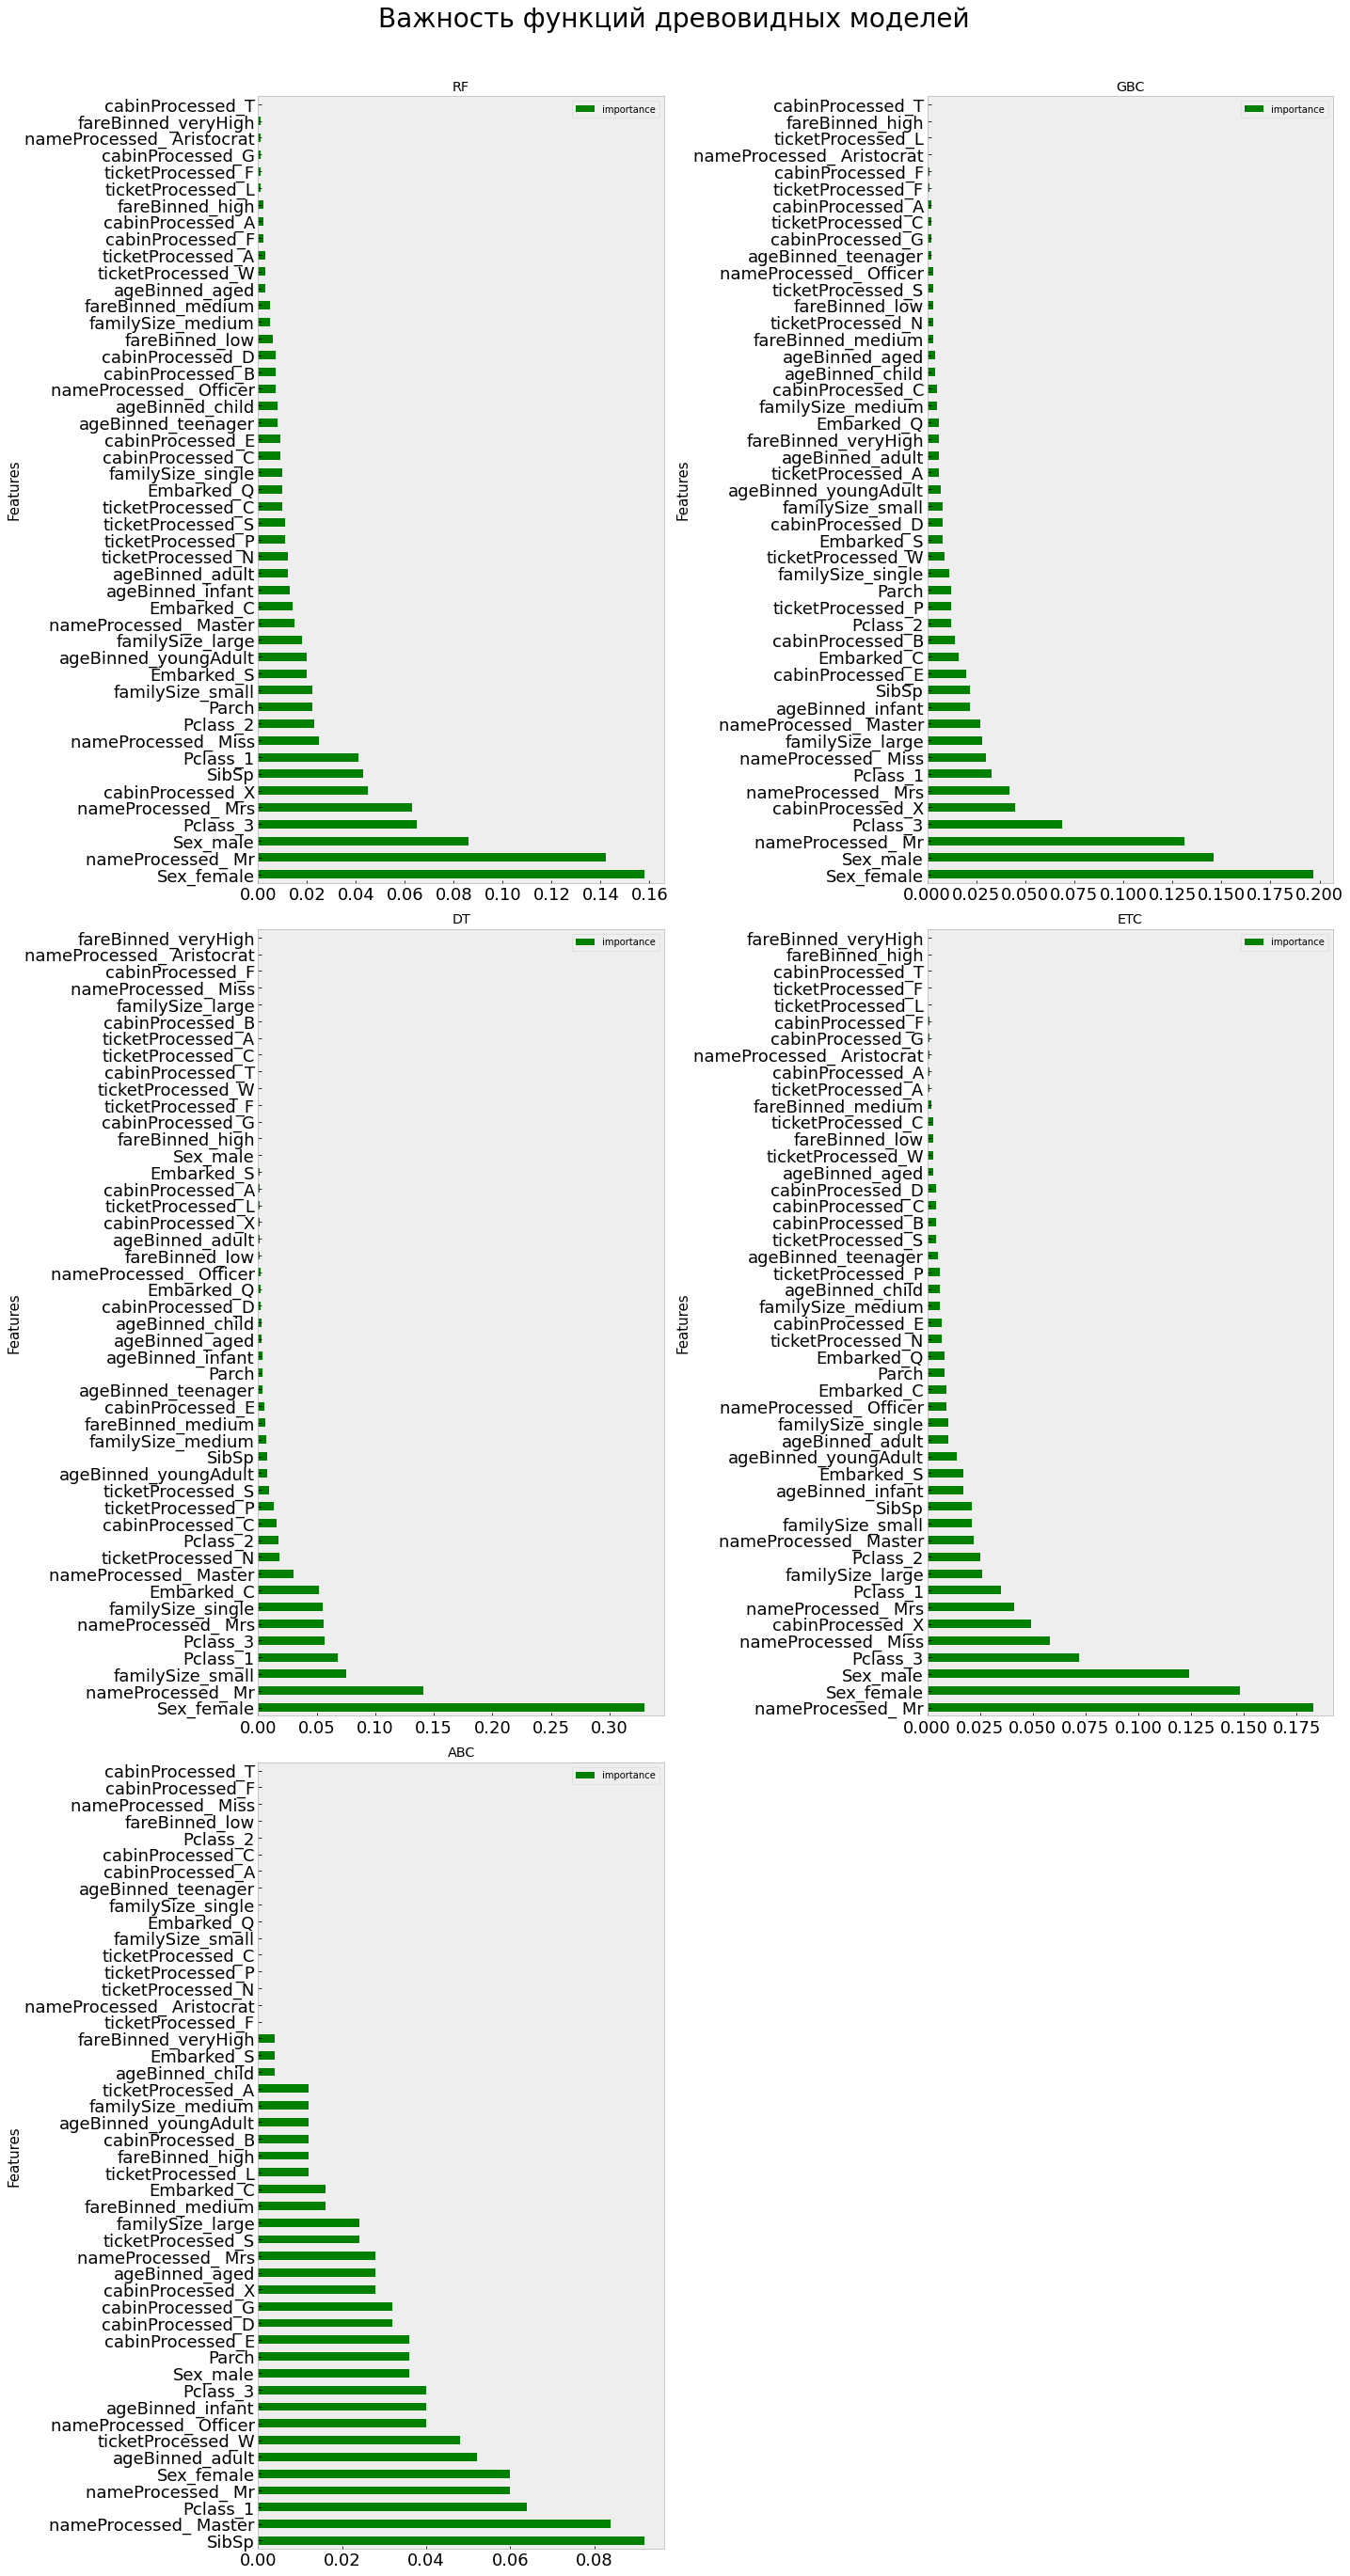

In [283]:
"""Создаем функцию, которая отображает важность объектов по выбранным древовидным моделям."""
def plotFeatureImportance(model):
    
    importance = pd.DataFrame({"feature": xTrain.columns,
                              "importance": np.round(model.feature_importances_,3)})
    importanceSorted = importance.sort_values(by = "importance", ascending = False).set_index("feature")
    return importanceSorted

"""Создаем подзаголовки, имеющие важное значение для объектов of rf, gbc, dt, etc, and abc."""
fig, axes = plt.subplots(3,2, figsize = (20,40))
fig.suptitle("Важность функций древовидных моделей", fontsize = 28)
treeModels = [rf, gbc, dt, etc, abc]
treeModelNames = ["RF", "GBC", "DT", "ETC", "ABC"]
for ax, model, name in zip(axes.flatten(), treeModels, treeModelNames):
    plotFeatureImportance(model).plot.barh(ax=ax, title=name, fontsize=18, color="green")
    ax.set_ylabel("Features", fontsize = 15)
fig.delaxes(ax = axes[2,1]) # We don"t need the last subplot.
fig.tight_layout(rect = [0, 0.03, 1, 0.97])

**Выводы:** RF, DT и т. Д. И ABC (в частности) не придают некоторым функциям значения (нулевая важность). С другой стороны, GBC придает всем функциям более или менее важное значение, но не придает нулевого значения каким-либо функциям. Это модели на основе дерева, которые по умолчанию имеют метод "feature_importances_". У LR, KNN и SVC этого метода нет. В этой задаче SVC использует ядро rbf (возможно только для линейного ядра для отображения важности объекта), поэтому невозможно просмотреть важность объекта, заданную SVC. Хотя это сложнее, мы бы попытались получить значение функции, придаваемое LR.

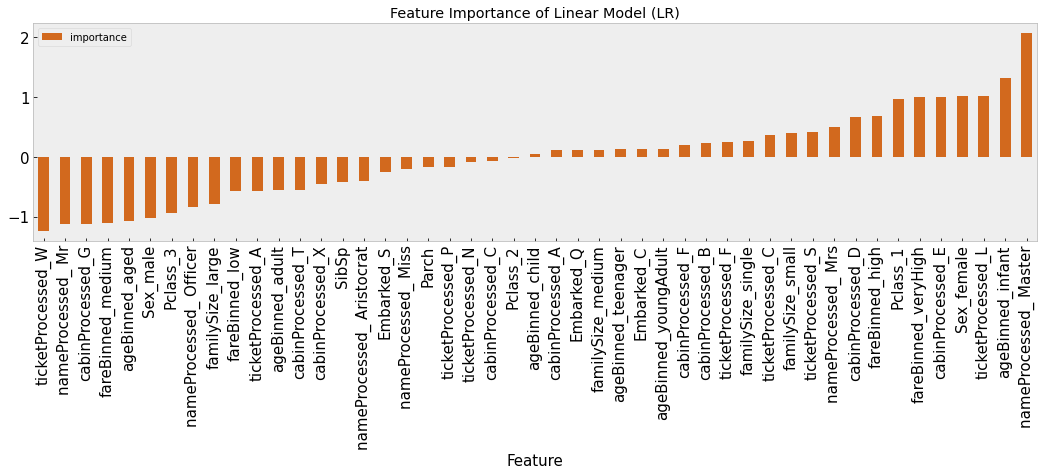

In [284]:
"""Давайте построим график важности функции LR."""
fig, ax = plt.subplots(figsize=(18,4))
coeff = pd.DataFrame({"feature":xTrain.columns,
                      "importance":np.transpose(lr.coef_[0])})

coeff.sort_values(by = "importance").set_index("feature")\
.plot.bar(title = "Feature Importance of Linear Model (LR)", color="chocolate", ax=ax)
ax.tick_params(axis = "both", which = "major", labelsize = 15)
ax.tick_params(axis = "both", which = "minor", labelsize = 15)
ax.set_xlabel("Feature", fontsize = 15)
plt.show()

**Выводы:** Мы видим некоторые отрицательные значения, что означает, что более высокое значение соответствующего признака больше подталкивает классификацию к отрицательному классу (в нашем случае 0), что, конечно, является тем, о чем мы уже знаем. Некоторым функциям, таким как Family_size_single, embarked_q, embarked_c и cabin_f, lr придал нулевое значение.

## 11.5 Кривые обучения<a id="11.5"></a>
Давайте построим кривые обучения для оптимизированных классификаторов, чтобы увидеть их компромисс между отклонением и отклонением.

In [285]:
"""Создайте функцию, которая возвращает кривые обучения для разных классификаторов."""
def plotLearningCurve(model):
    """Возвращает график кривой обучения модели."""
    
    # Создать матрицу объектов и целевой вектор
    X, y = xTrain, yTrain
    # Создаем CV training и test оценку для различных размеров тренировочных наборов
    trainSizes, trainScores, testScores = learning_curve(model, X, y, cv = 10,
                                                    scoring="accuracy", n_jobs = -1, 
                                                    train_sizes = np.linspace(0.01, 1.0, 17), # 17 different sizes of the training set
                                                    random_state = seed)
                                                    

    # Создаем средние значения и стандартные отклонения результатов набора тренировок
    trainMean = np.mean(trainScores, axis = 1)
    trainStd = np.std(trainScores, axis = 1)

    # Создаем средние значения и стандартные отклонения результатов набора тестов
    testMean = np.mean(testScores, axis = 1)
    testStd = np.std(testScores, axis = 1)

    plt.plot(trainSizes, trainMean, "o-", color = "red",  label = "training score")
    plt.plot(trainSizes, testMean, "o-", color = "green", label = "cross-validation score")

    plt.fill_between(trainSizes, trainMean - trainStd, trainMean + trainStd, alpha = 0.1, color = "r") # Alpha controls band transparency.
    plt.fill_between(trainSizes, testMean - testStd, testMean + testStd, alpha = 0.1, color = "g")

    font_size = 15
    plt.xlabel("Training Set Size", fontsize = font_size)
    plt.ylabel("Accuracy Score", fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = "best")
    plt.grid()

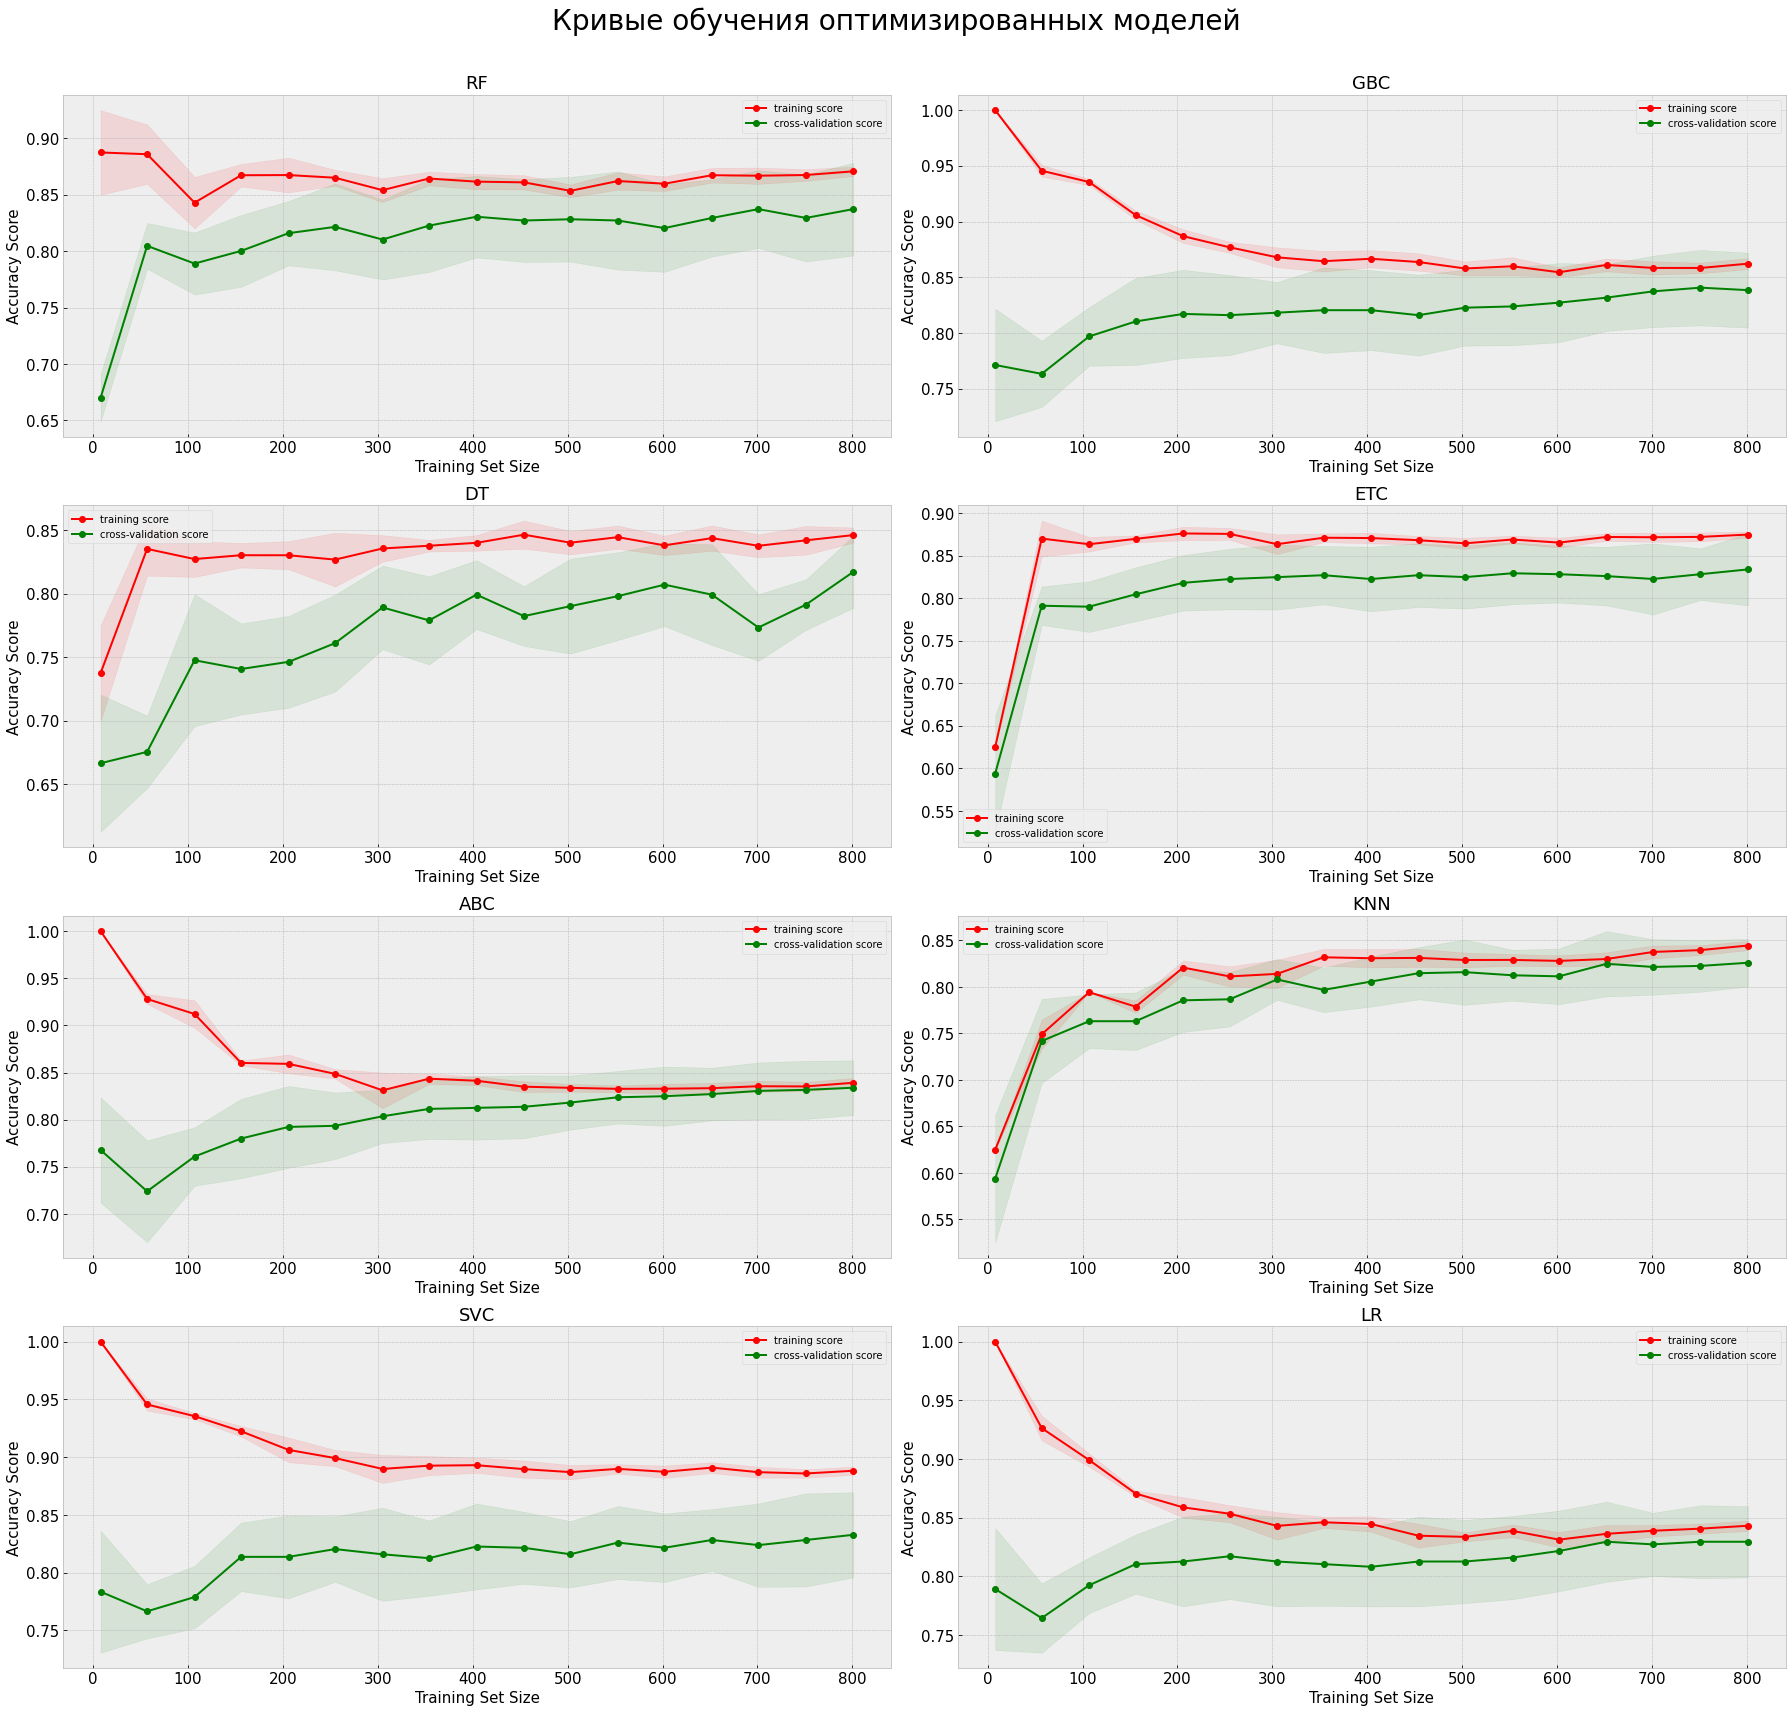

In [286]:
"""Теперь построим кривые обучения оптимизированных моделей на подзаголовках."""
plt.figure(figsize = (25,25))
lcModels = [rf, gbc, dt, etc, abc, knn, svc, lr]
lcLabels = ["RF", "GBC", "DT", "ETC", "ABC", "KNN", "SVC", "LR"]

for ax, model, label in zip (range(1,9), lcModels, lcLabels):
    plt.subplot(4,2,ax)
    plotLearningCurve(model)
    plt.title(label, fontsize = 18)
plt.suptitle("Кривые обучения оптимизированных моделей", fontsize = 28)
plt.tight_layout(rect = [0, 0.03, 1, 0.97])

**Выводы:**
1. RF, DT, SVC и ETC в порядке. Среди них SVC делает все возможное с точки зрения компромисса между смещение-дисперсия, поскольку точность обучения svc и точность перекрестной проверки почти равны.

2. С другой стороны, кривая обучения GBC, ABC, KNN и LR указывает на небольшое смещение или низкую дисперсию (недостаточное соответствие), и, поскольку кривые уже сошлись, добавление дополнительных обучающих данных может просто не помочь. Скорее, может помочь добавление дополнительных функций (столбцов) и увеличение сложности модели.